In [1]:
import os
import textwrap  
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy import stats
from scipy.stats import spearmanr
from sklearn.utils import resample
from statsmodels.stats.inter_rater import cohens_kappa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.metrics import f1_score

In [2]:
### CLEANING DATA

###EPITOME
epitome = pd.read_csv("original_samples/sample_epitome.csv")
epitome = epitome[
    [
        "sp_id",
        "rp_id",
        "level_emotional_reactions",
        "level_explorations",
        "level_interpretations",
    ]
]
epitome.to_csv("data/epitome/sample_ratings_crowdsourced.csv", index=False)

###PERCEIVED EMPATHY
perceived_empathy = pd.read_csv(
    "original_samples/sample_perceived_empathy_annotations.csv"
)
perceived_empathy = perceived_empathy.rename(columns={"OriginalDiscloserID": "id"})
perceived_empathy = perceived_empathy[
    [
        "id",
        "m_understood",
        "m_validated",
        "m_affirmed",
        "m_seen",
        "m_accepted",
        "m_caredfor",
        "m_emotional",
        "m_practical",
        "m_motivation",
    ]
]
perceived_empathy.to_csv(
    "data/perceived_empathy/sample_ratings_crowdsourced.csv", index=False
)

###EMPATHETIC DIALOGUES
empathetic_dialogues = pd.read_csv("original_samples/sample_empatheticdialogues.csv")
empathetic_dialogues = empathetic_dialogues.drop_duplicates(subset=["conv_id"])
empathetic_dialogues["empathy"] = empathetic_dialogues[["empathy1", "empathy2"]].mean(
    axis=1
)
empathetic_dialogues["fluency"] = empathetic_dialogues[["fluency1", "fluency2"]].mean(
    axis=1
)
empathetic_dialogues["relevance"] = empathetic_dialogues[
    ["relevance1", "relevance2"]
].mean(axis=1)
empathetic_dialogues = empathetic_dialogues[
    ["conv_id", "empathy", "fluency", "relevance"]
]
empathetic_dialogues.to_csv(
    "data/empatheticdialogues/sample_ratings_crowdsourced.csv", index=False
)

# ###RPG
rpg = pd.read_csv("original_samples/sample_rpg_annotations.csv")
rpg = rpg.drop(
    columns=[
        "user_id",
        "id",
        "validating_emotions_example",
        "encouraging_elaboration_example",
        "demonstrating_understanding_example",
        "self_oriented_example",
        "advice_giving_example",
        "dismissing_emotions_example",
        "time_created",
    ]
)
rpg_mean = rpg.groupby("conversation_id").mean().reset_index()
rpg_mean.to_csv("data/rpg/sample_ratings_crowdsourced.csv", index=False)


In [3]:
# List of base files containing ratings and annotations from different sources
base_files = [
    "expert_ratings.csv",  # Ratings from the first expert
    "expert2_ratings.csv",  # Ratings from the second expert
    "expert3_ratings.csv",
    "llm_annotations/llm_gemini-2.5.csv",  # Annotations from GPT4
    "sample_ratings_crowdsourced.csv",  # Crowdsourced ratings
]

# Dictionary defining datasets with their respective file paths, sort columns, and dimensions
datasets = {
    "rpg": {
        "files": [
            f"data/rpg/{file}" for file in base_files
        ],  # File paths for RPG dataset
        "sort_column": "conversation_id",
        "dimensions": [
            "validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",
        ],  # Dimensions for RPG dataset
    },
    "perceived_empathy": {
        "files": [
            f"data/perceived_empathy/{file}" for file in base_files
        ],  # File paths for Perceived Empathy dataset
        "sort_column": "id",
        "dimensions": [
            "m_understood",
            "m_validated",
            "m_affirmed",
            "m_seen",
            "m_accepted",
            "m_caredfor",
            "m_emotional",
            "m_practical",
            "m_motivation",
        ],  # Dimensions for Perceived Empathy dataset
    },
    "empatheticdialogues": {
        "files": [
            f"data/empatheticdialogues/{file}" for file in base_files
        ],  # File paths for Empathetic Dialogues dataset
        "sort_column": "conv_id",
        "dimensions": [
            "empathy",
            "relevance",
            "fluency",
        ],  # Dimensions for Empathetic Dialogues dataset
    },
    "epitome": {
        "files": [
            f"data/epitome/{file}" for file in base_files
        ],  # File paths for Epitome dataset
        "sort_column": "sp_id",
        "dimensions": [
            "level_emotional_reactions",
            "level_explorations",
            "level_interpretations",
        ],  # Dimensions for Epitome dataset
    },
}

In [6]:
###COMBINING ANNOTATION DATA FROM ALL DATASETS
def order_by_column(df, column):
    try:
        return df.sort_values(by=column).reset_index(drop=True)
    except KeyError:
        print(f"Column '{column}' not found in DataFrame. Available columns: {df.columns.tolist()}")
        return df

def load_and_process(filepath, sort_column):
    df = pd.read_csv(filepath)
    return order_by_column(df, sort_column)


data = {}
# List of annotation methods corresponding to the files in each dataset
annotation_methods = ["expert1", "expert2", "expert3", "llm", "crowd"]

for key in datasets.keys():
    for i in range(len(datasets[key]["files"])):
        data[key, annotation_methods[i]] = load_and_process(
            datasets[key]["files"][i], datasets[key]["sort_column"]
        )
        data[key, annotation_methods[i]]["annotation_method"] = annotation_methods[i]

median_expert_ratings = {}

for key in datasets.keys():
    expert1_df = data[key, "expert1"]
    expert2_df = data[key, "expert2"]
    expert3_df = data[key, "expert3"]
    median_df = expert1_df.copy() 
    
    # Calculate the median for each dimension and sample
    for dimension in datasets[key]["dimensions"]:
        # For each row/sample, get all three expert ratings and calculate median
        for idx in range(len(median_df)):
            experts_values = [
                expert1_df.iloc[idx][dimension],
                expert2_df.iloc[idx][dimension],
                expert3_df.iloc[idx][dimension]
            ]
            median_df.at[idx, dimension] = np.median(experts_values)
            
    median_expert_ratings[key] = median_df

for key in datasets.keys():
    median_expert_df = median_expert_ratings[key]
    # Set the annotation method to 'experts'
    median_expert_df["annotation_method"] = "experts"
    data[key, "experts"] = median_expert_df

data_combined = {}


# Concatenate data for all annotation methods within each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat(
        data[key, annotation_methods[i]] for i in range(len(annotation_methods))
    )


# Add the 'experts' data to the combined data for each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat([data_combined[key], data[key, "experts"]])


# Combine all datasets into a single DataFrame by concatenating along the columns
data_combined_all = pd.concat((data_combined[key] for key in datasets.keys()), axis=1)


# Rename columns to include dataset-specific identifiers
data_combined_all.rename(
    columns={
        "conv_id": "empathetic_conversation_id",
        "sp_id": "epitome_conversation_id",
        "id": "perceived_conversation_id",
        "conversation_id": "rpg_conversation_id",
    },
    inplace=True,
)

# Save the combined DataFrame to a CSV file
data_combined_all.to_csv(
    "data/combined_annotations_across_methods_and_datasets.csv", index=False
)

In [7]:
# CALCULAtING SPEARMAN CORRELATION AND WEIGHTED COHEN'S KAPPA BETWEEN DIFFERENT ANNOTATION METHODS FOR EACH DATASET

df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

# Define the pairs of annotators to compare
annotator_pairs = [
    ("experts", "llm"),
    ("experts", "crowd"),
    ("llm", "crowd"),
    ("expert1", "expert2"),
    ("expert2", "expert3"),
    ("expert3", "expert1"),
]

# Initialize a dictionary to store the results of the analysis
results = {
    "Dataset": [],  # Name of the dataset
    "Dimension": [],  # Dimension being analyzed
    "Annotator Pair": [],  # Pair of annotators being compared
    "Spearman Correlation": [],  # Spearman correlation value
    "Spearman P-value": [],  # P-value for the Spearman correlation
    "Fisher CI Lower": [],  # Lower bound of Fisher confidence interval
    "Fisher CI Upper": [],  # Upper bound of Fisher confidence interval
    "Weighted Cohen's Kappa": [],  # Weighted Cohen's Kappa value
    "Kappa Z-statistic": [],  # Z-statistic of Cohen's Kappa
    "Kappa P-value": [],  # P-value of Cohen's Kappa
}


# Function to determine the dataset name based on the dimension
def get_dataset_name(dimension):
    if dimension in datasets["empatheticdialogues"]["dimensions"]:
        return "Empathetic Dialogues"
    elif dimension in datasets["epitome"]["dimensions"]:
        return "EPITOME"
    elif dimension in datasets["perceived_empathy"]["dimensions"]:
        return "Perceived Empathy"
    elif dimension in datasets["rpg"]["dimensions"]:
        return "RPG"

def calculate_pairwise_correlations(df, dimensions, pair_name):
    for dimension in dimensions:
        try:
            # Extract data for each annotation method in the pair
            series1 = df[df["annotation_method"] == pair_name[0]][dimension].reset_index(drop=True)
            series2 = df[df["annotation_method"] == pair_name[1]][dimension].reset_index(drop=True)

            # Print some debug info
            print(f"Processing {dimension} for {pair_name}")
            print(f"Types - series1: {series1.dtype}, series2: {series2.dtype}")
            
            # Ensure both series have the same length
            min_len = min(len(series1), len(series2))
            series1 = series1[:min_len]
            series2 = series2[:min_len]
            
            # Force convert to numeric, coercing errors to NaN
            series1 = pd.to_numeric(series1, errors='coerce')
            series2 = pd.to_numeric(series2, errors='coerce')
            
            # Drop NaN values
            valid_mask = ~(series1.isna() | series2.isna())
            series1 = series1[valid_mask]
            series2 = series2[valid_mask]
            
            # Skip dimension if not enough valid data
            if len(series1) < 3:
                print(f"Skipping {dimension} for {pair_name} due to insufficient valid data")
                continue

            # Calculate Spearman correlation
            corr_value, p_value = spearmanr(series1, series2)
            fisher_ci_lower, fisher_ci_upper = calculate_fisher_ci(
                corr_value, len(series1)
            )

            # Now check if values are in expected range for kappa calculation
            max_val1 = series1.max() if not pd.isna(series1.max()) else 0
            max_val2 = series2.max() if not pd.isna(series2.max()) else 0
            
            # Scale to integers (0-500 range)
            rounded_series1 = (series1 * 100).round().astype('Int64')
            rounded_series2 = (series2 * 100).round().astype('Int64')
            
            # Create contingency table
            try:
                # Get all possible rating values
                all_values = np.unique(np.concatenate([rounded_series1, rounded_series2]))
                n = len(all_values)
                table = np.zeros((n, n))
                
                # Fill the table with frequencies
                for i in range(len(rounded_series1)):
                    # Find indices in the set of unique values
                    idx1 = np.where(all_values == rounded_series1.iloc[i])[0][0]
                    idx2 = np.where(all_values == rounded_series2.iloc[i])[0][0]
                    table[idx1, idx2] += 1
                
                # Calculate kappa using the contingency table
                kappa_results = cohens_kappa(table, wt="quadratic")
                kappa_value = kappa_results.kappa
                kappa_variance = kappa_results.var_kappa if hasattr(kappa_results, 'var_kappa') else np.nan
                kappa_standard_error = np.sqrt(kappa_variance) if not np.isnan(kappa_variance) else np.nan
                kappa_z_statistic = kappa_value / kappa_standard_error if kappa_standard_error and kappa_standard_error != 0 else np.nan
                kappa_p_value = 2 * (1 - stats.norm.cdf(abs(kappa_z_statistic))) if not np.isnan(kappa_z_statistic) else np.nan
            except Exception as e:
                print(f"Kappa calculation failed for {dimension} with error: {e}")
                kappa_value = np.nan
                kappa_z_statistic = np.nan
                kappa_p_value = np.nan
            
            
            # Store the calculated results
            results["Dataset"].append(get_dataset_name(dimension))
            results["Dimension"].append(dimension)
            results["Annotator Pair"].append(pair_name)
            results["Spearman Correlation"].append(corr_value)
            results["Spearman P-value"].append(p_value)
            results["Fisher CI Lower"].append(fisher_ci_lower)
            results["Fisher CI Upper"].append(fisher_ci_upper)
            results["Weighted Cohen's Kappa"].append(kappa_value)
            results["Kappa Z-statistic"].append(kappa_z_statistic)
            results["Kappa P-value"].append(kappa_p_value)
        
        except Exception as e:
            print(f"Error processing {dimension} for {pair_name}: {e}")
            # Add NaN values to results to maintain consistent data shape
            results["Dataset"].append(get_dataset_name(dimension))
            results["Dimension"].append(dimension)
            results["Annotator Pair"].append(pair_name)
            results["Spearman Correlation"].append(np.nan)
            results["Spearman P-value"].append(np.nan)
            results["Fisher CI Lower"].append(np.nan)
            results["Fisher CI Upper"].append(np.nan)
            results["Weighted Cohen's Kappa"].append(np.nan)
            results["Kappa Z-statistic"].append(np.nan)
            results["Kappa P-value"].append(np.nan)

# Function to calculate Fisher confidence interval for correlation
def calculate_fisher_ci(r, n):
    if n <= 3:
        return np.nan, np.nan  # Avoid division by zero or negative square root
    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    ci_lower = np.tanh(z - 1.96 * se)
    ci_upper = np.tanh(z + 1.96 * se)
    return ci_lower, ci_upper


# Define the dimensions for each dataset category
dimensions = (
    datasets["empatheticdialogues"]["dimensions"]
    + datasets["epitome"]["dimensions"]
    + datasets["perceived_empathy"]["dimensions"]
    + datasets["rpg"]["dimensions"]
)

# Calculate correlations for each pair of annotators
for pair in annotator_pairs:
    calculate_pairwise_correlations(df, dimensions, pair)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Format the DataFrame to show only two or three decimal places as appropriate
results_df["Spearman Correlation"] = results_df["Spearman Correlation"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Weighted Cohen's Kappa"] = results_df["Weighted Cohen's Kappa"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Spearman P-value"] = results_df["Spearman P-value"].apply(
    lambda x: f"{x:.3f}"
)
results_df["Fisher CI Lower"] = results_df["Fisher CI Lower"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Fisher CI Upper"] = results_df["Fisher CI Upper"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Kappa Z-statistic"] = results_df["Kappa Z-statistic"].apply(
    lambda x: f"{x:.3f}" if not np.isnan(x) else "NaN"
)
results_df["Kappa P-value"] = results_df["Kappa P-value"].apply(
    lambda x: f"{x:.3f}" if not np.isnan(x) else "NaN"
)
results_df["Annotator Pair"] = results_df["Annotator Pair"].astype(str)

results_df = results_df.sort_values(
    by=["Annotator Pair", "Dimension"], ignore_index=True
)

# Save the results to a CSV file
results_df.to_csv("data/all_annotator_pairs_spearman_kappa.csv", index=False)


Processing empathy for ('experts', 'llm')
Types - series1: object, series2: object
Processing relevance for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing fluency for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing level_emotional_reactions for ('experts', 'llm')
Types - series1: int64, series2: int64
Processing level_explorations for ('experts', 'llm')
Types - series1: int64, series2: int64
Processing level_interpretations for ('experts', 'llm')
Types - series1: int64, series2: int64
Processing m_understood for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing m_validated for ('experts', 'llm')
Types - series1: object, series2: object
Processing m_affirmed for ('experts', 'llm')
Types - series1: object, series2: object
Processing m_seen for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing m_accepted for ('experts', 'llm')
Types - series1: object, series2: object
Processing m_caredfor for 

In [8]:
### REPLICATING TABLE 3 FROM THE PAPER
table_3 = results_df[
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Spearman Correlation",
        "Spearman P-value",
    ]
]

table_3.to_csv("data/table_3.csv", index=False)





### REPLICATING TABLE 3 FROM THE PAPER = Cohen's Kappa
table_3 = results_df[
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Weighted Cohen's Kappa",
        "Kappa P-value",
    ]
]

table_3.to_csv("data/table_3_kappa.csv", index=False)

In [9]:
# Load the CSV data from the uploaded file
df_kappa = pd.read_csv("data/table_3_kappa.csv")

# Define thresholds
# median of experts kappa is green threshold
experts_median = df_kappa[(df_kappa["Annotator Pair"] == "('expert1', 'expert2')") | 
                          (df_kappa["Annotator Pair"] == "('expert2', 'expert3')") | 
                          (df_kappa["Annotator Pair"] == "('expert3', 'expert1')")]["Weighted Cohen's Kappa"].median()
green_threshold = 0.57
red_threshold = 0

# Define dimension mappings for each dataset to the display names in the table
dimension_mappings = {
    # Empathetic Dialogues
    "empathy": "Empathy",
    "fluency": "Fluency", 
    "relevance": "Relevance",
    
    # EPITOME
    "level_emotional_reactions": "Emotional Reactions",
    "level_explorations": "Explorations",
    "level_interpretations": "Interpretations",
    
    # Perceived Empathy
    "m_understood": "Understood",
    "m_validated": "Validated",
    "m_affirmed": "Affirmed",
    "m_accepted": "Accepted",
    "m_caredfor": "Cared For",
    "m_seen": "Seen",
    "m_emotional": "Emotional",
    "m_practical": "Practical",
    "m_motivation": "Motivation",
    
    # RPG (Lend an Ear)
    "validating_emotions": "Validating Emotions",
    "demonstrating_understanding": "Demonstrating Understanding",
    "encouraging_elaboration": "Encouraging Elaboration",
    "advice_giving": "Advice Giving",
    "self_oriented": "Self-Oriented",
    "dismissing_emotions": "Dismissing Emotions"
}

# Define dataset name mappings (RPG is actually "Lend an Ear" in the output table)
dataset_mappings = {
    "RPG": "Lend an Ear"
}

# Define the annotator pair mappings from CSV to LaTeX table
annotator_pair_mappings = {
    "('expert1', 'expert2')": "Expert1 & Expert2",
    "('expert2', 'expert3')": "Expert2 & Expert3",
    "('expert3', 'expert1')": "Expert3 & Expert1",
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "LLM & Crowd"
}

# Define dataset sections and their sub-components in the order they should appear
datasets = {
    "Empathetic Dialogues": ["Empathy", "Fluency", "Relevance"],
    "EPITOME": ["Emotional Reactions", "Explorations", "Interpretations"],
    "Perceived Empathy": ["Understood", "Validated", "Affirmed", "Accepted", "Cared For", "Seen", "Emotional", "Practical", "Motivation"],
    "Lend an Ear": ["Validating Emotions", "Demonstrating Understanding", "Encouraging Elaboration", "Advice Giving", "Self-Oriented", "Dismissing Emotions"]
}

# Start building the LaTeX table string
latex_string = r"""\documentclass{article}
\usepackage[table]{xcolor}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage{amsmath} % Required for \textbf

% Define custom commands if needed (e.g., \mybold) - Assuming \mybold is just \textbf
\newcommand{\mybold}[1]{\textbf{#1}}

\begin{document}

\begin{table}[h!]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{l|c|c|c|c|c|c|}
\toprule
\textbf{sub-component} & \textbf{Expert1 \& Expert2} & \textbf{Expert2 \& Expert3} & \textbf{Expert3 \& Expert1} & \textbf{Experts \& Crowd} & \textbf{Experts \& LLM} & \textbf{LLM \& Crowd} \\
\midrule
"""

# Function to get significance marker
def get_significance_marker(p_value):
    # Replace non-finite values (like NaN) with 1.0 (not significant)
    if pd.isna(p_value) or not isinstance(p_value, (int, float)):
        return ""
    
    # Convert string p-values to float if needed
    if isinstance(p_value, str):
        try:
            p_value = float(p_value)
        except ValueError:
            return ""
    
    if p_value < 0.001:
        return "\\textsuperscript{{\\relsize{{-3}}***}}"
    elif p_value < 0.01:
        return "\\textsuperscript{{\\relsize{{-3}}**}}"
    elif p_value < 0.05:
        return "\\textsuperscript{\\relsize{-3}*}"
    else:
        return ""

# Function to format cell value with color and significance based on thresholds
def format_kappa_cell_with_p(kappa_value, p_value):
    try:
        kappa = float(kappa_value)
        formatted_value = f"{kappa:.2f}"
        
        # Special case: -0.00 should be displayed as 0.00
        if formatted_value == "-0.00":
            formatted_value = "0.00"

        significance = get_significance_marker(p_value)
        formatted_value_with_sig = f"{formatted_value}{significance}"

        if kappa > green_threshold:
            return f"\\cellcolor{{green!25}}\\textbf{{{formatted_value_with_sig}}}"
        elif kappa < red_threshold:
            return f"\\cellcolor{{red!25}}{formatted_value_with_sig}"
        else:
            return formatted_value_with_sig

    except (ValueError, TypeError):
        return "N/A" # Handle cases where conversion to float fails

# Iterate through datasets and sub-components to build table rows
for dataset_name, sub_components in datasets.items():
    latex_string += f"\\multicolumn{{5}}{{l}}{{\\textbf{{{dataset_name}}}}} \\\\\n"
    latex_string += "\\cmidrule{1-7}\n"
    
    for sub_component_name in sub_components:
        # Find the original dimension name from the mapping
        original_dimension = None
        for key, value in dimension_mappings.items():
            if value == sub_component_name:
                original_dimension = key
                break
        
        # Find the original dataset name
        original_dataset = dataset_name
        for key, value in dataset_mappings.items():
            if value == dataset_name:
                original_dataset = key
                break
        
        if original_dimension is None:
            # If we couldn't find the reverse mapping, just use N/A for all cells
            cells = [sub_component_name] + ["N/A"] * 4
            latex_string += " & ".join(cells) + " \\\\\n"
            continue
            
        # Start with the sub-component name
        cells = [sub_component_name]
        
        # Add data for each annotator pair
        for annotator_pair_str in annotator_pair_mappings.keys():
            row_data = df_kappa[(df_kappa['Dataset'] == original_dataset) | 
                               (df_kappa['Dataset'] == dataset_name)] # Try both mappings
            
            row_data = row_data[(row_data['Dimension'] == original_dimension) & 
                               (row_data['Annotator Pair'] == annotator_pair_str)]
            
            if not row_data.empty:
                row = row_data.iloc[0]
                kappa_val = row['Weighted Cohen\'s Kappa']
                p_val = row['Kappa P-value']
                cells.append(format_kappa_cell_with_p(kappa_val, p_val))
            else:
                cells.append("N/A")
        
        latex_string += " & ".join(cells) + " \\\\\n"
    
    latex_string += "\\midrule\n"

# Remove the last \midrule before \bottomrule
latex_string = latex_string.rstrip("\\midrule\n")

# Add bottom rule and updated caption
latex_string += r"""\bottomrule
\end{tabular}}
\caption{\mybold{Inter-Rater Reliability (Cohen's Kappa) across Datasets, sub-components, and Annotation Pairs.}
This table presents Cohen's Kappa values for annotator pairs across each sub-component of each dataset.
Kappa values above the high-agreement threshold ($\kappa_w \geq 0.55$ are highlighted in \colorbox{green!25}{green}.
Statistical significance is indicated by * ($p < 0.05$), ** ($p < 0.01$), and *** ($p < 0.001$).}
\label{tab:kappa_table_sig} % Changed label slightly
\end{table}

\end{document}
"""

# Print the resulting LaTeX code
print(latex_string)

\documentclass{article}
\usepackage[table]{xcolor}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage{amsmath} % Required for \textbf

% Define custom commands if needed (e.g., \mybold) - Assuming \mybold is just \textbf
\newcommand{\mybold}[1]{\textbf{#1}}

\begin{document}

\begin{table}[h!]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{l|c|c|c|c|c|c|}
\toprule
\textbf{sub-component} & \textbf{Expert1 \& Expert2} & \textbf{Expert2 \& Expert3} & \textbf{Expert3 \& Expert1} & \textbf{Experts \& Crowd} & \textbf{Experts \& LLM} & \textbf{LLM \& Crowd} \\
\midrule
\multicolumn{5}{l}{\textbf{Empathetic Dialogues}} \\
\cmidrule{1-7}
Empathy & 0.51\textsuperscript{{\relsize{{-3}}***}} & \cellcolor{green!25}\textbf{0.62\textsuperscript{{\relsize{{-3}}***}}} & 0.53\textsuperscript{{\relsize{{-3}}***}} & 0.15\textsuperscript{\relsize{-3}*} & 0.35\textsuperscript{{\relsize{{-3}}***}} & 0.00 \\
Fluency & 0.28 & 0.11 & 0.41\textsuperscript{{\relsize{{-3}}***}} & 0.35\textsuperscript{

In [10]:
### REPLICATING TABLE 4 (APPENDIX TABLE 1) FROM THE PAPER
table_4 = results_df[
    (results_df["Annotator Pair"] != "('experts', 'gpt')")
    & (results_df["Annotator Pair"] != "('gpt', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Spearman Correlation",
        "Spearman P-value",
    ]
]

table_4.to_csv("data/table_4.csv", index=False)

Weighted Cohen's Kappa percentiles (25th, 50th, 75th): [0.3225 0.51   0.62  ]


/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/4076550779.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


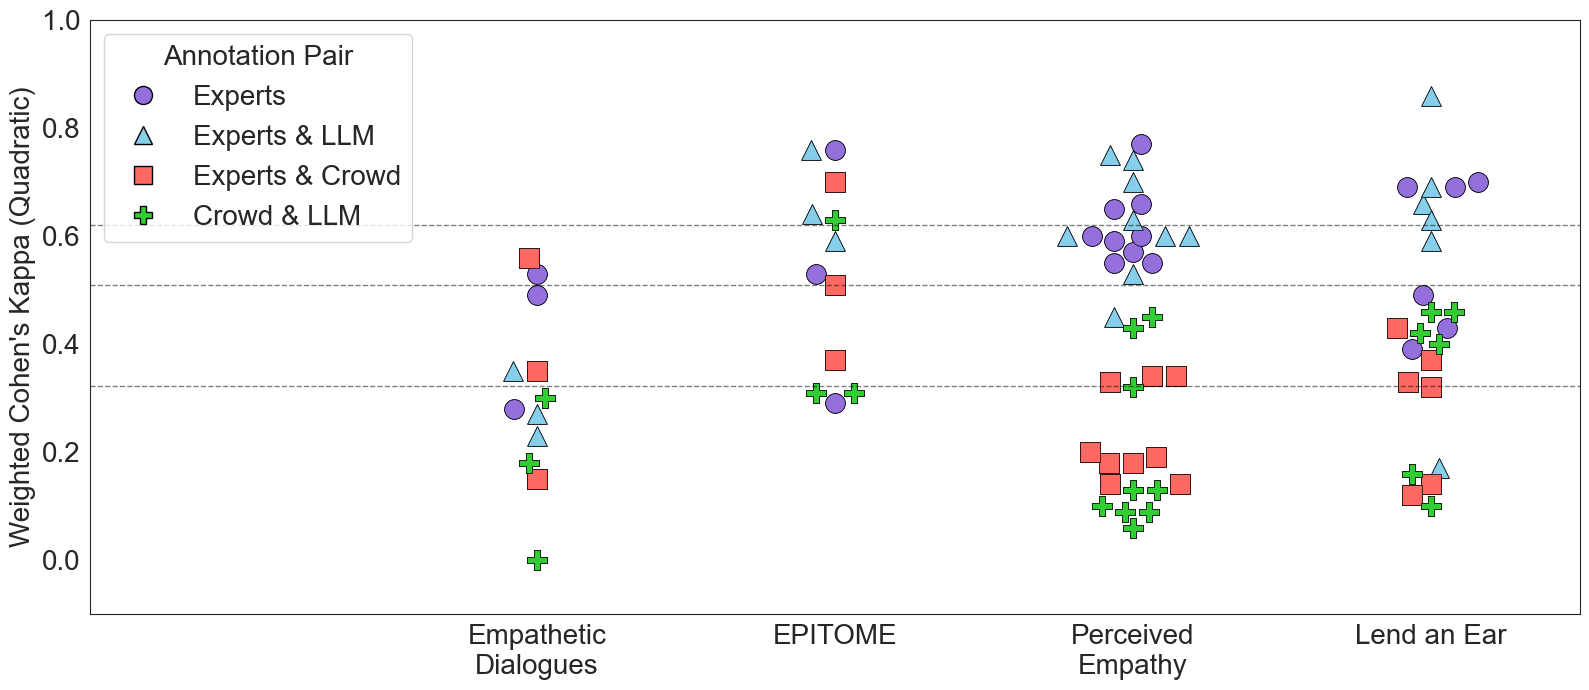

In [11]:
kappa = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")

percentiles = np.percentile(kappa["Weighted Cohen's Kappa"].values.astype(float), [25, 50, 75])
print("Weighted Cohen's Kappa percentiles (25th, 50th, 75th):", percentiles)
sns.set_style("white")

# First identify expert-to-expert comparisons
expert_pairs = ["('expert1', 'expert2')", "('expert2', 'expert3')", "('expert3', 'expert1')"]

# Create a new dataframe to hold the median expert values
expert_medians = kappa[kappa["Annotator Pair"].isin(expert_pairs)].copy()
expert_medians["Weighted Cohen's Kappa"] = expert_medians["Weighted Cohen's Kappa"].astype(float)

# Calculate median per dataset and dimension
expert_medians = expert_medians.groupby(["Dataset", "Dimension"]).agg({
    "Weighted Cohen's Kappa": "median"
}).reset_index()

# Set a single annotator pair for these median values
expert_medians["Annotator Pair"] = "Experts"

# Get the remaining non-expert comparisons
other_comparisons = kappa[
    ~kappa["Annotator Pair"].isin(expert_pairs) ][
    ["Dataset", "Dimension", "Annotator Pair", "Weighted Cohen's Kappa"]
]

# Define the label mapping for the remaining pairs
label_mapping = {
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "Crowd & LLM",
}

# Clean labels
other_comparisons["Annotator Pair"] = other_comparisons["Annotator Pair"].replace(label_mapping)
other_comparisons["Weighted Cohen's Kappa"] = other_comparisons["Weighted Cohen's Kappa"].astype(float)

# Combine the expert medians with other comparisons
plot_data = pd.concat([expert_medians, other_comparisons])

# Rest of visualization code remains the same
colors = {
    "Experts": "#9370DB",         # Purple
    "Experts & Crowd": "#FF6961", # Red
    "Experts & LLM": "#87CEEB",   # Light Blue
    "Crowd & LLM": "#32CD32"      # Green
}

marker_mapping = {"Experts": "o", "Experts & LLM": "^", "Experts & Crowd": "s", "Crowd & LLM": "P"}
hue_order = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "RPG"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Weighted Cohen's Kappa",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=13
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot each hue's points with the correct marker and color
for hue in hue_order:
    # add some jitter to the points
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=200,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )

plt.axhline(y=percentiles[0], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[1], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[2], color='black', linestyle='--', linewidth=1, alpha=0.5)


# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=20
)
ax.set_yticklabels(
    ["-0.1", "0.0", "0.2", "0.4",  "0.6",  "0.8", "1.0"],
    fontsize=20
)
plt.xlabel("")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=20)

legend_order = ["Experts", "Experts & LLM", "Experts & Crowd", "Crowd & LLM"]
for hue in legend_order:
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=200,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )
# Handle legend to avoid duplicates
legend_handles = [
    mlines.Line2D([], [], color=colors[hue], marker=marker_mapping[hue], linestyle='None',
                  markersize=13, label=hue, markerfacecolor=colors[hue], markeredgecolor='black')
    for hue in legend_order
]

ax.legend(
    handles=legend_handles,
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=20,
    title_fontsize=20
)
plt.xlim(-1.5, 3.5)
plt.ylim(-0.1, 1)
plt.tight_layout()

plt.savefig("figs/beeswarm_plot_quadratic_cohens_kappa.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
###BAR PLOT OF SPEARMAN CORRELATION; APPENDIX FIGURE 1
def plot_gbars_with_ci(df, filename, dimensions):
    # Define labels for different annotator pair comparisons
    comparison_labels = {
        "('expert1', 'expert2')": "E1 vs. E2",
        "('experts', 'crowd')": "E vs. Crowd",
        "('experts', 'llm')": "E vs. LLM",
        "('llm', 'crowd')": "LLM vs. Crowd",
    }

    # Initialize dictionaries to store correlation values and confidence intervals for each comparison
    correlations = {comp: [] for comp in comparison_labels}
    confidence_intervals = {comp: [] for comp in comparison_labels}

    # Iterate over each comparison to extract relevant data from the DataFrame
    for comp in comparison_labels:
        # Filter data for the current annotator pair
        comp_data = df[df["Annotator Pair"] == comp]
        for dim in dimensions:
            # Filter data for the current dimension
            dim_data = comp_data[comp_data["Dimension"] == dim]
            # Append the Spearman Correlation value to the list
            correlations[comp].append(dim_data["Spearman Correlation"].values[0])
            # Calculate and append the confidence interval error
            ci_lower = dim_data["Fisher CI Lower"].values[0]
            ci_upper = dim_data["Fisher CI Upper"].values[0]
            confidence_intervals[comp].append(
                (ci_upper - ci_lower) / 2
            )  # Error is half the CI range

    # Create a figure and axis for the bar plot
    fig, ax = plt.subplots(figsize=(26, 7))

    # Define x positions for the bars
    x = np.arange(len(comparison_labels))

    # Format dimension labels for better readability
    dimension_labels = [
        dim.replace("m_", "").replace("level_", "").replace("_", "\n").title()
        for dim in dimensions
    ]

    colors = [
        "#8B008B",
        "#FA8072",
        "#FFA500",
        "#FFD700",
        "#40E0D0",
        "#1E90FF",
        "#2E8B57",
        "#BA55D3",
        "#708090",
    ]

    width = 0.1
    n_dims = len(dimensions)

    offsets = np.linspace(-(n_dims - 1) / 2.0, (n_dims - 1) / 2.0, n_dims)
    offsets *= width

    for i, dim in enumerate(dimensions):
        dim_correlation = [correlations[comp][i] for comp in comparison_labels]
        dim_ci = [confidence_intervals[comp][i] for comp in comparison_labels]

        # Plot the bar for the current dimension
        ax.bar(
            x + offsets[i],
            dim_correlation,
            width,
            yerr=dim_ci,
            label=dimension_labels[i],
            color=colors[i % len(colors)],
            capsize=5,  # Add caps to the error bars
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        ["E1 vs E2", "E vs Crowd", "E vs LLM", "LLM vs Crowd"], fontsize=16
    )
    ax.set_ylabel("Spearman Correlation", fontsize=20)
    ax.set_ylim(-0.5, 1.0)  # Set y-axis limits
    plt.xlim(-1, len(comparison_labels))  # Set x-axis limits

    ax.tick_params(axis="x", which="major", length=8, width=2, labelsize=20)
    ax.tick_params(axis="y", which="major", length=8, width=2, labelsize=20)

    # Add a legend to the plot
    ax.legend(
        loc="upper left",
        frameon=True,
        fontsize=20,
        title="Dimensions",
        title_fontsize=20,
    )

    plt.tight_layout()
    plt.ylim(-0.35, 1.0)
    plt.savefig(filename, dpi=300)
    plt.show()


df = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")
df["Annotator Pair"] = df["Annotator Pair"].astype(str)

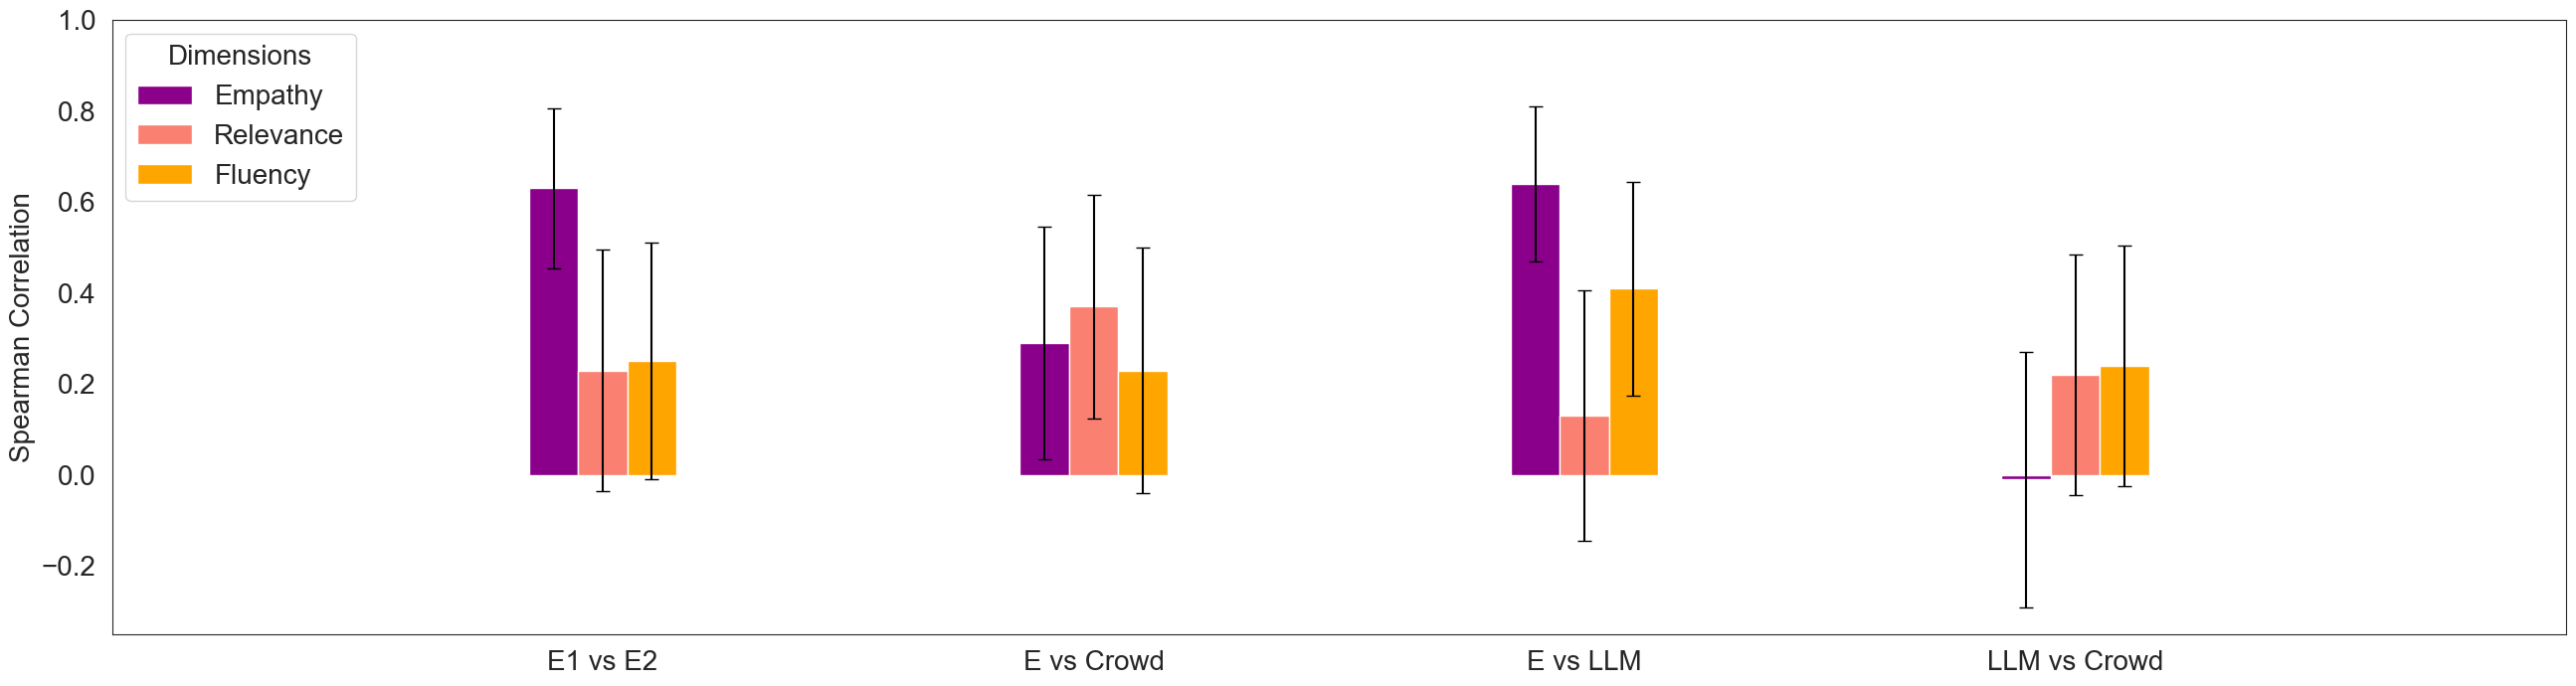

In [13]:
dimensions = ["empathy", "relevance", "fluency"]
plot_gbars_with_ci(df, "figs/empatheticdialogues_spearman.png", dimensions)

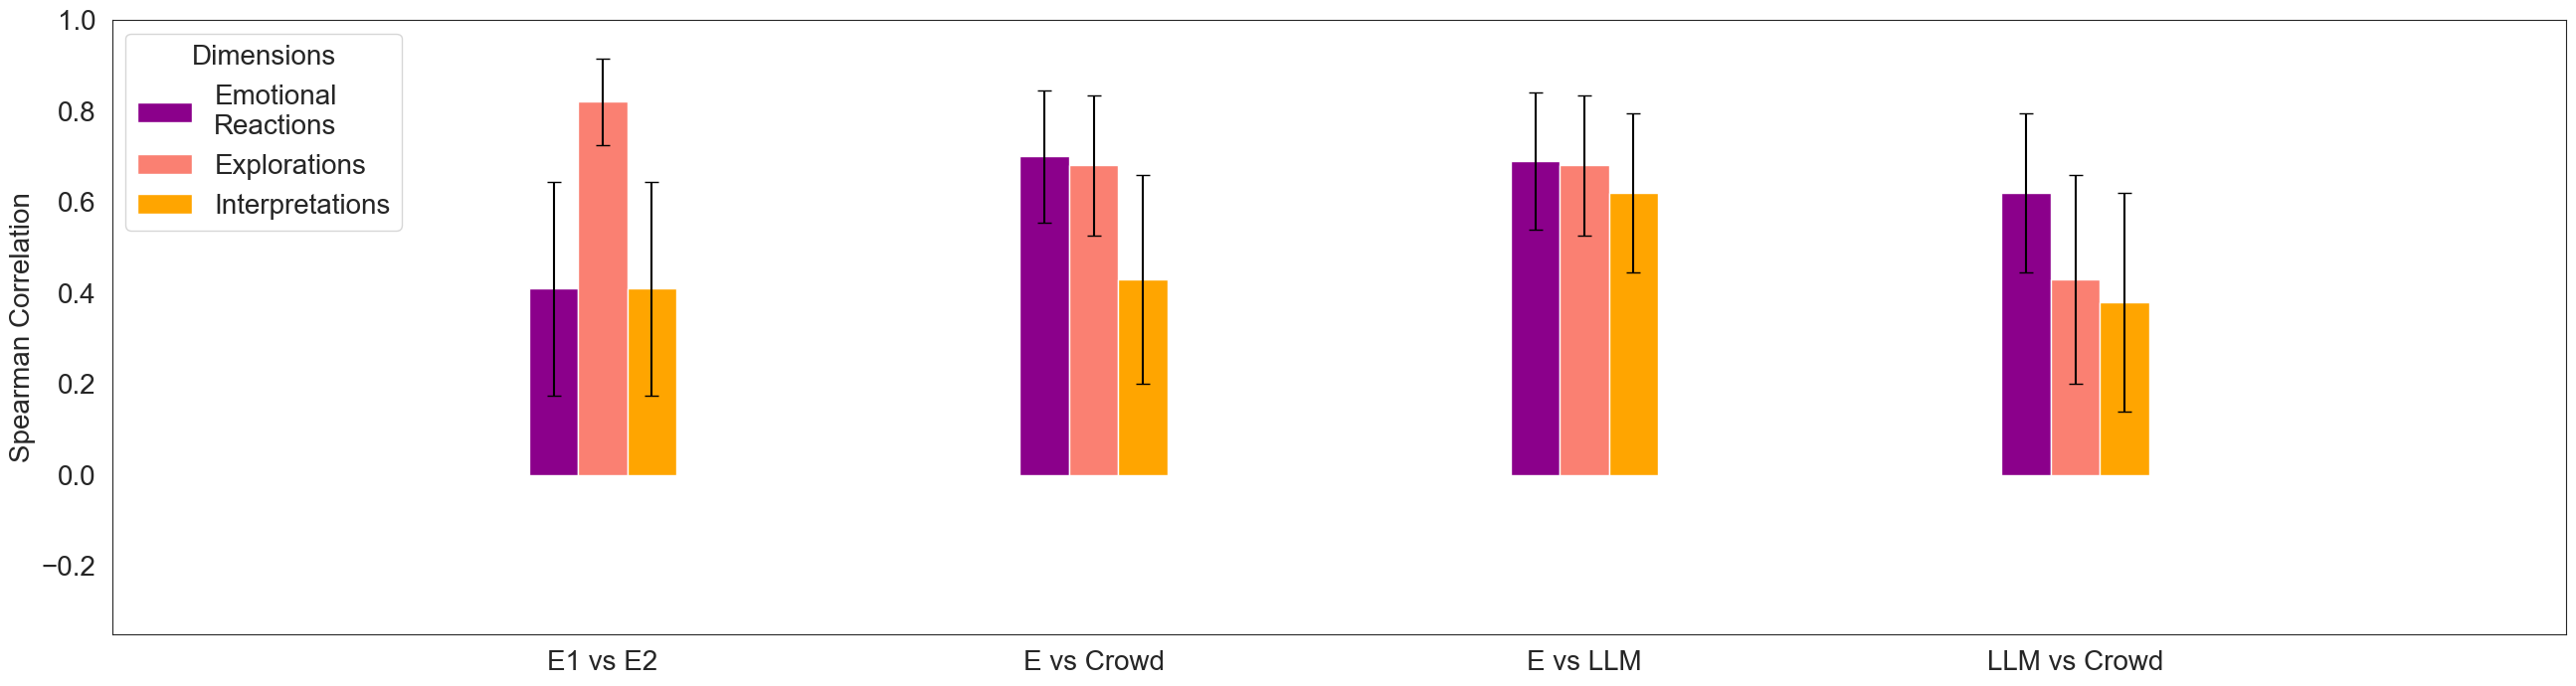

In [14]:
dimensions = [
    "level_emotional_reactions",
    "level_explorations",
    "level_interpretations",
]
plot_gbars_with_ci(df, "figs/epitome_spearman.png", dimensions)

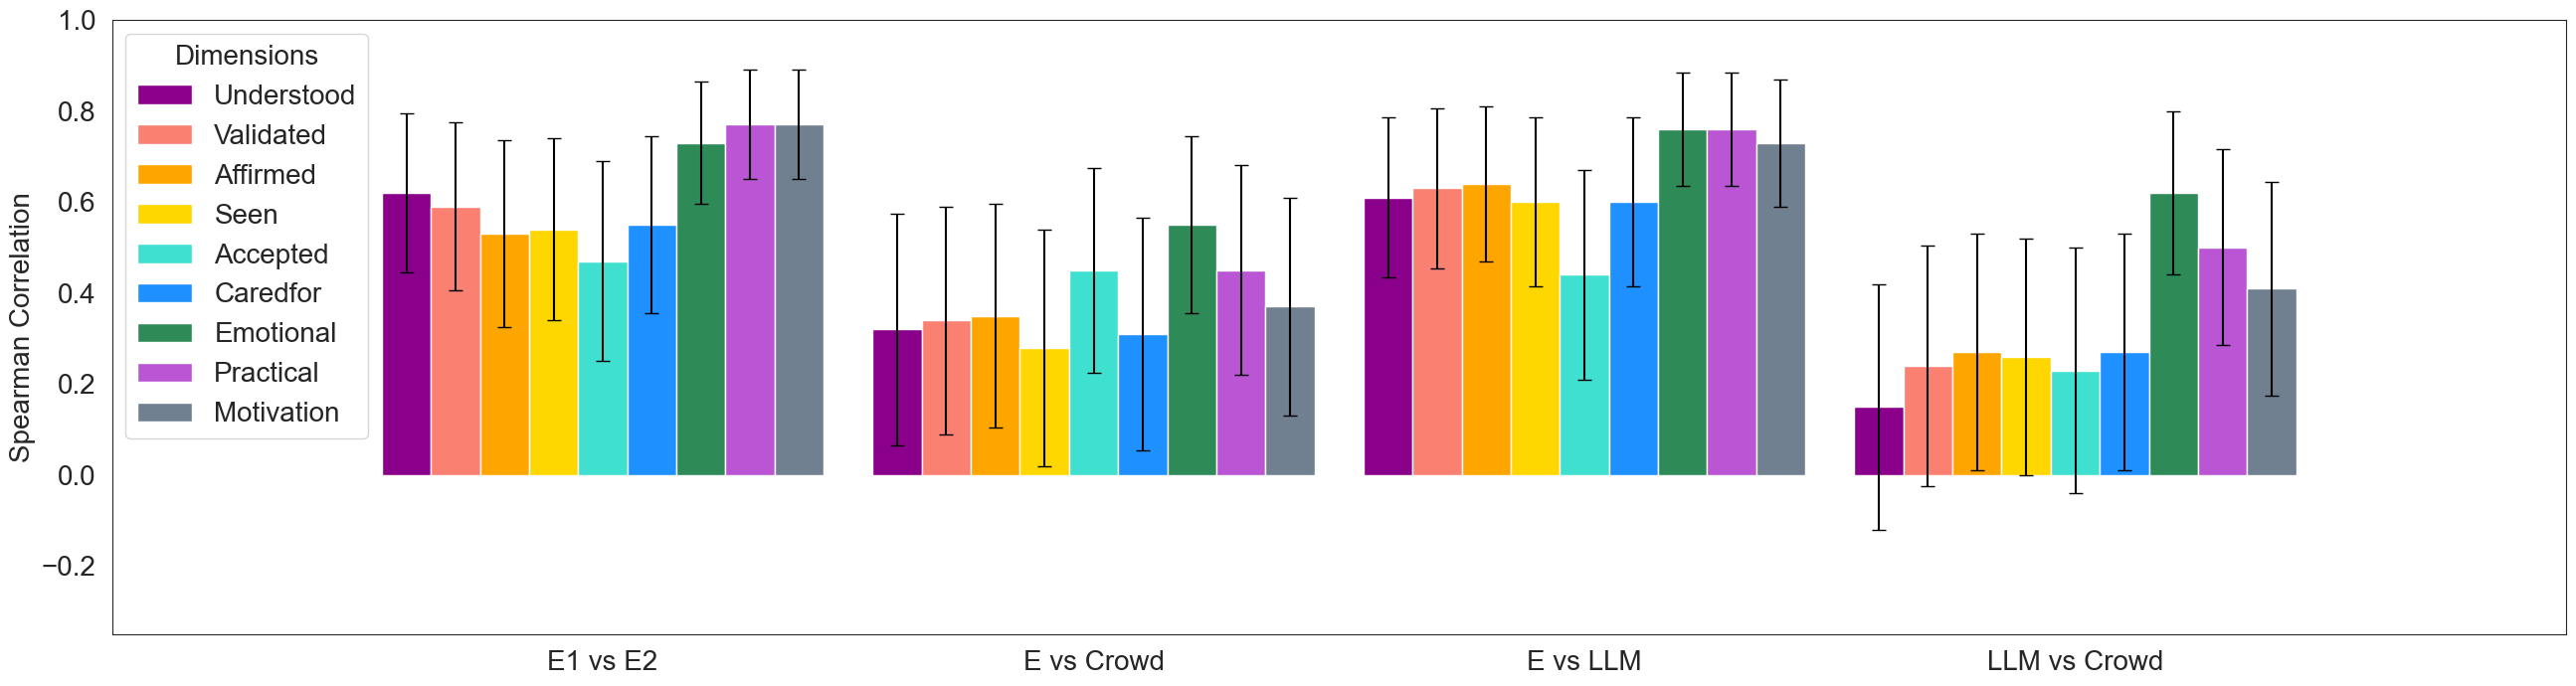

In [15]:
dimensions = [
    "m_understood",
    "m_validated",
    "m_affirmed",
    "m_seen",
    "m_accepted",
    "m_caredfor",
    "m_emotional",
    "m_practical",
    "m_motivation",
]
plot_gbars_with_ci(df, "figs/perceived_empathy_spearman.png", dimensions)

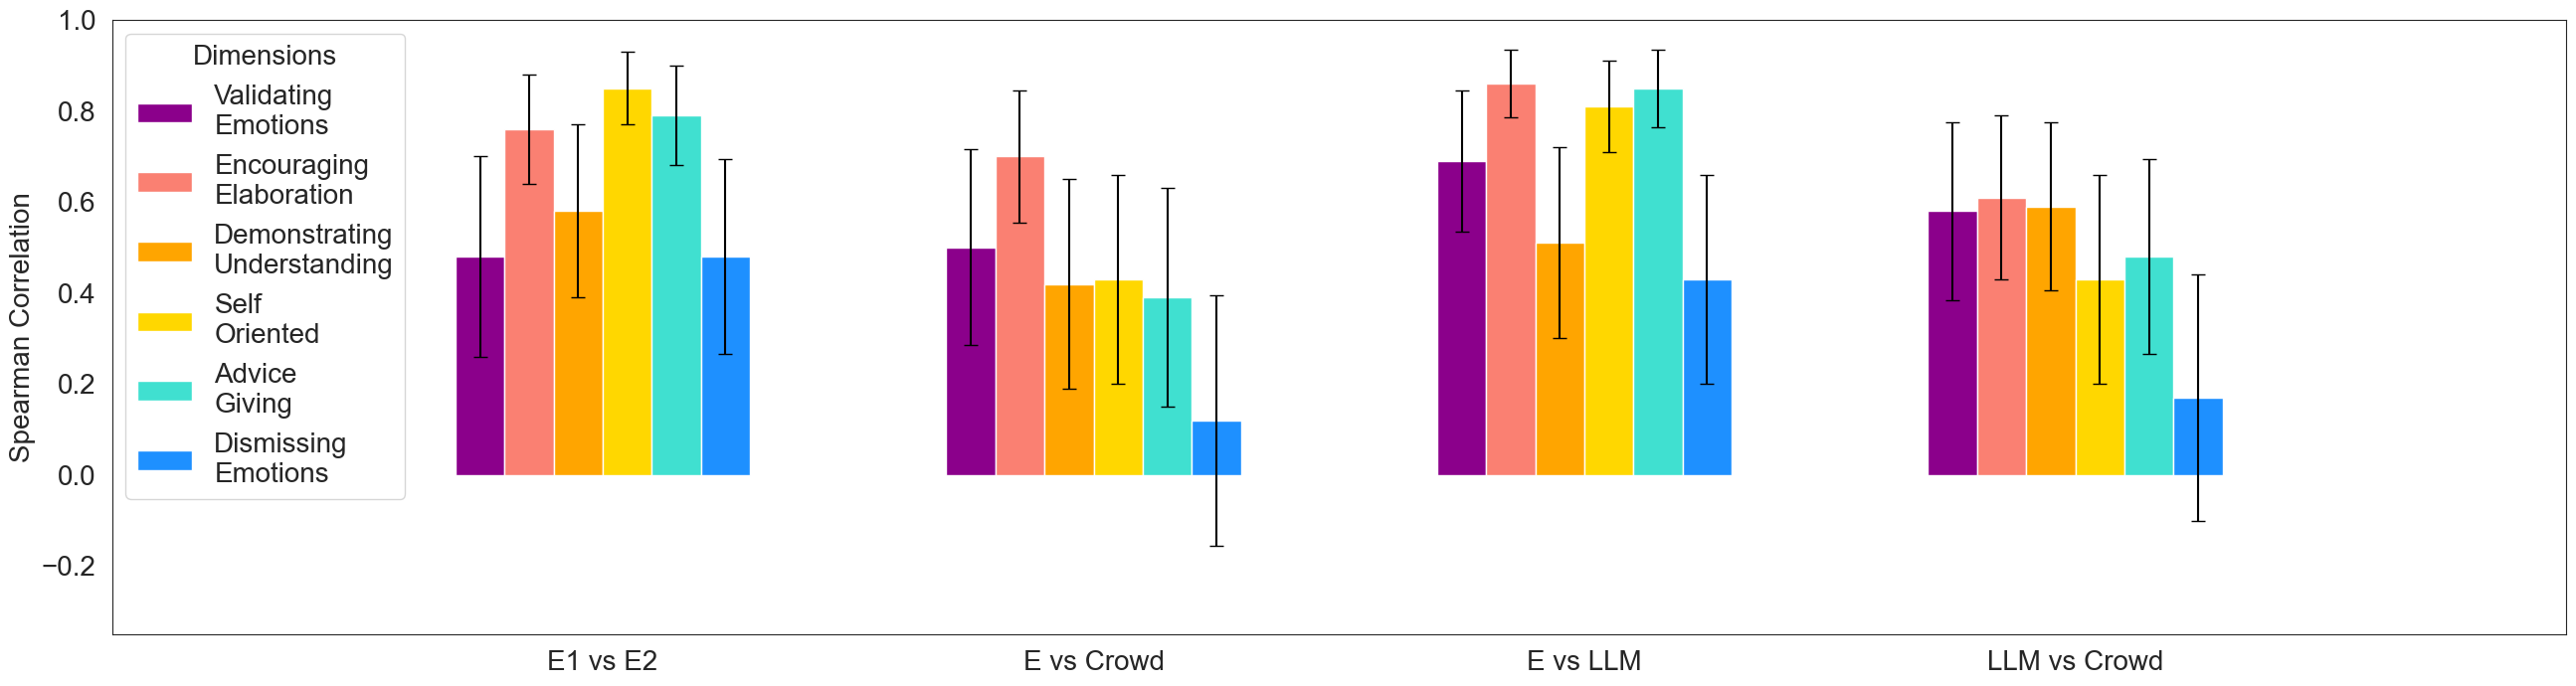

In [16]:
dimensions = [
    "validating_emotions",
    "encouraging_elaboration",
    "demonstrating_understanding",
    "self_oriented",
    "advice_giving",
    "dismissing_emotions",
]

plot_gbars_with_ci(df, "figs/lendanear_spearman.png", dimensions)

In [18]:
###BAR PLOT OF SPEARMAN CORRELATION; APPENDIX FIGURE 1
def plot_gbars_with_ci(df, filename, dimensions):
    # Define labels for different annotator pair comparisons
    comparison_labels = {
        "('expert1', 'expert2')": "E1 vs. E2",
        "('experts', 'crowd')": "E vs. Crowd",
        "('experts', 'llm')": "E vs. LLM",
        "('llm', 'crowd')": "LLM vs. Crowd",
    }

    # Initialize dictionaries to store correlation values and confidence intervals for each comparison
    correlations = {comp: [] for comp in comparison_labels}
    confidence_intervals = {comp: [] for comp in comparison_labels}

    # Iterate over each comparison to extract relevant data from the DataFrame
    for comp in comparison_labels:
        # Filter data for the current annotator pair
        comp_data = df[df["Annotator Pair"] == comp]
        for dim in dimensions:
            # Filter data for the current dimension
            dim_data = comp_data[comp_data["Dimension"] == dim]
            # Append the Spearman Correlation value to the list
            correlations[comp].append(dim_data["Spearman Correlation"].values[0])
            # Calculate and append the confidence interval error
            ci_lower = dim_data["Fisher CI Lower"].values[0]
            ci_upper = dim_data["Fisher CI Upper"].values[0]
            confidence_intervals[comp].append(
                (ci_upper - ci_lower) / 2
            )  # Error is half the CI range

    # Create a figure and axis for the bar plot
    fig, ax = plt.subplots(figsize=(26, 7))

    # Define x positions for the bars
    x = np.arange(len(comparison_labels))

    # Format dimension labels for better readability
    dimension_labels = [
        dim.replace("m_", "").replace("level_", "").replace("_", "\n").title()
        for dim in dimensions
    ]

    colors = [
        "#8B008B",
        "#FA8072",
        "#FFA500",
        "#FFD700",
        "#40E0D0",
        "#1E90FF",
        "#2E8B57",
        "#BA55D3",
        "#708090",
    ]

    width = 0.1
    n_dims = len(dimensions)

    offsets = np.linspace(-(n_dims - 1) / 2.0, (n_dims - 1) / 2.0, n_dims)
    offsets *= width

    for i, dim in enumerate(dimensions):
        dim_correlation = [correlations[comp][i] for comp in comparison_labels]
        dim_ci = [confidence_intervals[comp][i] for comp in comparison_labels]

        # Plot the bar for the current dimension
        ax.bar(
            x + offsets[i],
            dim_correlation,
            width,
            yerr=dim_ci,
            label=dimension_labels[i],
            color=colors[i % len(colors)],
            capsize=5,  # Add caps to the error bars
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        ["E1 vs E2", "E vs Crowd", "E vs LLM", "LLM vs Crowd"], fontsize=16
    )
    ax.set_ylabel("Spearman Correlation", fontsize=20)
    ax.set_ylim(-0.5, 1.0)  # Set y-axis limits
    plt.xlim(-1, len(comparison_labels))  # Set x-axis limits

    ax.tick_params(axis="x", which="major", length=8, width=2, labelsize=20)
    ax.tick_params(axis="y", which="major", length=8, width=2, labelsize=20)

    # Add a legend to the plot
    ax.legend(
        loc="upper left",
        frameon=True,
        fontsize=20,
        title="Dimensions",
        title_fontsize=20,
    )

    plt.tight_layout()
    plt.ylim(-0.35, 1.0)
    plt.savefig(filename, dpi=300)
    plt.show()


df = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")
df["Annotator Pair"] = df["Annotator Pair"].astype(str)

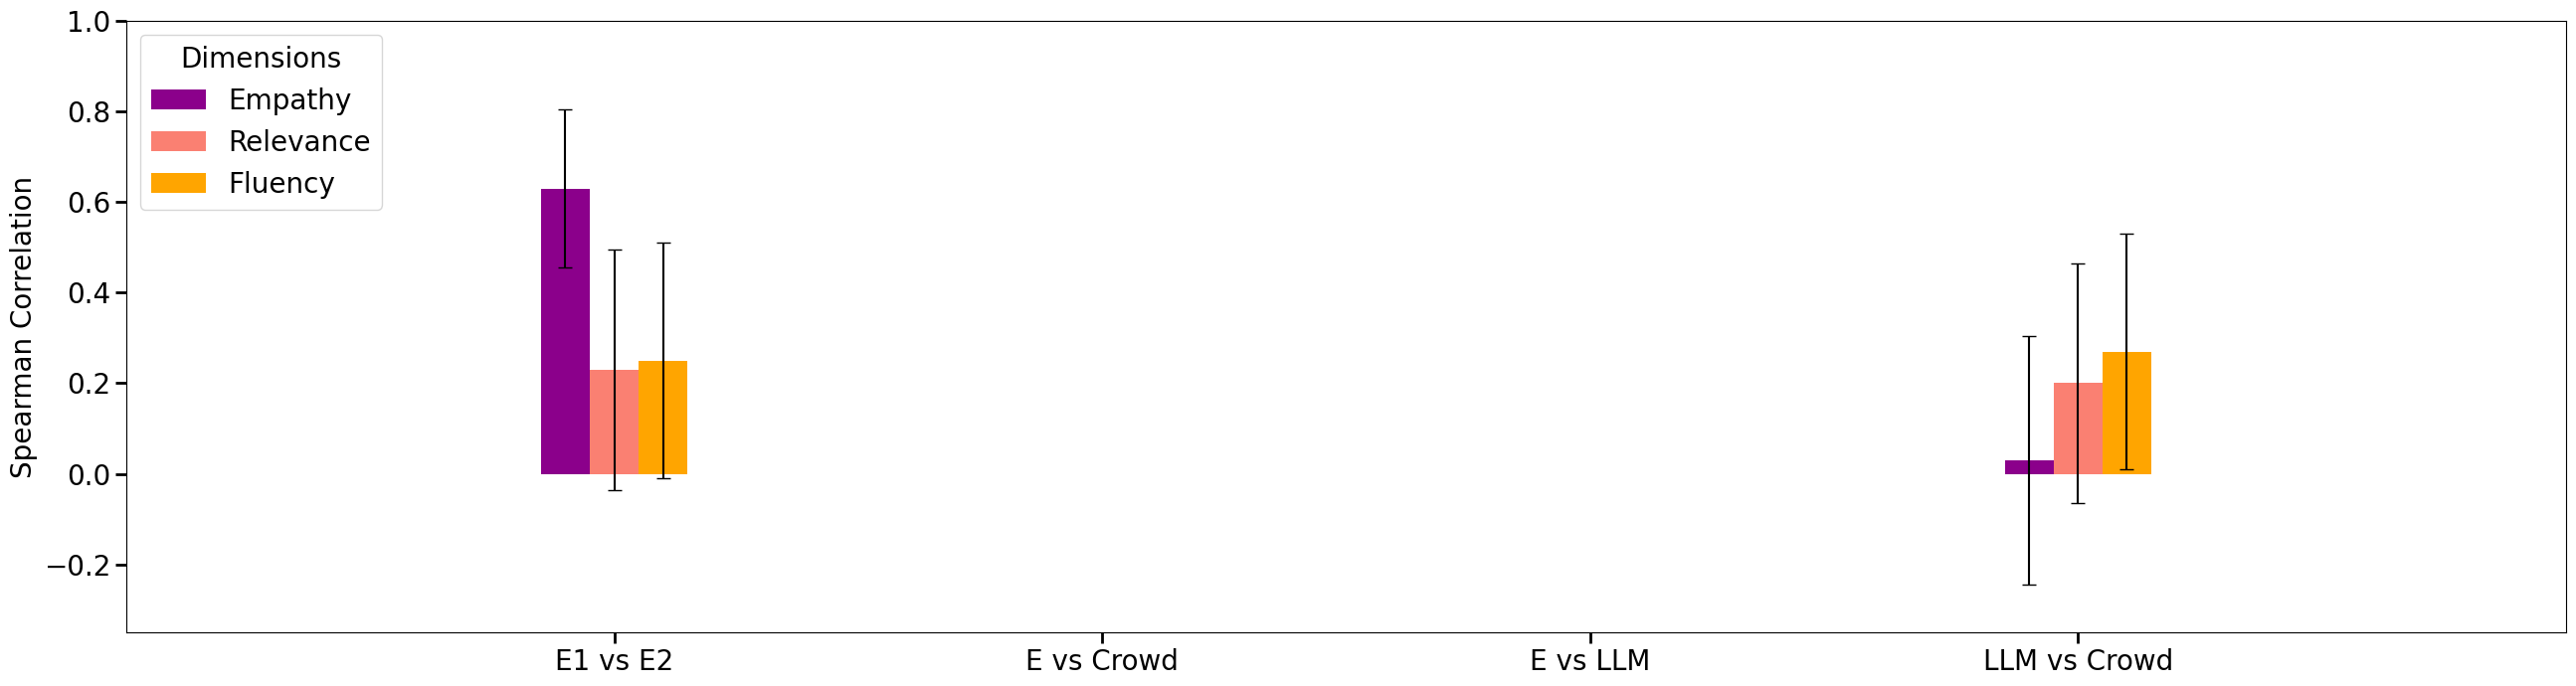

In [19]:
dimensions = ["empathy", "relevance", "fluency"]
plot_gbars_with_ci(df, "figs/empatheticdialogues_spearman.png", dimensions)

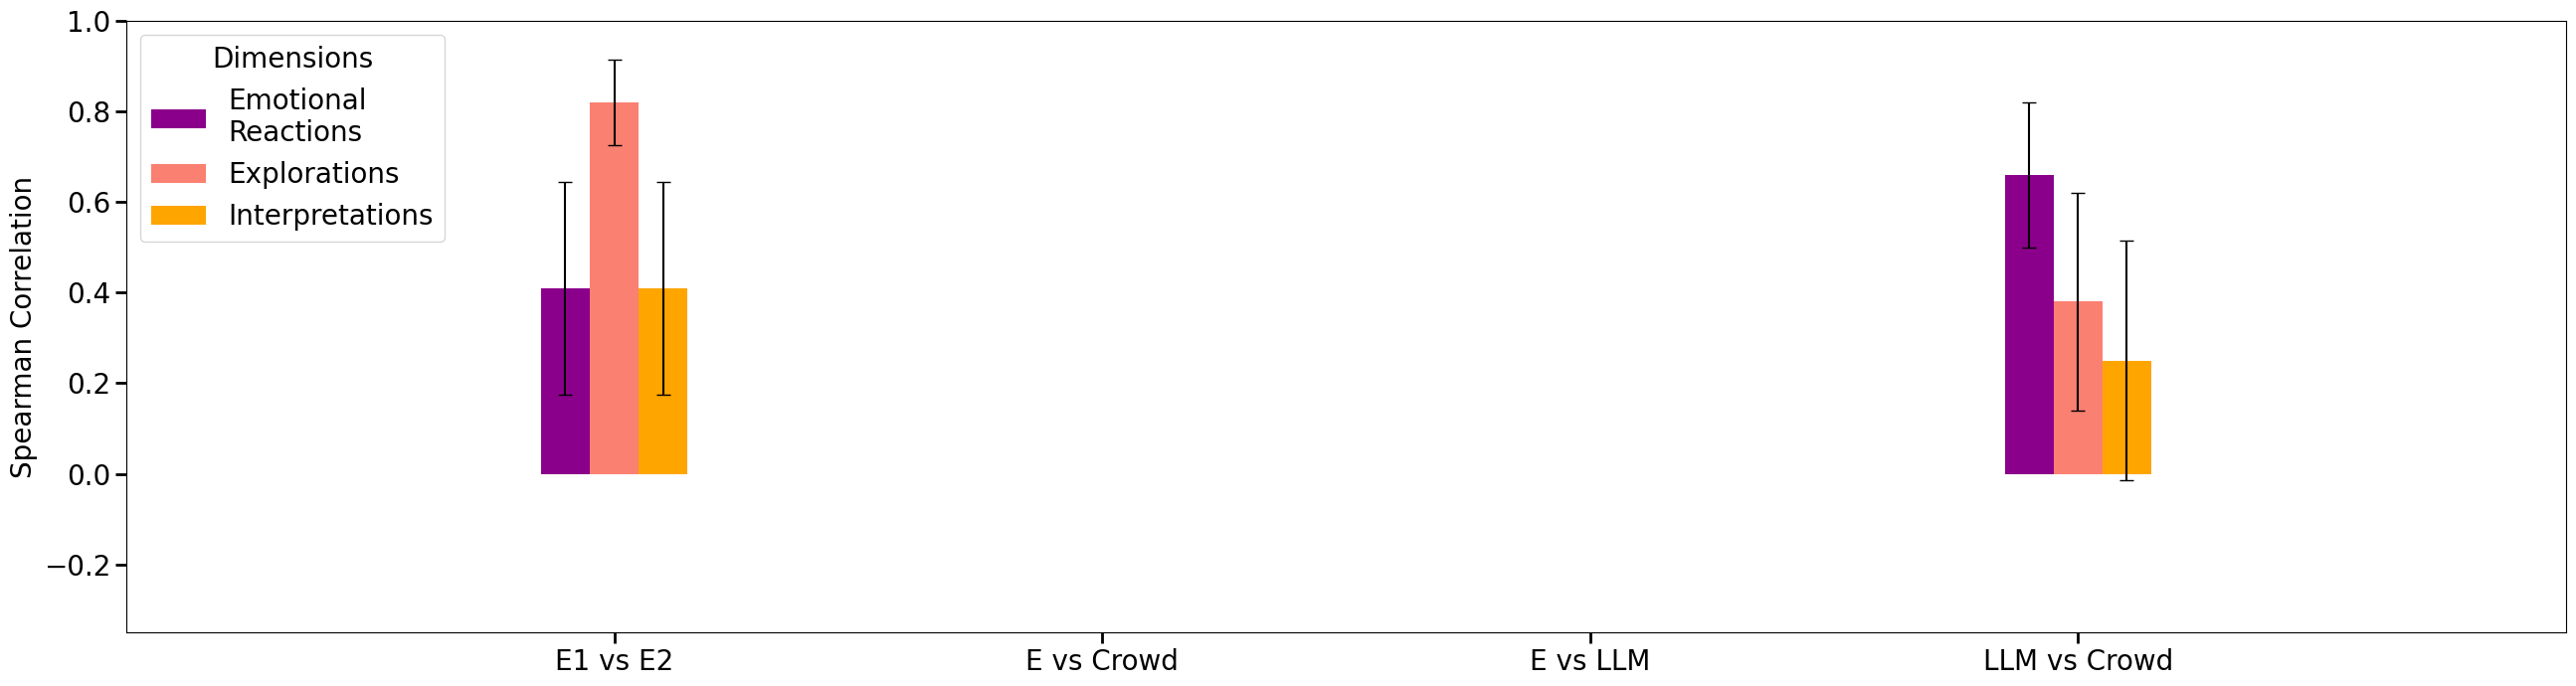

In [20]:
dimensions = [
    "level_emotional_reactions",
    "level_explorations",
    "level_interpretations",
]
plot_gbars_with_ci(df, "figs/epitome_spearman.png", dimensions)

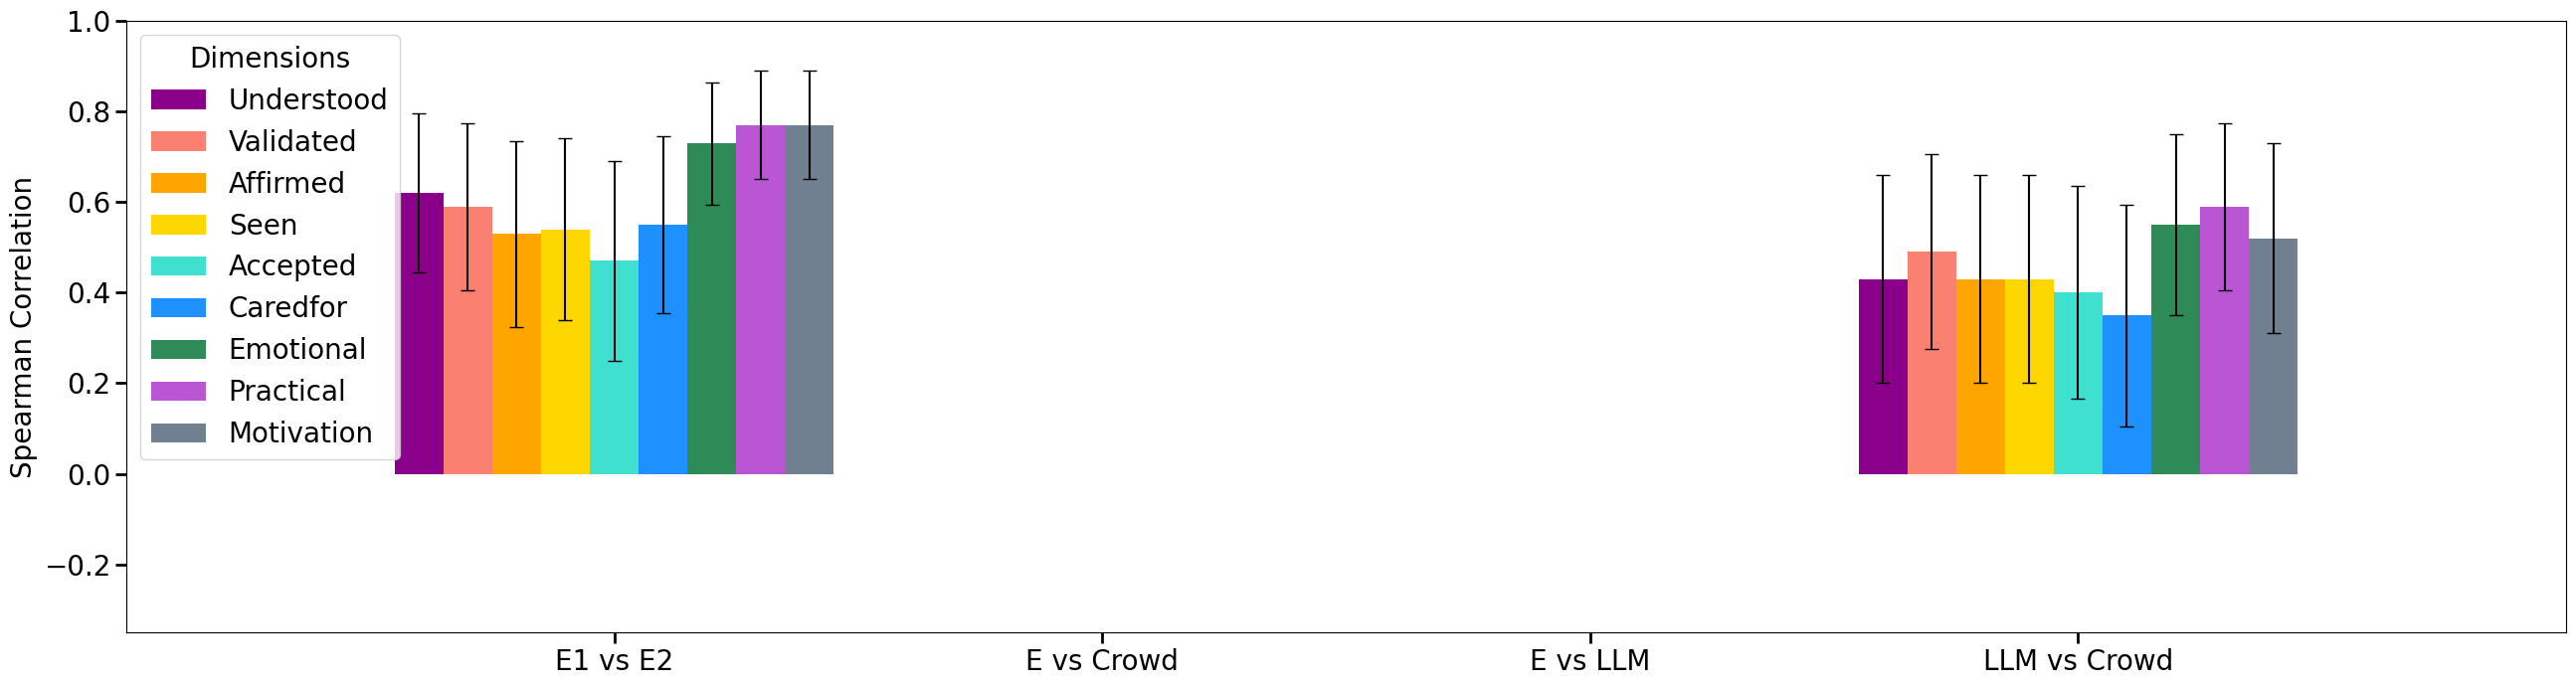

In [21]:
dimensions = [
    "m_understood",
    "m_validated",
    "m_affirmed",
    "m_seen",
    "m_accepted",
    "m_caredfor",
    "m_emotional",
    "m_practical",
    "m_motivation",
]
plot_gbars_with_ci(df, "figs/perceived_empathy_spearman.png", dimensions)

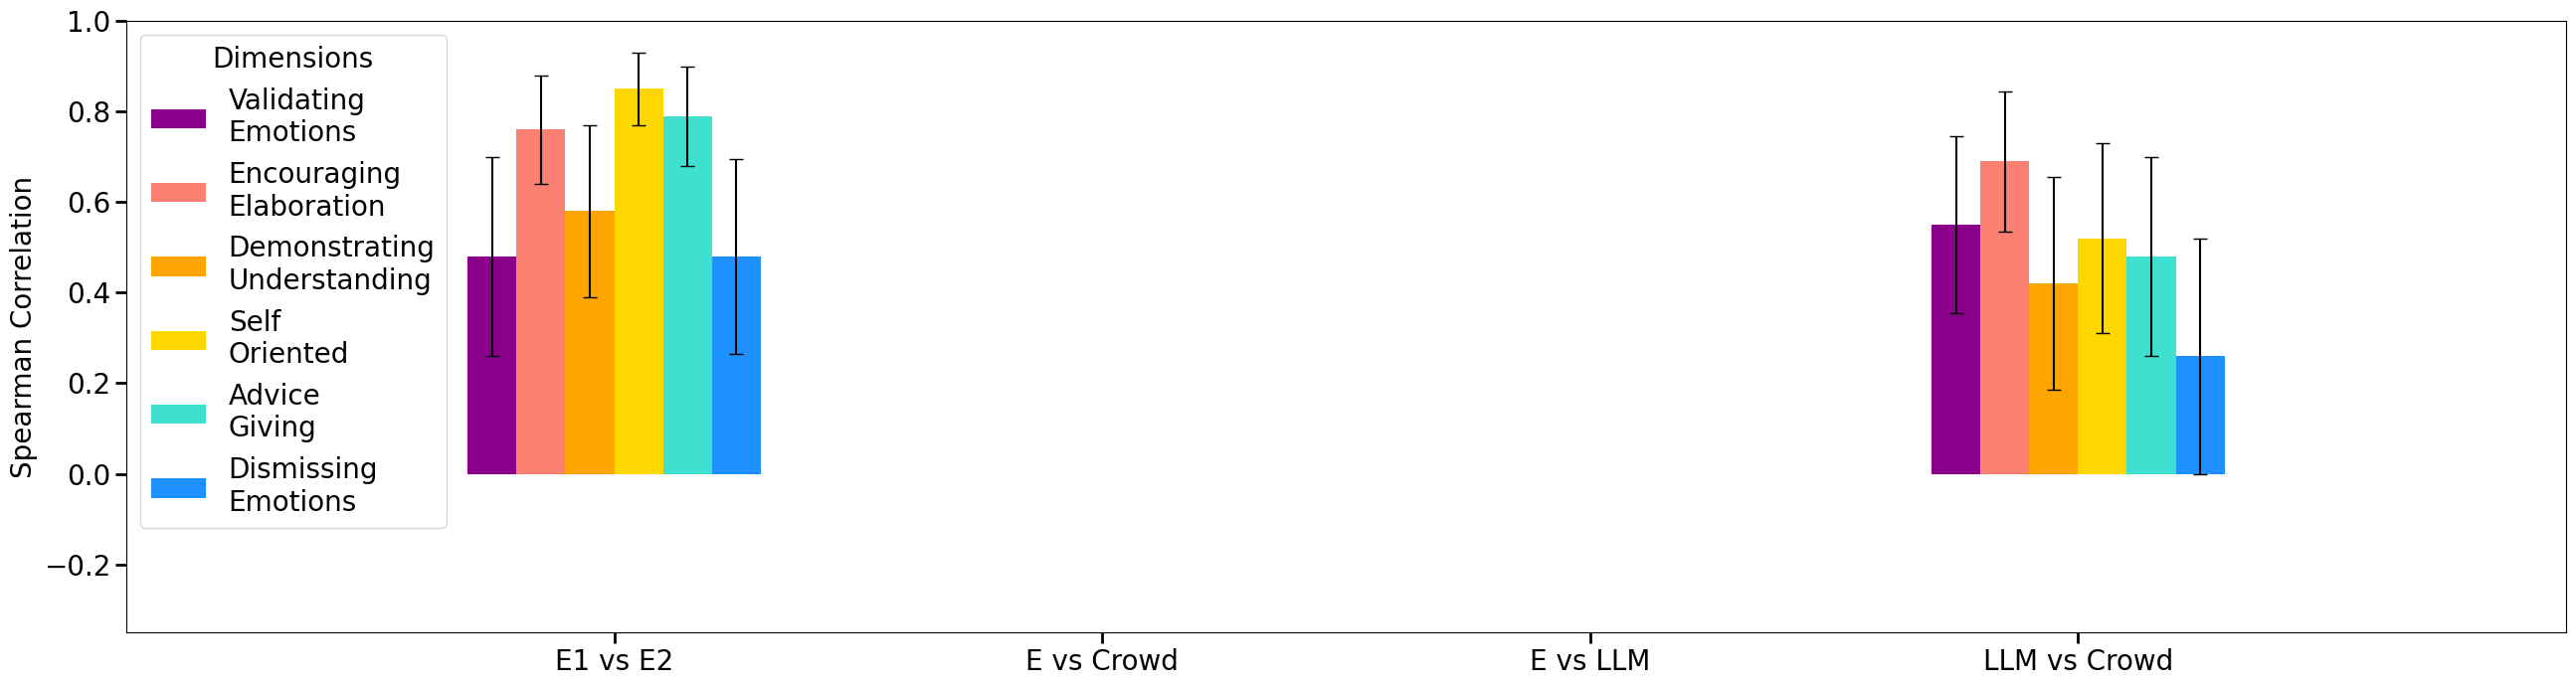

In [22]:
dimensions = [
    "validating_emotions",
    "encouraging_elaboration",
    "demonstrating_understanding",
    "self_oriented",
    "advice_giving",
    "dismissing_emotions",
]

plot_gbars_with_ci(df, "figs/lendanear_spearman.png", dimensions)

Applying dimension and pair mappings...
Expert data points: 63
Expert pairs found: ['Expert 1 & Expert 2' 'Expert 2 & Expert 3' 'Expert 3 & Expert 1']
Dimensions with stats: 21
Sample of stats data:
       Dimension      mean   min   max
0       Accepted  0.526667  0.43  0.58
1  Advice Giving  0.643333  0.54  0.70
2       Affirmed  0.580000  0.49  0.65
Dimensions with Expert agreement below 0.57: [0, 3, 4, 5, 6, 8, 11, 12, 15, 16, 19]


/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/1413857454.py:232: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles=legend_handles, loc='upper left', fontsize=18)


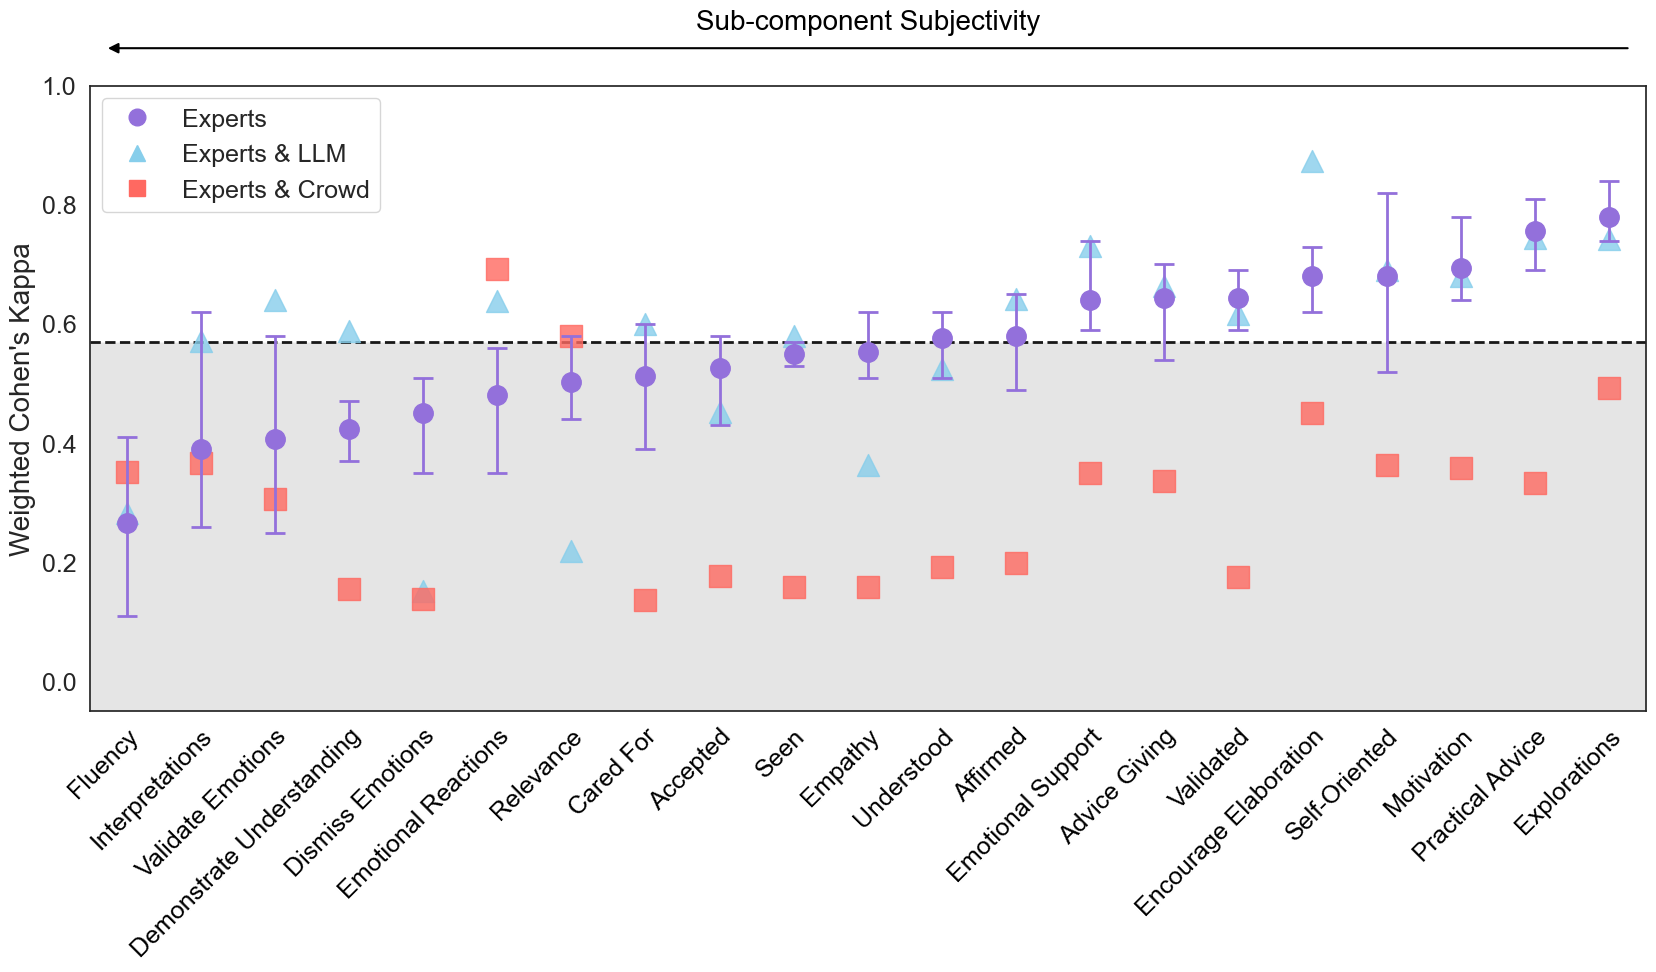

In [17]:
df = pd.read_csv("data/table_3_kappa.csv")

# --- Apply Mappings if necessary ---
# Check if any dimension name is in lowercase (heuristic for needing mapping)
if any(dim.islower() for dim in df['Dimension'].unique()):
    print("Applying dimension and pair mappings...")
    dimension_map = {
        'relevance': 'Relevance', 'fluency': 'Fluency', 'level_interpretations': 'Interpretations',
        'level_emotional_reactions': 'Emotional Reactions',
        'm_accepted': 'Accepted', 'validating_emotions': 'Validate Emotions',
        'dismissing_emotions': 'Dismiss Emotions', 'm_affirmed': 'Affirmed',
        'm_seen': 'Seen', 'm_caredfor': 'Cared For',
        'demonstrating_understanding': 'Demonstrate Understanding', 'm_validated': 'Validated',
        'm_understood': 'Understood', 'empathy': 'Empathy', 'm_emotional': 'Emotional Support',
        'encouraging_elaboration': 'Encourage Elaboration', 'm_motivation': 'Motivation',
        'm_practical': 'Practical Advice', 'advice_giving': 'Advice Giving',
        'level_explorations': 'Explorations', 'self_oriented': 'Self-Oriented'
    }
    # Add any missing dimensions from the dataframe to the map with their original name capitalized
    for dim in df['Dimension'].unique():
        if dim not in dimension_map and dim.lower() == dim:
             dimension_map[dim] = dim.capitalize() # Simple capitalization if specific map missing

    df['Dimension'] = df['Dimension'].replace(dimension_map)

    pair_map = {
        "('expert1', 'expert2')": "Expert 1 & Expert 2",
        "('expert2', 'expert3')": "Expert 2 & Expert 3",
        "('expert3', 'expert1')": "Expert 3 & Expert 1",
        "('experts', 'llm')": "Experts & LLM",
        "('experts', 'crowd')": "Experts & Crowd",
        "('llm', 'crowd')": "LLM & Crowd"
    }
    df['Annotator Pair'] = df['Annotator Pair'].replace(pair_map)
else:
    print("Skipping mappings, dimension names seem appropriately formatted.")

# --- Define Parameters ---
pairs_to_plot = ["Experts & LLM", "Experts & Crowd"]
expert_pairs = ["Expert 1 & Expert 2", "Expert 2 & Expert 3", "Expert 3 & Expert 1"]
median_kappa = df[(df['Annotator Pair'] == "Expert 1 & Expert 2") | (df['Annotator Pair'] == "Expert 2 & Expert 3") | (df['Annotator Pair'] == "Expert 3 & Expert 1")]["Weighted Cohen's Kappa"].mean()
# median of all expert pairs for each dimension
experts_kappa = df[df['Annotator Pair'].isin(expert_pairs)].groupby('Dimension')['Weighted Cohen\'s Kappa'].mean().reset_index()
max_experts_kappa = df[df['Annotator Pair'].isin(expert_pairs)].groupby('Dimension')['Weighted Cohen\'s Kappa'].max().reset_index()
marker_map = {"Experts": "o", "Experts & LLM": "^", "Experts & Crowd": "s"}
color_map = {
    "Experts & Crowd": "#FF6961",      # Red
    "Experts & LLM": "#87CEEB",        # Light Blue
    "Experts": "#9370DB"               # Purple for expert median
}
correlation_threshold = 0.57  # Your reliability threshold
gray_color = '#D3D3D3'  # Light gray

# --- Calculate Rank based on ranking of experts_kappa
rank_calc_df = experts_kappa.sort_values('Weighted Cohen\'s Kappa', ascending=False)
rank_calc_df['rank'] = rank_calc_df.index + 1

# --- Create Plot ---
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(19, 10))


# --- MODIFICATION: Rank ascending=True for low to high reliability ---
rank_calc_df['rank'] = rank_calc_df['Weighted Cohen\'s Kappa'].rank(method='first', ascending=True).astype(int)
# Replace -inf with NaN again for plotting or other calculations if needed
rank_calc_df['Weighted Cohen\'s Kappa'] = rank_calc_df['Weighted Cohen\'s Kappa'].replace(-np.inf, np.nan)

# Sort the ranking dataframe by the new rank (lowest rank first)
rank_calc_df = rank_calc_df.sort_values('rank')

# Merge the rank back into the main dataframe
df = df.merge(rank_calc_df[['Dimension', 'rank']], on='Dimension', how='left')

# Sort the main dataframe by this rank to ensure correct processing order
df = df.sort_values('rank', ascending=True)

# --- Horizontal Plot Setup ---
x_order = rank_calc_df['Dimension'].unique()  # Dimensions ordered by ASCENDING rank
x_values_map = {dim: i for i, dim in enumerate(x_order)}  # Map dimension to horizontal position (0 to N-1)
num_dimensions = len(x_order)

# --- Calculate Expert Statistics ---
# Get data for all expert pairs
expert_data = df[df['Annotator Pair'].isin(expert_pairs)].copy()

# Debugging - check if we have expert data
print(f"Expert data points: {len(expert_data)}")
print(f"Expert pairs found: {expert_data['Annotator Pair'].unique()}")

# Force conversion to numeric for the kappa values
expert_data['Weighted Cohen\'s Kappa'] = pd.to_numeric(expert_data['Weighted Cohen\'s Kappa'], errors='coerce')

# Group by dimension and calculate stats
expert_stats = expert_data.groupby('Dimension')['Weighted Cohen\'s Kappa'].agg(['mean', 'min', 'max']).reset_index()

# Check if calculations worked
print(f"Dimensions with stats: {len(expert_stats)}")
print("Sample of stats data:")
print(expert_stats.head(3))

# Map expert stats to x positions
expert_stats['x_pos'] = expert_stats['Dimension'].map(x_values_map)

experts_kappa['Weighted Cohen\'s Kappa'] = pd.to_numeric(experts_kappa['Weighted Cohen\'s Kappa'], errors='coerce')
valid_expert_kappa = experts_kappa.dropna()
low_expert_agreement_dims = valid_expert_kappa[valid_expert_kappa['Weighted Cohen\'s Kappa'] <= correlation_threshold].index.tolist()
print(f"Dimensions with Expert agreement below {correlation_threshold}: {low_expert_agreement_dims}")

# --- Get data for other comparison pairs ---
plot_df = df[df['Annotator Pair'].isin(pairs_to_plot)].copy()

# --- Plot Backgrounds (Layered) ---
# Define plot limits for kappa axis (Y)
all_y_values = df['Weighted Cohen\'s Kappa'].dropna()
if not all_y_values.empty:
    data_ymin = all_y_values.min(); data_ymax = all_y_values.max()
    plot_ymin = min(data_ymin, 0) - 0.05
    plot_ymax = max(data_ymax, correlation_threshold) + 0.05
else:
    plot_ymin, plot_ymax = -0.1, 1.25

# Layer 1: Horizontal shading for kappa ranges
ax.axhspan(plot_ymin, correlation_threshold, facecolor='gray', alpha=0.2, zorder=0)  # Below threshold

# Layer 2: Vertical gray shading for low expert agreement columns (commented out)
# for dim_name in low_expert_agreement_dims:
#     if dim_name in x_values_map:
#         x_pos = x_values_map[dim_name]
#         ax.axvspan(x_pos - 0.5, x_pos + 0.5, facecolor=gray_color, alpha=0.7, zorder=1, ymin=0, ymax=1)

# --- Plot Data Points ---
legend_handles = []

# Plot expert median with error bars (min/max range)
if not expert_stats.empty:
    # Calculate error bar values
    err_low = np.maximum(expert_stats['mean'] - expert_stats['min'], 0.02)  # Minimum 0.02 size
    err_high = np.maximum(expert_stats['max'] - expert_stats['mean'], 0.02)  # Minimum 0.02 size
    
    # Use a larger marker and ensure high zorder to be visible
    ax.errorbar(
        x=expert_stats['x_pos'],
        y=expert_stats['mean'],
        yerr=[err_low, err_high],
        fmt='o',
        color="#9370DB",  # Purple
        markersize=14,
        capsize=7,
        capthick=2,
        elinewidth=2,
        alpha=1.0,  # Full opacity
        zorder=10   # Higher zorder to appear on top
    )
    
    # Add expert median to legend
    legend_handles.append(mlines.Line2D([], [], color="#9370DB",
                                     marker='o', linestyle='None',
                                     markersize=12, label='Experts'))
else:
    print("No expert statistics available to plot")

# Plot other annotator pairs
for pair in pairs_to_plot:
    pair_data = plot_df[plot_df['Annotator Pair'] == pair].copy()
    if pair_data.empty: 
        continue

    # Map dimension to X position
    pair_data['x_pos'] = pair_data['Dimension'].map(x_values_map)
    current_marker = marker_map.get(pair, 'x')
    current_color = color_map.get(pair, 'grey')
    
    # Add vertical jitter to the points
    pair_data['y_jitter'] = pair_data['Weighted Cohen\'s Kappa'] + np.random.uniform(-0.02, 0.02, len(pair_data))
    
    ax.scatter(
        x=pair_data['x_pos'],               
        y=pair_data['y_jitter'],
        marker=current_marker,
        color=current_color,
        s=250,
        alpha=.8,
        zorder=2
    )

    legend_handles.append(mlines.Line2D([], [], color=current_color,
                                       marker=current_marker, linestyle='None',
                                       markersize=12, label=pair))

# --- Add Horizontal Threshold Line ---
threshold_line = ax.axhline(y=correlation_threshold, color='black', linestyle='--',
                           linewidth=2, alpha=0.9, zorder=1.5)
legend_handles.append(threshold_line)

# --- Set Ticks and Labels ---
ax.set_xticks(np.arange(len(x_order)))
ax.set_xticklabels(x_order,
                   rotation=45,
                   ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
ax.set_xlim(-0.5, num_dimensions - 0.5)

ax.set_ylabel("Weighted Cohen's Kappa", fontsize=20)
ax.set_xlabel("", fontsize=20)

# Set Y limits (kappa axis)
ax.set_ylim(plot_ymin, plot_ymax)

# --- Customize Appearance ---
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18, colors='black')

# --- Add Arrow and Labels (Horizontal - Reflecting Low to High Reliability) ---
arrow_y = 1.06
arrow_x_left = 0.01
arrow_x_right = 0.99

ax.annotate('',
            xy=(arrow_x_right, arrow_y), xytext=(arrow_x_left, arrow_y),
            arrowprops=dict(arrowstyle='<|-', lw=1.5, color='black', mutation_scale=15),
            xycoords='axes fraction', textcoords='axes fraction', zorder=5)

ax.text(0.5, arrow_y + 0.02, 'Sub-component Subjectivity', fontsize=20,
        ha='center', va='bottom', color='black', transform=ax.transAxes)

# Set explicit Y ticks
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)])

# Add legend
ax.legend(handles=legend_handles, loc='upper left', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust rect to prevent legend cutoff
plt.savefig('figs/reliability_continuum_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

<>:307: SyntaxWarning: invalid escape sequence '\k'
<>:307: SyntaxWarning: invalid escape sequence '\k'
/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/3739689586.py:307: SyntaxWarning: invalid escape sequence '\k'
  ax_kappa.set_ylabel("$\kappa_w$", fontsize=18)
/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/3739689586.py:454: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # rect=[left, bottom, right, top]


Final combined plot saved to: combined_plots_final/combined_dataset_comparison_final_1x2_epitome_perceived_range.png


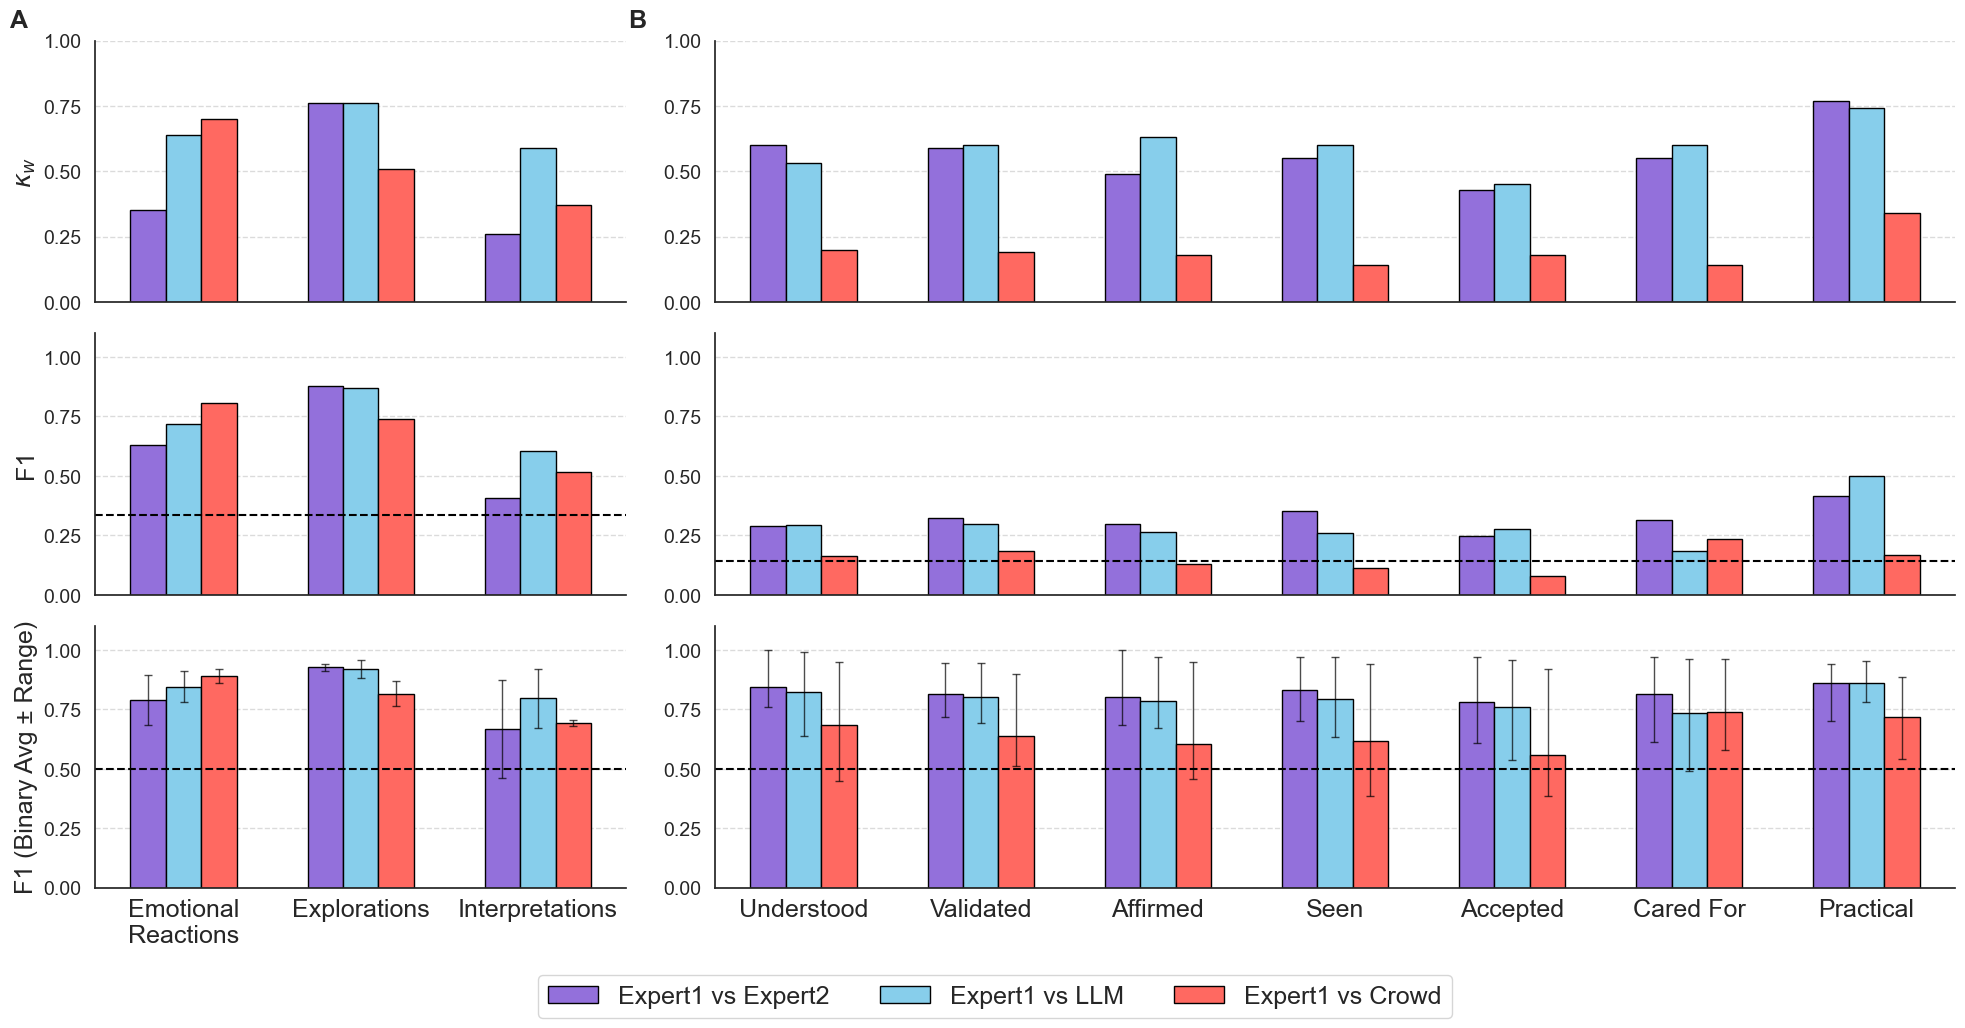

In [18]:
df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")
# Load kappa_df directly; script will error if file not found
kappa_df = pd.read_csv("data/table_3_kappa.csv")
kappa_df['Dataset'] = kappa_df['Dataset'].str.strip().str.lower()
kappa_df['Dimension'] = kappa_df['Dimension'].str.strip()
kappa_df['Annotator Pair'] = kappa_df['Annotator Pair'].str.strip()

datasets = {
    'epitome': {
        'dimensions': ['level_emotional_reactions', 'level_explorations', 'level_interpretations'],
        'kappa_label': 'epitome',
        'id_column': 'epitome_conversation_id'
    },
    'rpg': {
        'dimensions': ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'self_oriented', 'advice_giving', 'dismissing_emotions'],
        'kappa_label': 'rpg',
        'id_column': 'rpg_conversation_id'
    },
    'empatheticdialogues': {
        'dimensions': ['empathy', 'fluency', 'relevance'],
        'kappa_label': 'empathetic dialogues',
        'id_column': 'empathetic_conversation_id'
    },
    'perceived_empathy': {
        'dimensions': ['m_understood', 'm_validated', 'm_affirmed', 'm_seen', 'm_accepted', 'm_caredfor', 'm_practical'],
        'kappa_label': 'perceived empathy',
        'id_column': 'perceived_conversation_id'
    }
}

# Determine datasets to process based on available kappa data, fallback to all datasets if none match
available_kappa_datasets = kappa_df['Dataset'].unique()
dataset_names = [name for name in datasets.keys() if datasets[name]['kappa_label'].lower() in available_kappa_datasets]
if not dataset_names:
    dataset_names = list(datasets.keys())

comparison_methods = ['llm', 'crowd', 'expert2']
dataset_col_in_df = 'dataset' 


def get_aligned_ratings(df_dataset, id_col, dim, method):
    """Aligns ratings between expert1 and another method for a specific dimension."""
    expert1_filtered = df_dataset[df_dataset['annotation_method'] == 'expert1']
    method_filtered = df_dataset[df_dataset['annotation_method'] == method]

    if dim not in expert1_filtered.columns or dim not in method_filtered.columns:
        return pd.Series([], dtype=float), pd.Series([], dtype=float)

    expert1_df = expert1_filtered[[id_col, dim]].dropna(subset=[dim])
    method_df = method_filtered[[id_col, dim]].dropna(subset=[dim])

    merged = pd.merge(expert1_df, method_df, on=id_col, suffixes=('_expert1', f'_{method}'))

    if merged.empty:
        return pd.Series([], dtype=float), pd.Series([], dtype=float)

    expert_ratings_col = f'{dim}_expert1'
    method_ratings_col = f'{dim}_{method}'

    expert_ratings_numeric = pd.to_numeric(merged[expert_ratings_col], errors='coerce')
    method_ratings_numeric = pd.to_numeric(merged[method_ratings_col], errors='coerce')

    valid_mask = expert_ratings_numeric.notna() & method_ratings_numeric.notna()
    if not valid_mask.any():
         return pd.Series([], dtype=float), pd.Series([], dtype=float)

    expert_ratings = expert_ratings_numeric[valid_mask].round(0)
    method_ratings = method_ratings_numeric[valid_mask].round(0)

    return expert_ratings, method_ratings

def calculate_f1_scores(df_dataset, dimensions, method, dataset_name, id_col):
    """Calculates standard multi-class weighted F1 scores."""
    scores = {}
    for dim in dimensions:
        expert_ratings, method_ratings = get_aligned_ratings(df_dataset, id_col, dim, method)
        if expert_ratings.empty or method_ratings.empty:
             f1 = 0.0
        else:
            # Assuming f1_score is imported from sklearn.metrics
            f1 = f1_score(expert_ratings, method_ratings, average='weighted', zero_division=0)
        scores[dim] = {'F1 Score': f1}
    return scores

def calculate_binary_f1_stats(df_dataset, dimensions, method, dataset_name, id_col, min_rating, max_rating):
    """Calculates Avg, Min, Max binary F1 scores across specified thresholds."""
    stats = {}
    if min_rating is None or max_rating is None or min_rating >= max_rating:
         for dim in dimensions:
             stats[dim] = {'Avg': 0.0, 'Min': 0.0, 'Max': 0.0, 'Scores_Per_Threshold': []}
         return stats

    thresholds = range(int(min_rating + 1), int(max_rating + 1))
    if not list(thresholds):
        thresholds = [int(min_rating + 1)]

    for dim in dimensions:
        f1_scores_at_thresholds = []
        scores_with_thresholds = []
        expert_ratings, method_ratings = get_aligned_ratings(df_dataset, id_col, dim, method)

        if expert_ratings.empty or method_ratings.empty:
            stats[dim] = {'Avg': 0.0, 'Min': 0.0, 'Max': 0.0, 'Scores_Per_Threshold': []}
            continue

        for t in thresholds:
            expert_binary = (expert_ratings >= t).astype(int)
            method_binary = (method_ratings >= t).astype(int)
            # Assuming f1_score is imported from sklearn.metrics
            f1 = f1_score(expert_binary, method_binary, average='weighted', zero_division=0)
            f1_scores_at_thresholds.append(f1)
            scores_with_thresholds.append((t, f1))

        if not f1_scores_at_thresholds:
             stats[dim] = {'Avg': 0.0, 'Min': 0.0, 'Max': 0.0, 'Scores_Per_Threshold': []}
        else:
            stats[dim] = {
                'Avg': np.mean(f1_scores_at_thresholds),
                'Min': np.min(f1_scores_at_thresholds),
                'Max': np.max(f1_scores_at_thresholds),
                'Scores_Per_Threshold': scores_with_thresholds
            }
    return stats


f1_scores = {}
binary_f1_stats = {}
num_classes_per_dataset = {}

theoretical_scales = {
    'epitome': {'min': 0, 'max': 2},
    'perceived_empathy': {'min': 1, 'max': 7},
}

for ds_name in dataset_names:
    f1_scores[ds_name] = {'scores': {}}
    binary_f1_stats[ds_name] = {'scores': {}}
    num_classes_per_dataset[ds_name] = 0

    scale_info = theoretical_scales.get(ds_name)
    ds_min_rating = scale_info['min'] if scale_info else None
    ds_max_rating = scale_info['max'] if scale_info else None

    dimensions = datasets[ds_name]['dimensions']
    dataset_id_col = datasets[ds_name]['id_column']

    if dataset_col_in_df in df.columns:
        df_current_dataset = df[df[dataset_col_in_df] == ds_name].copy()
        if df_current_dataset.empty:
            continue
    else:
        df_current_dataset = df.copy()

    if df_current_dataset.empty:
        continue

    expert1_data_for_ds = df_current_dataset[df_current_dataset['annotation_method'] == 'expert1']
    if not expert1_data_for_ds.empty:
        valid_dims = [dim for dim in dimensions if dim in expert1_data_for_ds.columns]
        if valid_dims:
            numeric_cols = expert1_data_for_ds[valid_dims].select_dtypes(include=np.number).columns
            if not numeric_cols.empty:
                all_expert_ratings_flat = expert1_data_for_ds[numeric_cols].values.ravel()
                numeric_ratings = pd.to_numeric(all_expert_ratings_flat, errors='coerce')
                rounded_ratings = pd.Series(numeric_ratings).dropna().round(0)
                if not rounded_ratings.empty:
                    n_classes_observed = rounded_ratings.nunique()
                    if n_classes_observed > 1:
                        num_classes_per_dataset[ds_name] = n_classes_observed

    for method in comparison_methods:
        f1_scores[ds_name]['scores'][method] = calculate_f1_scores(
            df_current_dataset, dimensions, method, ds_name, dataset_id_col
        )
        if ds_min_rating is not None and ds_max_rating is not None:
            binary_f1_stats[ds_name]['scores'][method] = calculate_binary_f1_stats(
                df_current_dataset, dimensions, method, ds_name, dataset_id_col, ds_min_rating, ds_max_rating
            )
        else:
            binary_f1_stats[ds_name]['scores'][method] = {
                 dim: {'Avg': 0.0, 'Min': 0.0, 'Max': 0.0, 'Scores_Per_Threshold': []} for dim in dimensions
            }


# --- Kappa Score Extraction ---
kappa_scores = {}
kappa_pair_map = {
    'expert2': "('expert1', 'expert2')",
    'llm': "('experts', 'llm')",
    'crowd': "('experts', 'crowd')"
}
kappa_col_name = "Weighted Cohen's Kappa"

kappa_lookup = {}
if not kappa_df.empty:
    for _, row in kappa_df.iterrows():
        key = (row['Dataset'], row['Dimension'], row['Annotator Pair'])
        kappa_lookup[key] = row[kappa_col_name]

for ds_name in dataset_names:
    kappa_scores[ds_name] = {'scores': {}}
    dimensions = datasets[ds_name]['dimensions']
    kappa_label_ds = datasets[ds_name]['kappa_label'].lower()

    for method in comparison_methods:
        kappa_scores[ds_name]['scores'][method] = {}
        annotator_pair_lookup = kappa_pair_map.get(method)

        if not annotator_pair_lookup:
            for dim in dimensions:
                kappa_scores[ds_name]['scores'][method][dim] = {'Kappa': 0.0}
            continue

        for dim in dimensions:
            lookup_key = (kappa_label_ds, dim, annotator_pair_lookup)
            kappa_value = kappa_lookup.get(lookup_key)

            if kappa_value is None and ds_name == 'perceived_empathy':
                dim_in_kappa_df = dim.replace('m_', '').title()
                lookup_key_alt = (kappa_label_ds, dim_in_kappa_df, annotator_pair_lookup)
                kappa_value = kappa_lookup.get(lookup_key_alt)

            if kappa_value is None or pd.isna(kappa_value):
                 kappa_value = 0.0

            kappa_scores[ds_name]['scores'][method][dim] = {'Kappa': float(kappa_value)}


def plot_single_dataset_metrics(ds_name, kappa_dict, f1_orig_dict, f1_bin_stats_dict, dimensions, num_classes_orig, axes, subplot_label):
    """
    Plots Kappa, Original F1, and Binary F1 (Avg with Range across thresholds)
    for a single dataset.
    Enforces plot order: expert2 (purple), llm (blue), crowd (red).
    """
    ax_kappa, ax_f1_orig, ax_f1_bin = axes

    method_colors = {
        'expert2': '#9370DB', 
        'llm': '#87CEEB',     
        'crowd': '#FF6961'     
    }
    orig_hatch = ''
    bin_hatch = ''
    comparison_keys = ['expert2', 'llm', 'crowd'] 
    
    # Ensure color_order matches comparison_keys, direct mapping
    color_order = [method_colors[key] for key in comparison_keys]

    n_dims = len(dimensions)
    if n_dims == 0:
        return

    x_dims = np.arange(n_dims)
    bar_width = 0.20
    num_bars = len(comparison_keys)
    bar_gap = 0.00
    total_width_per_dim = num_bars * bar_width + (num_bars - 1) * bar_gap
    offsets = np.linspace(-(total_width_per_dim - bar_width) / 2, (total_width_per_dim - bar_width) / 2, num_bars)

    kappa_data_ordered = []
    f1_orig_data_ordered = []
    f1_bin_avg_data_ordered = []
    f1_bin_min_data_ordered = []
    f1_bin_max_data_ordered = []

    default_kappa = {'Kappa': 0.0}
    default_f1_orig = {'F1 Score': 0.0}
    default_bin_f1_stat = {'Avg': 0.0, 'Min': 0.0, 'Max': 0.0}

    for key in comparison_keys:
        kappa_scores_list = []
        f1_orig_scores_list = []
        avg_scores_list = []
        min_scores_list = []
        max_scores_list = []

        kappa_method_scores = kappa_dict.get(ds_name, {}).get('scores', {}).get(key, {})
        f1_orig_method_scores = f1_orig_dict.get(ds_name, {}).get('scores', {}).get(key, {})
        f1_bin_method_stats = f1_bin_stats_dict.get(ds_name, {}).get('scores', {}).get(key, {})

        for dim in dimensions:
             kappa_scores_list.append(kappa_method_scores.get(dim, default_kappa)['Kappa'])
             f1_orig_scores_list.append(f1_orig_method_scores.get(dim, default_f1_orig)['F1 Score'])
             bin_f1_data = f1_bin_method_stats.get(dim, default_bin_f1_stat)
             avg_scores_list.append(bin_f1_data['Avg'])
             min_scores_list.append(bin_f1_data['Min'])
             max_scores_list.append(bin_f1_data['Max'])

        kappa_data_ordered.append(kappa_scores_list)
        f1_orig_data_ordered.append(f1_orig_scores_list)
        f1_bin_avg_data_ordered.append(avg_scores_list)
        f1_bin_min_data_ordered.append(min_scores_list)
        f1_bin_max_data_ordered.append(max_scores_list)

    if ds_name == 'perceived_empathy':
        dimensions_display = [dim.replace('m_caredfor', 'm_cared for') for dim in dimensions]
    else:
        dimensions_display = dimensions[:]
    raw_dimension_labels = [dim.replace('level_', '').replace('m_', '').replace('_', ' ').title() for dim in dimensions_display]
    wrap_width = 15
    # Assuming textwrap is imported
    dimension_labels = [textwrap.fill(label, width=wrap_width) for label in raw_dimension_labels]

    # Kappa Plot (ax_kappa)
    for i, scores in enumerate(kappa_data_ordered):
        ax_kappa.bar(x_dims + offsets[i], scores, bar_width, color=color_order[i], edgecolor='black')
    ax_kappa.set_ylabel("$\kappa_w$", fontsize=18)
    ax_kappa.tick_params(axis='y', labelsize=14)
    ax_kappa.set_ylim(0, 1.0)
    ax_kappa.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax_kappa.grid(axis='y', linestyle='--', alpha=0.7)
    ax_kappa.spines['top'].set_visible(False); ax_kappa.spines['right'].set_visible(False)
    plt.setp(ax_kappa.get_xticklabels(), visible=False)

    # F1 Plot (Original - ax_f1_orig)
    for i, scores in enumerate(f1_orig_data_ordered):
        valid_scores = np.nan_to_num(np.array(scores, dtype=float))
        ax_f1_orig.bar(x_dims + offsets[i], valid_scores, bar_width, color=color_order[i], hatch=orig_hatch, edgecolor='black')
    if num_classes_orig > 1:
        random_threshold_orig = 1 / num_classes_orig
        ax_f1_orig.axhline(y=random_threshold_orig, color='black', linestyle='--', linewidth=1.5, label=f'Random ({num_classes_orig} cls)')
    else:
         ax_f1_orig.axhline(y=0, color='black', linestyle='--', linewidth=1.5, label='Baseline')
    ax_f1_orig.set_ylabel('F1', fontsize=18)
    ax_f1_orig.tick_params(axis='y', labelsize=14)
    ax_f1_orig.set_ylim(0, 1.1)
    ax_f1_orig.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax_f1_orig.grid(axis='y', linestyle='--', alpha=0.7)
    ax_f1_orig.spines['top'].set_visible(False); ax_f1_orig.spines['right'].set_visible(False)
    plt.setp(ax_f1_orig.get_xticklabels(), visible=False)

    # F1 Plot (Binary Avg ± Range - ax_f1_bin)
    for i, avg_scores in enumerate(f1_bin_avg_data_ordered):
        min_scores = f1_bin_min_data_ordered[i]
        max_scores = f1_bin_max_data_ordered[i]
        avg_scores_np = np.nan_to_num(np.array(avg_scores, dtype=float))
        min_scores_np = np.nan_to_num(np.array(min_scores, dtype=float))
        max_scores_np = np.nan_to_num(np.array(max_scores, dtype=float))
        errors_below = np.maximum(0, avg_scores_np - min_scores_np)
        errors_above = np.maximum(0, max_scores_np - avg_scores_np)
        yerr = np.vstack((errors_below, errors_above))

        ax_f1_bin.bar(x_dims + offsets[i], avg_scores_np, bar_width,
                      yerr=yerr, capsize=3, color=color_order[i],
                      hatch=bin_hatch, edgecolor='black',
                      error_kw=dict(elinewidth=1, ecolor='black', alpha=0.7))

    random_threshold_bin = 0.5
    ax_f1_bin.axhline(y=random_threshold_bin, color='black', linestyle='--', linewidth=1.5, label='Random (Binary)')
    ax_f1_bin.set_ylabel('F1 (Binary Avg ± Range)', fontsize=18)
    ax_f1_bin.tick_params(axis='y', labelsize=14)
    ax_f1_bin.set_ylim(0, 1.1)
    ax_f1_bin.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax_f1_bin.set_xticks(x_dims)
    ax_f1_bin.set_xticklabels(dimension_labels, fontsize=18, rotation=0, ha='center')
    ax_f1_bin.tick_params(axis='x', which='major', length=4, width=1)
    ax_f1_bin.grid(axis='y', linestyle='--', alpha=0.7)
    ax_f1_bin.spines['top'].set_visible(False); ax_f1_bin.spines['right'].set_visible(False)
    ax_f1_bin.set_xlim(-0.5, n_dims - 0.5)

output_plot_dir = "combined_plots_final"
output_filename = "combined_dataset_comparison_final_1x2_epitome_perceived_range.png"
os.makedirs(output_plot_dir, exist_ok=True)

plot_order = ['epitome', 'perceived_empathy']
datasets_to_plot = {}
missing_data_for_plot = False

required_dicts = {
    'datasets': datasets,
    'kappa_scores': kappa_scores,
    'f1_scores': f1_scores,
    'binary_f1_stats': binary_f1_stats,
    'num_classes_per_dataset': num_classes_per_dataset
}
# Add datasets to plot
for ds_name in plot_order:
    datasets_to_plot[ds_name] = datasets[ds_name]

# Calculate width ratios based on dimensions
width_ratios = [
    len(datasets_to_plot['epitome']['dimensions']),
    len(datasets_to_plot['perceived_empathy']['dimensions'])
]
height_ratios = [1] # Single row of plots

# Calculate figure dimensions
total_dims_width = sum(width_ratios)
fig_width = max(16, 4 * len(plot_order)) + total_dims_width * 0.8
fig_height = 11

# Create figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height))
gs_master = fig.add_gridspec(1, 2, width_ratios=width_ratios, height_ratios=height_ratios, wspace=0.1, hspace=0.0)

plot_positions = [(0, 0), (0, 1)]
subplot_labels = ['A', 'B']

# Create subplots for each dataset
for i, ds_name in enumerate(plot_order):
    row, col = plot_positions[i]
    subplot_label = subplot_labels[i]

    # Create nested gridspec
    gs_nested = gs_master[row, col].subgridspec(3, 1, hspace=0.12)

    # Create axes
    ax_kappa = fig.add_subplot(gs_nested[0, 0])
    ax_f1_orig = fig.add_subplot(gs_nested[1, 0], sharex=ax_kappa)
    ax_f1_bin = fig.add_subplot(gs_nested[2, 0], sharex=ax_kappa)

    # Get dataset info
    dimensions = datasets_to_plot[ds_name]['dimensions']
    num_classes_orig = num_classes_per_dataset[ds_name]

    # Add subplot label
    label_x_pos = -0.16 if col == 0 else -0.07
    ax_kappa.text(label_x_pos, 1.12, subplot_label, transform=ax_kappa.transAxes,
                  fontsize=18, fontweight='bold', va='top', ha='left')

    # Plot metrics
    plot_single_dataset_metrics(
        ds_name,
        kappa_scores,
        f1_scores,
        binary_f1_stats,
        dimensions,
        num_classes_orig,
        axes=(ax_kappa, ax_f1_orig, ax_f1_bin),
        subplot_label=subplot_label
    )

    # Remove Y-labels for second column
    if col == 1:
        ax_kappa.set_ylabel("")
        ax_f1_orig.set_ylabel("")
        ax_f1_bin.set_ylabel("")
        plt.setp(ax_kappa.get_yticklabels(), visible=True)
        plt.setp(ax_f1_orig.get_yticklabels(), visible=True)
        plt.setp(ax_f1_bin.get_yticklabels(), visible=True)

# Define legend colors and labels
llm_color = '#87CEEB'
crowd_color = '#FF6961'
expert_color = '#9370DB'
orig_hatch = '.'
bin_hatch = '/'
category_order_labels = ['Expert1 vs Expert2', 'Expert1 vs LLM', 'Expert1 vs Crowd']
color_order = [expert_color, llm_color, crowd_color]

handles = [mpatches.Patch(facecolor=color_order[i], label=category_order_labels[i], edgecolor='black') for i in range(len(category_order_labels))]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=5, fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # rect=[left, bottom, right, top]

save_path = os.path.join(output_plot_dir, output_filename)
try:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Final combined plot saved to: {save_path}")
except Exception as e:
    print(f"Error saving plot: {e}")
plt.savefig("figs/combined_dataset_comparison_final_1x2_epitome_perceived_range.png", bbox_inches='tight', dpi=300)
plt.show() # Display the plot
plt.close(fig) # Close the figure object


In [19]:
table_3_kappa = pd.read_csv("data/table_3_kappa.csv") 
table_3_kappa

print('Mean, median, range, IQR, and standard deviation of Weighted Cohen\'s Kappa across all annotator pairs:')
print(table_3_kappa['Weighted Cohen\'s Kappa'].describe())

print('Summary of Weighted Cohen\'s Kappa for Expert 1 and Expert 2:')
print(table_3_kappa[table_3_kappa['Annotator Pair'] == "('expert1', 'expert2')"].describe())

print('Summary of Weighted Cohen\'s Kappa for Experts and LLM:')
print(table_3_kappa[table_3_kappa['Annotator Pair'] == "('experts', 'llm')"].describe())

print('Summary of Weighted Cohen\'s Kappa for Experts and Crowd:')
print(table_3_kappa[table_3_kappa['Annotator Pair'] == "('experts', 'crowd')"].describe())

print('Summary of Weighted Cohen\'s Kappa for LLM and Crowd:')
print(table_3_kappa[table_3_kappa['Annotator Pair'] == "('llm', 'crowd')"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset RPG:')
print(table_3_kappa[table_3_kappa['Dataset'] == "RPG"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset Perceived Empathy:')
print(table_3_kappa[table_3_kappa['Dataset'] == "Perceived Empathy"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset Empathetic Dialogues:')
print(table_3_kappa[table_3_kappa['Dataset'] == "Empathetic Dialogues"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset EPITOME:')
print(table_3_kappa[table_3_kappa['Dataset'] == "EPITOME"].describe())

Mean, median, range, IQR, and standard deviation of Weighted Cohen's Kappa across all annotator pairs:
count    126.000000
mean       0.469603
std        0.207439
min        0.000000
25%        0.322500
50%        0.510000
75%        0.620000
max        0.860000
Name: Weighted Cohen's Kappa, dtype: float64
Summary of Weighted Cohen's Kappa for Expert 1 and Expert 2:
       Weighted Cohen's Kappa  Kappa P-value
count               21.000000      21.000000
mean                 0.536190       0.010143
std                  0.176195       0.032871
min                  0.250000       0.000000
25%                  0.430000       0.000000
50%                  0.550000       0.000000
75%                  0.690000       0.001000
max                  0.820000       0.149000
Summary of Weighted Cohen's Kappa for Experts and LLM:
       Weighted Cohen's Kappa  Kappa P-value
count               21.000000      21.000000
mean                 0.573333       0.011286
std                  0.182519       

/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/3336166519.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])


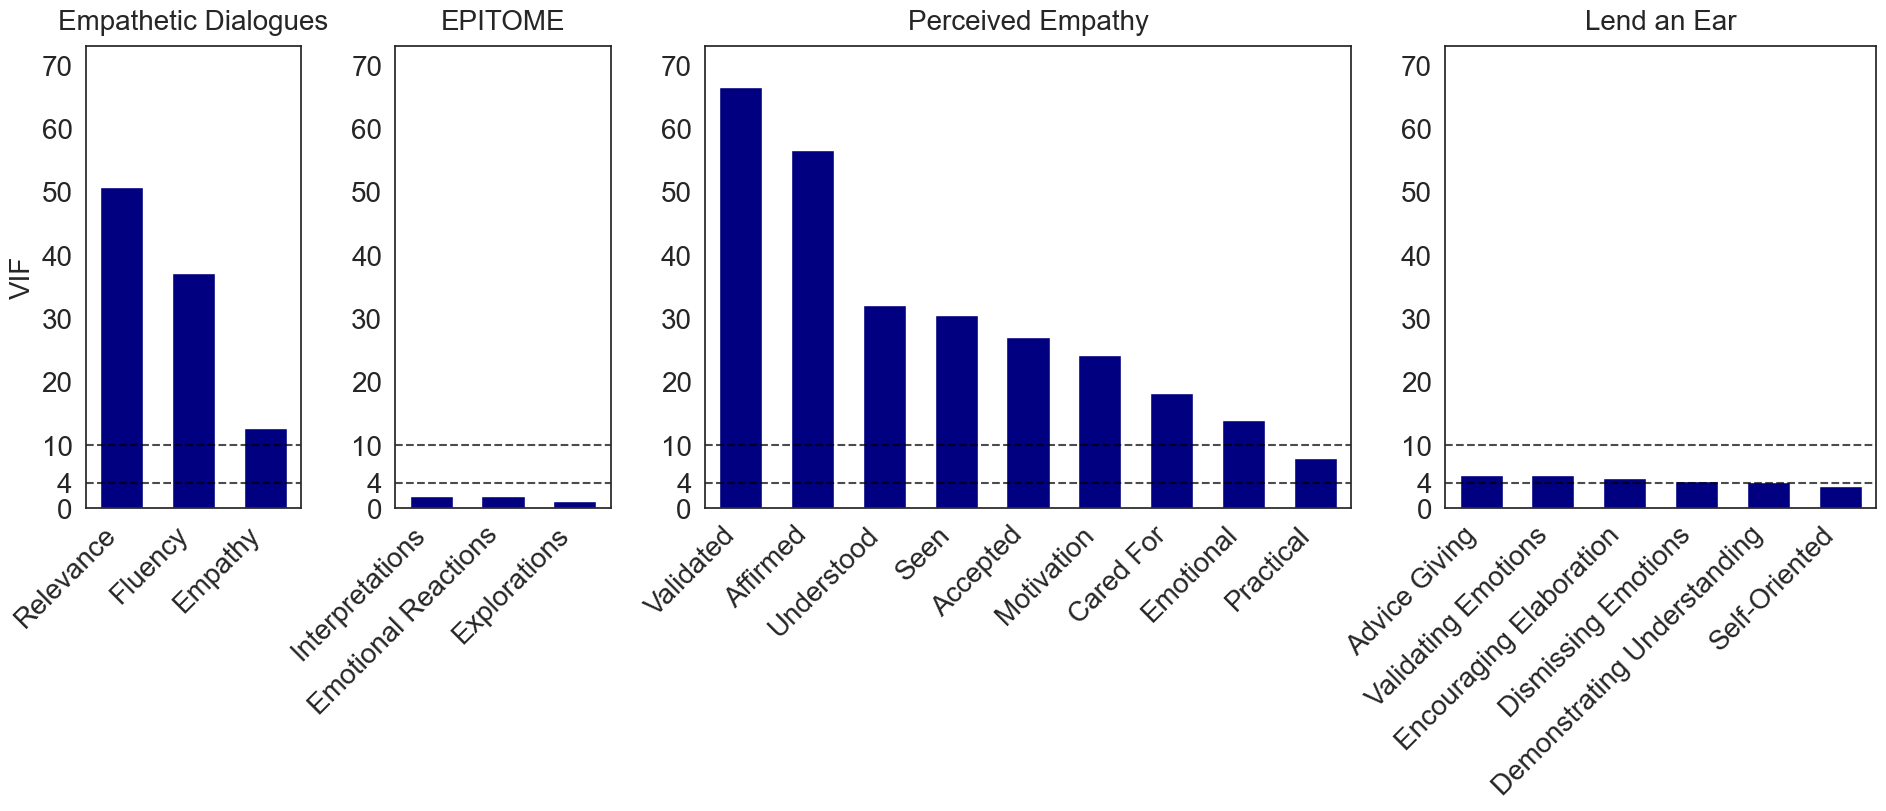

In [20]:
# Read the combined annotations data
data = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

# Define the datasets (frameworks) and their dimensions in the desired order
ordered_datasets = [
    "empatheticdialogues",  # First position
    "epitome",              # Second position
    "perceived_empathy",    # Third position
    "rpg"                   # Fourth position
]

dataset_info = {
    "rpg": {
        "dimensions": [
            "validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",
        ],
        "display_names": [
            "Validating Emotions",
            "Encouraging Elaboration",
            "Demonstrating Understanding",
            "Advice Giving",
            "Self-Oriented",
            "Dismissing Emotions",
        ]
    },
    "perceived_empathy": {
        "dimensions": [
            "m_understood",
            "m_validated",
            "m_affirmed",
            "m_seen",
            "m_accepted",
            "m_caredfor",
            "m_emotional",
            "m_practical",
            "m_motivation",
        ],
        "display_names": [
            "Understood",
            "Validated",
            "Affirmed",
            "Seen",
            "Accepted",
            "Cared For",
            "Emotional",
            "Practical",
            "Motivation",
        ]
    },
    "empatheticdialogues": {
        "dimensions": [
            "empathy",
            "relevance",
            "fluency",
        ],
        "display_names": [
            "Empathy",
            "Relevance",
            "Fluency",
        ]
    },
    "epitome": {
        "dimensions": [
            "level_emotional_reactions",
            "level_explorations",
            "level_interpretations",
        ],
        "display_names": [
            "Emotional Reactions",
            "Explorations",
            "Interpretations",
        ]
    },
}

# Map display names to internal names
dataset_mapping = {
    'empatheticdialogues': 'Empathetic Dialogues',
    'epitome': 'EPITOME',
    'perceived_empathy': 'Perceived Empathy',
    'rpg': 'Lend an Ear'
}
sns.set_theme(style="whitegrid")
# First, convert all numeric columns to float
for col in data.columns:
    if col not in ['rpg_conversation_id', 'perceived_conversation_id', 'empathetic_conversation_id', 
                  'epitome_conversation_id', 'annotation_method', 'full_conversation', 'rp_id']:
        data[col] = pd.to_numeric(data[col], errors='coerce')


# Filter data to only include expert annotations and calculate median
expert_data = data[data['annotation_method'].isin(['expert1', 'expert2', 'expert3'])]

# Function to calculate standard VIF for each dimension
def calculate_standard_vif(df, dimensions):
    """Calculate VIF for each dimension based on all other dimensions."""
    # Drop rows with any NaN values
    df_clean = df[dimensions].dropna()
    
    # Need at least n+1 samples for n dimensions
    if len(df_clean) <= len(dimensions):
        print(f"Warning: Not enough data points ({len(df_clean)}) for reliable VIF calculation with {len(dimensions)} dimensions")
        return pd.DataFrame({'Dimension': dimensions, 'VIF': [np.nan] * len(dimensions)})
    
    # Calculate VIF for each dimension
    vif_data = pd.DataFrame()
    vif_data["Dimension"] = dimensions
    vif_data["VIF"] = [variance_inflation_factor(df_clean.values, i) for i in range(len(dimensions))]
    
    return vif_data
# Calculate all VIFs for global y-axis
all_vifs = []
vif_results = {}
for dataset_name in ordered_datasets:
    dims = dataset_info[dataset_name]["dimensions"]
    available_dims = [dim for dim in dims if dim in expert_data.columns]
    if len(available_dims) > 1:
        dataset_df = expert_data[available_dims].copy()
        vif_data = calculate_standard_vif(dataset_df, available_dims)
        all_vifs.extend(vif_data["VIF"].dropna().tolist())
        vif_results[dataset_name] = vif_data

# Set global y-axis max (rounded up to nearest 5 or 10 for aesthetics)
if all_vifs:
    global_ymax = np.ceil(max(all_vifs) / 5) * 5
else:
    global_ymax = 10
max_bars = max(len(dataset_info[ds]["dimensions"]) for ds in ordered_datasets)
n_bars_list = [len(dataset_info[ds]["dimensions"]) for ds in ordered_datasets]
# Plot with 1x4 layout
# no grid lines
sns.set_theme(style="white")
fig = plt.figure(figsize=(1.1 * sum(n_bars_list), 6))  # Dynamic width
gs = fig.add_gridspec(1, 4, width_ratios=n_bars_list, wspace=0.25)
bar_width = 0.6
bar_color = 'navy'

for idx, dataset_name in enumerate(ordered_datasets):
    ax = fig.add_subplot(gs[0, idx])
    vif_data = vif_results.get(dataset_name)
    if vif_data is not None:
        display_names = dataset_info[dataset_name]["display_names"]
        dims = dataset_info[dataset_name]["dimensions"]
        available_dims = [dim for dim in dims if dim in expert_data.columns]
        available_display_names = [display_names[dims.index(dim)] for dim in available_dims]
        vif_data["Dimension"] = [available_display_names[available_dims.index(dim)] for dim in vif_data["Dimension"]]
        vif_data = vif_data.sort_values("VIF", ascending=False)
        
        x = np.arange(len(vif_data))
        bars = ax.bar(x, vif_data["VIF"], width=bar_width, color=bar_color)
        ax.set_xticks(x)
        ax.set_xticklabels(vif_data["Dimension"], rotation=45, ha="right", fontsize=20)
        ax.set_yticks([0, 4, 10, 20, 30, 40, 50, 60, 70])
        ax.set_yticklabels([0, 4, 10, 20, 30, 40, 50, 60, 70], fontsize=20)
        ax.set_ylim(0, global_ymax+3)
        ax.set_xlim(-0.5, len(vif_data)-0.5)
        # for i, v in enumerate(vif_data["VIF"]):
            # if not np.isnan(v):
                # ax.text(i, v + 0.2, f"{v:.2f}", ha='center', va='bottom', fontsize=20)
        ax.axhline(y=4, color='black', linestyle='--', alpha=0.7)
        ax.axhline(y=10, color='black', linestyle='--', alpha=0.7)
        # ax.text(len(vif_data) - 0.5, 4.2, 'VIF = 4', ha='right', fontsize=12)
        # ax.text(len(vif_data) - 0.5, 10.2, 'VIF = 10', ha='right', fontsize=12)
        ax.set_title(dataset_mapping.get(dataset_name, dataset_name), fontsize=20, pad=12)
        if idx == 0:
            ax.set_ylabel("VIF", fontsize=20)
        # ax.annotate(f"n = {len(expert_data[available_dims].dropna())}", xy=(0.95, 0.95), xycoords='axes fraction', 
        #             ha='right', va='top', fontsize=10)
    else:
        ax.set_xticks([])
        ax.set_title(dataset_mapping.get(dataset_name, dataset_name), fontsize=18)
        if idx == 0:
            ax.set_ylabel("VIF", fontsize=20)
            
# fig.text(0.5, 0.02, 
#          "VIF < 4: Low multicollinearity | 4 ≤ VIF < 10: Moderate multicollinearity (requires investigation) | VIF ≥ 10: High multicollinearity (requires correction)", 
#          ha='center', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.savefig("figs/vif_bar_plots.png", dpi=300, bbox_inches="tight")
plt.show()


Calculating bootstrapped Krippendorff's alpha for Empathetic Dialogues...
  empathy: alpha=0.529
  fluency: alpha=0.290
  relevance: alpha=0.487
  Dataset mean alpha: 0.435, 95% CI: [0.239, 0.528]

Calculating bootstrapped Krippendorff's alpha for EPITOME...
  level_emotional_reactions: alpha=0.466
  level_explorations: alpha=0.780
  level_interpretations: alpha=0.316
  Dataset mean alpha: 0.520, 95% CI: [0.431, 0.594]

Calculating bootstrapped Krippendorff's alpha for Perceived Empathy...
  m_understood: alpha=0.570
  m_validated: alpha=0.643
  m_affirmed: alpha=0.577
  m_seen: alpha=0.545
  m_accepted: alpha=0.521
  m_caredfor: alpha=0.485
  m_emotional: alpha=0.628
  m_practical: alpha=0.759
  m_motivation: alpha=0.696
  Dataset mean alpha: 0.603, 95% CI: [0.515, 0.668]

Calculating bootstrapped Krippendorff's alpha for Lend an Ear...
  validating_emotions: alpha=0.361
  encouraging_elaboration: alpha=0.677
  demonstrating_understanding: alpha=0.416
  self_oriented: alpha=0.672
  a

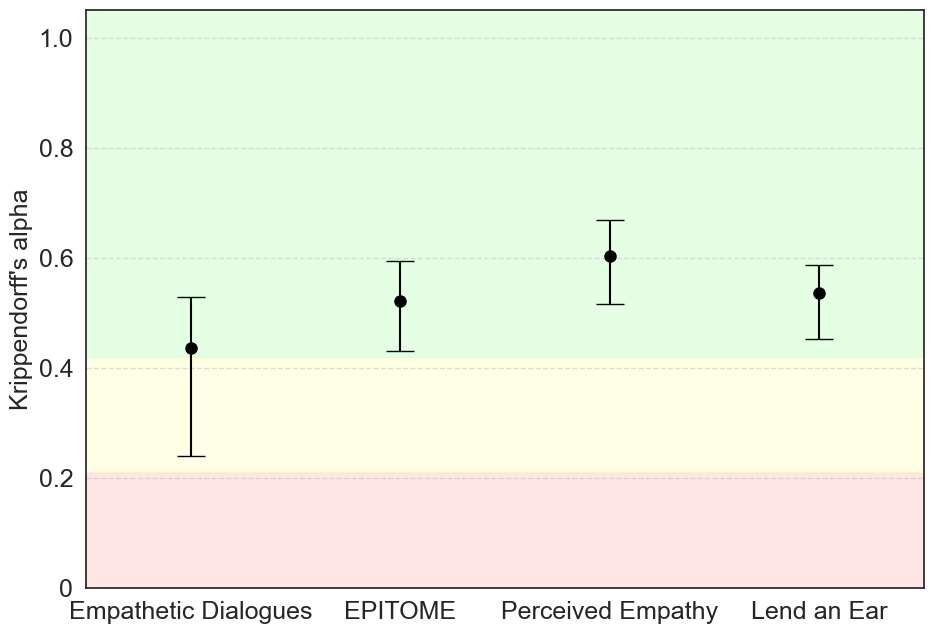

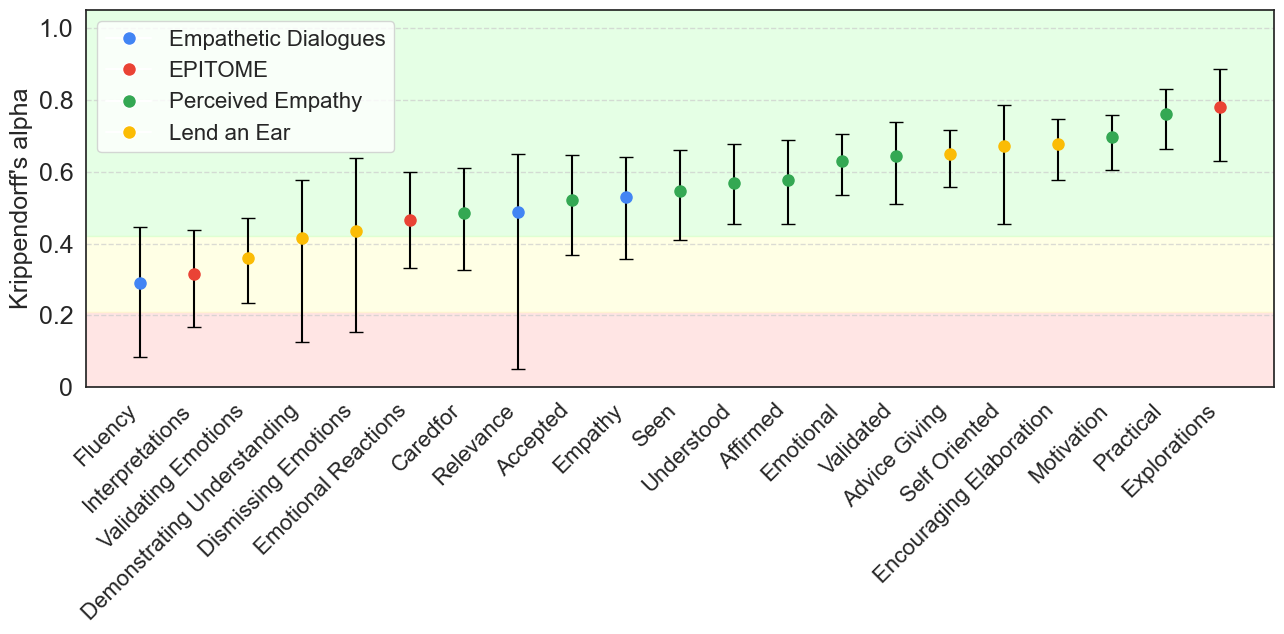

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.utils import resample

# Load data
df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

def calculate_krippendorfs_alpha_manual(df, dimension, dataset_id_column):
    """Manual implementation of Krippendorf's alpha for three expert annotators."""
    # Filter data for each expert
    expert1_data = df[df['annotation_method'] == 'expert1'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    expert2_data = df[df['annotation_method'] == 'expert2'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    expert3_data = df[df['annotation_method'] == 'expert3'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    
    # Join the data
    combined_data = pd.concat([
        expert1_data.rename(columns={dimension: 'expert1'}),
        expert2_data.rename(columns={dimension: 'expert2'}),
        expert3_data.rename(columns={dimension: 'expert3'})
    ], axis=1)
    
    # Convert to numeric and handle missing values
    for col in ['expert1', 'expert2', 'expert3']:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')
    
    combined_data = combined_data.dropna(how='all')
    sample_size = len(combined_data)
    
    if sample_size < 2:
        return np.nan, 0
    
    # Prepare data array
    data = combined_data[['expert1', 'expert2', 'expert3']].values.T
    
    # Calculate observed disagreement
    observed_disagreement = 0
    n_values = 0
    
    for item_idx in range(data.shape[1]):
        item_data = data[:, item_idx]
        valid_values = item_data[~np.isnan(item_data)]
        n_valid = len(valid_values)
        
        if n_valid < 2:
            continue
            
        for i in range(n_valid):
            for j in range(i+1, n_valid):
                observed_disagreement += (valid_values[i] - valid_values[j])**2
                n_values += 1
    
    if n_values == 0:
        return np.nan, sample_size
        
    observed_disagreement /= n_values
    
    # Calculate expected disagreement
    all_valid_values = data[~np.isnan(data)]
    if len(all_valid_values) < 2:
        return np.nan, sample_size
        
    expected_disagreement = 0
    n_pairs = len(all_valid_values) * (len(all_valid_values) - 1)
    
    if n_pairs == 0:
        return np.nan, sample_size
        
    for i in range(len(all_valid_values)):
        for j in range(len(all_valid_values)):
            if i != j:
                expected_disagreement += (all_valid_values[i] - all_valid_values[j])**2
    
    expected_disagreement /= n_pairs
    
    # Calculate alpha
    if expected_disagreement == 0:
        return 1.0, sample_size  # Perfect agreement
    
    alpha = 1 - (observed_disagreement / expected_disagreement)
    return alpha, sample_size

def bootstrap_all_alphas(df, dataset_info, n_bootstrap=1000, confidence=0.95):
    """
    Calculate both dataset-level and dimension-level bootstrapped confidence intervals 
    for Krippendorff's alpha in a single pass.
    
    Parameters:
    - df: DataFrame containing annotations
    - dataset_info: List of dictionaries with dataset information
    - n_bootstrap: Number of bootstrap samples
    - confidence: Confidence level for intervals
    
    Returns:
    - dataset_results: Dictionary with dataset-level results
    - dimension_results: List of dictionaries with dimension-level results
    """
    # Initialize results containers
    dataset_results = {}
    dimension_results = []
    
    # Process each dataset
    for dataset in dataset_info:
        dataset_name = dataset['display_name']
        dimensions = dataset['dimensions']
        dataset_id_column = dataset['id_column']
        print(f"\nCalculating bootstrapped Krippendorff's alpha for {dataset_name}...")
        
        # Get all sample IDs for bootstrapping
        all_ids = df[df['annotation_method'].isin(['expert1', 'expert2', 'expert3'])][dataset_id_column].unique()
        if len(all_ids) < 5:
            print(f"Warning: Only {len(all_ids)} unique IDs found - bootstrapping may be unreliable")
            continue
        
        # Calculate original alphas for each dimension
        orig_alphas = {}
        sample_sizes = []
        dimension_bootstrap_data = {}  # Store bootstrap data for each dimension
        
        for dimension in dimensions:
            try:
                # Calculate original alpha for this dimension
                alpha, n = calculate_krippendorfs_alpha_manual(df, dimension, dataset_id_column)
                orig_alphas[dimension] = alpha
                sample_sizes.append(n)
                
                # Only bootstrap if we have a valid alpha value
                if not np.isnan(alpha) and n >= 5:
                    # Store for dimension-level results
                    clean_dim = dimension.replace('level_', '').replace('m_', '').replace('_', ' ')
                    clean_dim = ' '.join(word.capitalize() for word in clean_dim.split())
                    
                    dimension_bootstrap_data[dimension] = {
                        'original_alpha': alpha,
                        'bootstrap_alphas': [],
                        'sample_size': n,
                        'clean_name': clean_dim,
                        'dataset': dataset_name
                    }
                
            except Exception as e:
                print(f"Error calculating alpha for {dimension}: {e}")
                orig_alphas[dimension] = np.nan
        
        # Calculate original mean alpha (ignoring NaNs)
        valid_alphas = [a for a in orig_alphas.values() if not np.isnan(a)]
        if not valid_alphas:
            print(f"No valid alpha values for {dataset_name}, skipping")
            continue
        
        mean_alpha = np.mean(valid_alphas)
        
        # Bootstrap samples - resample conversations for both levels
        bootstrap_means = []  # For dataset-level
        
        for _ in range(n_bootstrap):
            # Resample IDs with replacement
            bootstrap_ids = resample(all_ids, replace=True, n_samples=len(all_ids))
            
            # Filter data to include only bootstrap samples
            bootstrap_df = df[df[dataset_id_column].isin(bootstrap_ids)]
            
            # Calculate alpha for each dimension in this bootstrap sample
            bootstrap_alphas = []
            
            for dimension in dimensions:
                if dimension in dimension_bootstrap_data:
                    try:
                        alpha, _ = calculate_krippendorfs_alpha_manual(bootstrap_df, dimension, dataset_id_column)
                        
                        if not np.isnan(alpha):
                            # For dataset-level
                            bootstrap_alphas.append(alpha)
                            
                            # For dimension-level
                            dimension_bootstrap_data[dimension]['bootstrap_alphas'].append(alpha)
                    except Exception:
                        # Silently skip failed calculations in bootstrap iterations
                        pass
            
            # Calculate mean alpha for this bootstrap sample (dataset-level)
            if bootstrap_alphas:
                bootstrap_means.append(np.mean(bootstrap_alphas))
        
        # Calculate dataset-level confidence intervals
        if len(bootstrap_means) >= 10:
            alpha_level = (1 - confidence) / 2
            ci_lower_dataset = max(0, np.percentile(bootstrap_means, 100 * alpha_level))
            ci_upper_dataset = min(1, np.percentile(bootstrap_means, 100 * (1 - alpha_level)))
        else:
            print(f"Warning: Only {len(bootstrap_means)} valid bootstrap samples for {dataset_name}")
            ci_lower_dataset = np.nan
            ci_upper_dataset = np.nan
        
        # Store dataset-level results
        dataset_results[dataset_name] = {
            "alphas_by_dimension": orig_alphas,
            "mean_alpha": mean_alpha,
            "ci_lower": ci_lower_dataset,
            "ci_upper": ci_upper_dataset,
            "sample_size": np.mean(sample_sizes) if sample_sizes else 0
        }
        
        # Calculate dimension-level confidence intervals and store results
        for dimension, dim_data in dimension_bootstrap_data.items():
            bootstrap_values = dim_data['bootstrap_alphas']
            
            if len(bootstrap_values) >= 10:
                ci_lower_dim = max(0, np.percentile(bootstrap_values, 100 * alpha_level))
                ci_upper_dim = min(1, np.percentile(bootstrap_values, 100 * (1 - alpha_level)))
            else:
                ci_lower_dim = np.nan
                ci_upper_dim = np.nan
            
            dimension_results.append({
                'dataset': dim_data['dataset'],
                'dimension': dimension,
                'clean_name': dim_data['clean_name'],
                'alpha': dim_data['original_alpha'],
                'ci_lower': ci_lower_dim,
                'ci_upper': ci_upper_dim,
                'sample_size': dim_data['sample_size']
            })
        
        # Print dimension-level alphas
        for dim, alpha in orig_alphas.items():
            print(f"  {dim}: alpha={alpha:.3f}")
        
        # Print dataset-level results with bootstrap CIs
        print(f"  Dataset mean alpha: {mean_alpha:.3f}, 95% CI: [{ci_lower_dataset:.3f}, {ci_upper_dataset:.3f}]")
    
    return dataset_results, dimension_results

# Define dataset information
dataset_info = [
    {
        'key': 'empatheticdialogues',
        'display_name': 'Empathetic Dialogues',
        'id_column': 'empathetic_conversation_id',
        'dimensions': ['empathy', 'fluency', 'relevance']
    },
    {
        'key': 'epitome',
        'display_name': 'EPITOME',
        'id_column': 'epitome_conversation_id',
        'dimensions': ['level_emotional_reactions', 'level_explorations', 'level_interpretations']
    },
    {
        'key': 'perceived_empathy',
        'display_name': 'Perceived Empathy',
        'id_column': 'perceived_conversation_id',
        'dimensions': ['m_understood', 'm_validated', 'm_affirmed', 'm_seen', 
                      'm_accepted', 'm_caredfor', 'm_emotional', 'm_practical', 'm_motivation']
    },
    {
        'key': 'rpg',
        'display_name': 'Lend an Ear',
        'id_column': 'rpg_conversation_id',
        'dimensions': ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding',
                      'self_oriented', 'advice_giving', 'dismissing_emotions']
    }
]



# Run the combined bootstrapping function once
dataset_results, dimension_results = bootstrap_all_alphas(df, dataset_info)

# Convert dimension results to DataFrame and sort
dim_df = pd.DataFrame(dimension_results)
dim_df = dim_df.sort_values('alpha', ascending=True)

# Define colors for datasets
dataset_colors = {
    'Empathetic Dialogues': '#4285F4',  # Blue
    'EPITOME': '#EA4335',               # Red
    'Perceived Empathy': '#34A853',     # Green
    'Lend an Ear': '#FBBC05'            # Yellow
}

# --- DATASET-LEVEL PLOT ---
fig1, ax1 = plt.subplots(figsize=(9.5, 6.5))

# Add colored background for agreement levels
ax1.add_patch(Rectangle((0, 0), 1, 0.2, transform=ax1.transAxes, color='#ffcccb', alpha=0.5, zorder=0))
ax1.add_patch(Rectangle((0, 0.2), 1, 0.2, transform=ax1.transAxes, color='#ffffcc', alpha=0.5, zorder=0))
ax1.add_patch(Rectangle((0, 0.4), 1, 0.6, transform=ax1.transAxes, color='#ccffcc', alpha=0.5, zorder=0))

# Plot the data points with error bars
display_names = [dataset['display_name'] for dataset in dataset_info]
x_pos = range(len(display_names))

mean_alphas = [dataset_results[name]["mean_alpha"] for name in display_names]
error_bars = [(dataset_results[name]["mean_alpha"] - dataset_results[name]["ci_lower"], 
               dataset_results[name]["ci_upper"] - dataset_results[name]["mean_alpha"]) 
              for name in display_names]
error_bars = np.array(error_bars).T

ax1.errorbar(x_pos, mean_alphas, yerr=error_bars, fmt='o', color='black', 
            ecolor='black', capsize=10, markersize=8)

# Set labels and limits
ax1.set_ylabel("Krippendorff's alpha", fontsize=18)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(display_names, rotation=0, fontsize=18)
ax1.set_ylim(0, 1.05)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
ax1.set_xlim(-0.5, len(display_names) - 0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("figs/krippendorffs_alpha_by_dataset_bootstrapped.png", dpi=300, bbox_inches="tight")
plt.show()

# --- DIMENSION-LEVEL PLOT ---
fig2, ax2 = plt.subplots(figsize=(13, 6.5))

# Add colored background for agreement levels
ax2.add_patch(Rectangle((0, 0), 1, 0.2, transform=ax2.transAxes, color='#ffcccb', alpha=0.5, zorder=0))
ax2.add_patch(Rectangle((0, 0.2), 1, 0.2, transform=ax2.transAxes, color='#ffffcc', alpha=0.5, zorder=0))
ax2.add_patch(Rectangle((0, 0.4), 1, 0.6, transform=ax2.transAxes, color='#ccffcc', alpha=0.5, zorder=0))

# Plot dimensions with error bars
x_pos = np.arange(len(dim_df))

# Plot with points and error bars
for i, (_, row) in enumerate(dim_df.iterrows()):
    color = dataset_colors[row['dataset']]
    
    if np.isnan(row['ci_lower']) or np.isnan(row['ci_upper']):
        # If no confidence intervals, just plot the point without error bars
        ax2.plot(x_pos[i], row['alpha'], 'o', color=color, markersize=8)
    else:
        # Calculate error bar sizes
        yerr = [[row['alpha'] - row['ci_lower']], [row['ci_upper'] - row['alpha']]]
        # Plot with error bars
        ax2.errorbar(x_pos[i], row['alpha'], yerr=yerr, fmt='o', 
                    color=color, ecolor='black', capsize=5, markersize=8)

# Set labels and limits
ax2.set_ylabel("Krippendorff's alpha", fontsize=18)
ax2.set_xlabel("", fontsize=18)
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(dim_df['clean_name'].tolist(), rotation=45, ha='right', fontsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Create legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                 for dataset, color in dataset_colors.items()]
ax2.legend(legend_handles, dataset_colors.keys(), title="", 
          loc='upper left', fontsize=16, title_fontsize=16)

plt.tight_layout()
plt.savefig("figs/krippendorffs_alpha_by_dimension.png", dpi=300, bbox_inches="tight")
plt.show()

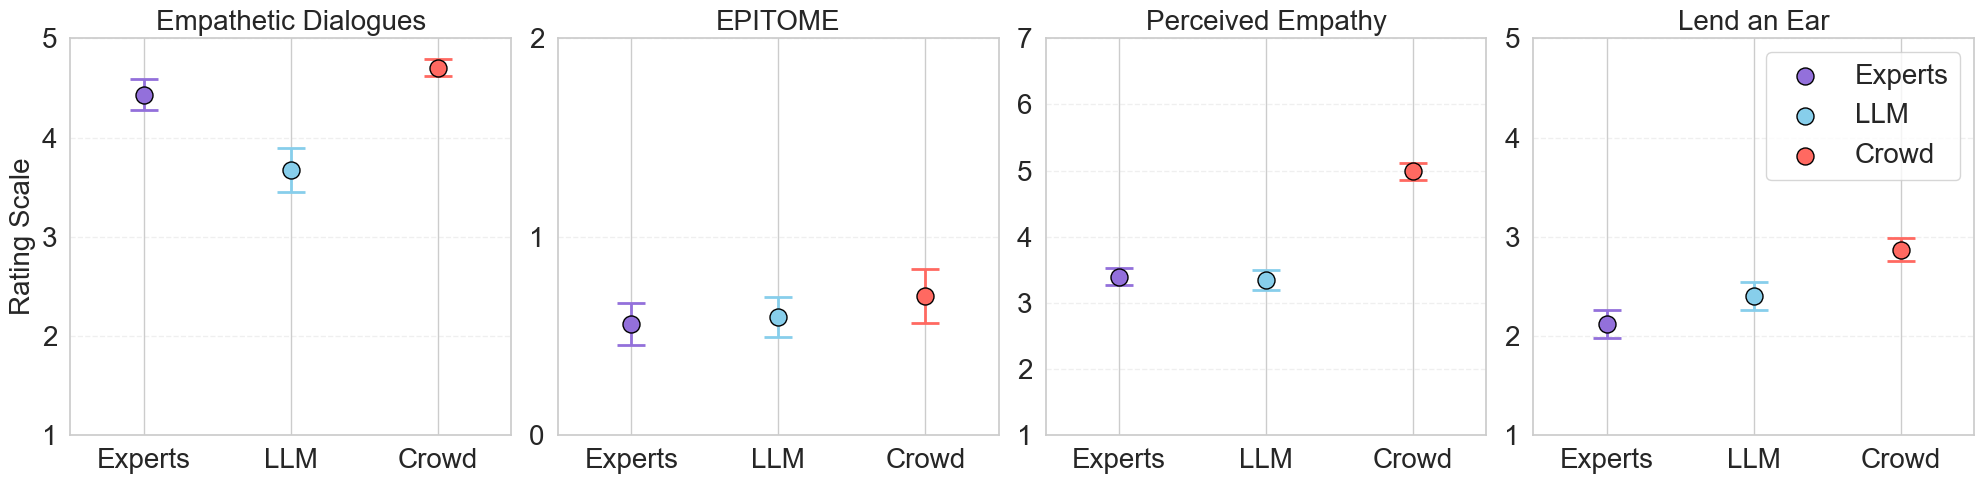

In [24]:
df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")
# reverse code "advice_giving", "self_oriented", "dismissing_emotions"
df["advice_giving"] = 6 - df["advice_giving"]
# Define each dataset's expected block information

# Create a long-format dataframe with individual dimension scores
all_rows = []
for dataset, info in dataset_blocks.items():
    # create blocks based on dimensions and id_col
    block = df[df["annotation_method"].isin(["experts", "llm", "crowd"])][["annotation_method", info["id_col"]] + info["dimensions"]]
    rating_cols = [col for col in block.columns if col in info["dimensions"]]
    # Use the global annotation_method column
    block["annotation_method"] = df["annotation_method"]
    
    # Convert ratings to numeric
    block[rating_cols] = block[rating_cols].apply(pd.to_numeric, errors='coerce')
    
    # Normalize method names for consistency
    block["annotation_method"] = block["annotation_method"].str.lower().replace({
        "experts_mode": "experts", "llm": "llm", "crowd": "crowd"
    })
    
    # Filter for our annotation methods of interest
    block = block[block["annotation_method"].isin(["experts", "llm", "crowd"])].copy()
    
    # Reshape data to long format with each dimension as a separate row
    for dim in rating_cols:
        dim_data = block[["annotation_method", dim]].copy()
        dim_data["Dataset"] = dataset
        dim_data.rename(columns={dim: "score"}, inplace=True)
        all_rows.append(dim_data)

# Combine all data
plot_df = pd.concat(all_rows, ignore_index=True)
plot_df["score"] = pd.to_numeric(plot_df["score"], errors='coerce')
plot_df.rename(columns={"annotation_method": "Method"}, inplace=True)

# Set categorical order for plotting
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "Lend an Ear"]
method_order = ["experts", "llm", "crowd"]
method_labels = ["Experts", "LLM", "Crowd"]

# Define colors for methods
method_colors = {'experts': '#9370DB', 'llm': '#87CEEB', 'crowd': '#FF6961'}  # Purple, Light Blue, Red

# Define y-axis limits for each dataset
y_axis_ticks = {
    "Empathetic Dialogues": [1, 2, 3, 4, 5],
    "EPITOME": [0, 1, 2],
    "Perceived Empathy": [1, 2, 3, 4, 5, 6, 7],
    "Lend an Ear": [1, 2, 3, 4, 5]
}

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)  # 1x4 layout

# Calculate summary statistics for each dataset and method
for i, (ax, dname) in enumerate(zip(axes.flatten(), dataset_order)):
    data_subset = plot_df[plot_df["Dataset"] == dname]
    
    if not data_subset.empty:
        # For x-positioning of points
        x_positions = {'experts': 1, 'llm': 2, 'crowd': 3}
        
        # For each method, calculate mean and 95% CI
        for method in method_order:
            method_subset = data_subset[data_subset["Method"] == method]
            if not method_subset.empty:
                scores = method_subset["score"].dropna().values
                
                # Calculate statistics
                mean_score = np.mean(scores)
                
                # Calculate 95% confidence interval
                if len(scores) > 1:
                    se = stats.sem(scores)
                    ci_95 = se * stats.t.ppf((1 + 0.95) / 2, len(scores) - 1)
                else:
                    ci_95 = 0
                
                # Plot mean as point
                ax.scatter(x_positions[method], mean_score, color=method_colors[method], 
                          s=150, zorder=3, edgecolor='black', linewidth=1)
                
                # Plot 95% CI as error bars
                ax.errorbar(x_positions[method], mean_score, yerr=ci_95, 
                           color=method_colors[method], capsize=10, capthick=2, 
                           linewidth=2, zorder=2)
        
        # Set the x-tick positions and labels
        ax.set_xticks([1, 2, 3])
        display_labels = ["Experts", "LLM", "Crowd"]
        ax.set_xticklabels(display_labels, fontsize=20)
        
        # Set y-axis limits and ticks based on the dataset
        ax.set_yticks(y_axis_ticks[dname])
        ax.set_yticklabels(y_axis_ticks[dname], fontsize=20)
        
        # Set title and adjust limits
        ax.set_title(dname, fontsize=20)
        ax.set_xlim(0.5, 3.5)
        
        # Only add y-label to the first plot
        if i == 0:
            ax.set_ylabel("Rating Scale", fontsize=20)
        
        # Add grid
        ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(display_labels,fontsize=20)
plt.tight_layout()
plt.savefig("figs/empathy_scores_scatterplot_with_ci.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/925633267.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 21.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/925633267.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(method_labels, fontsize=20, ha='cent

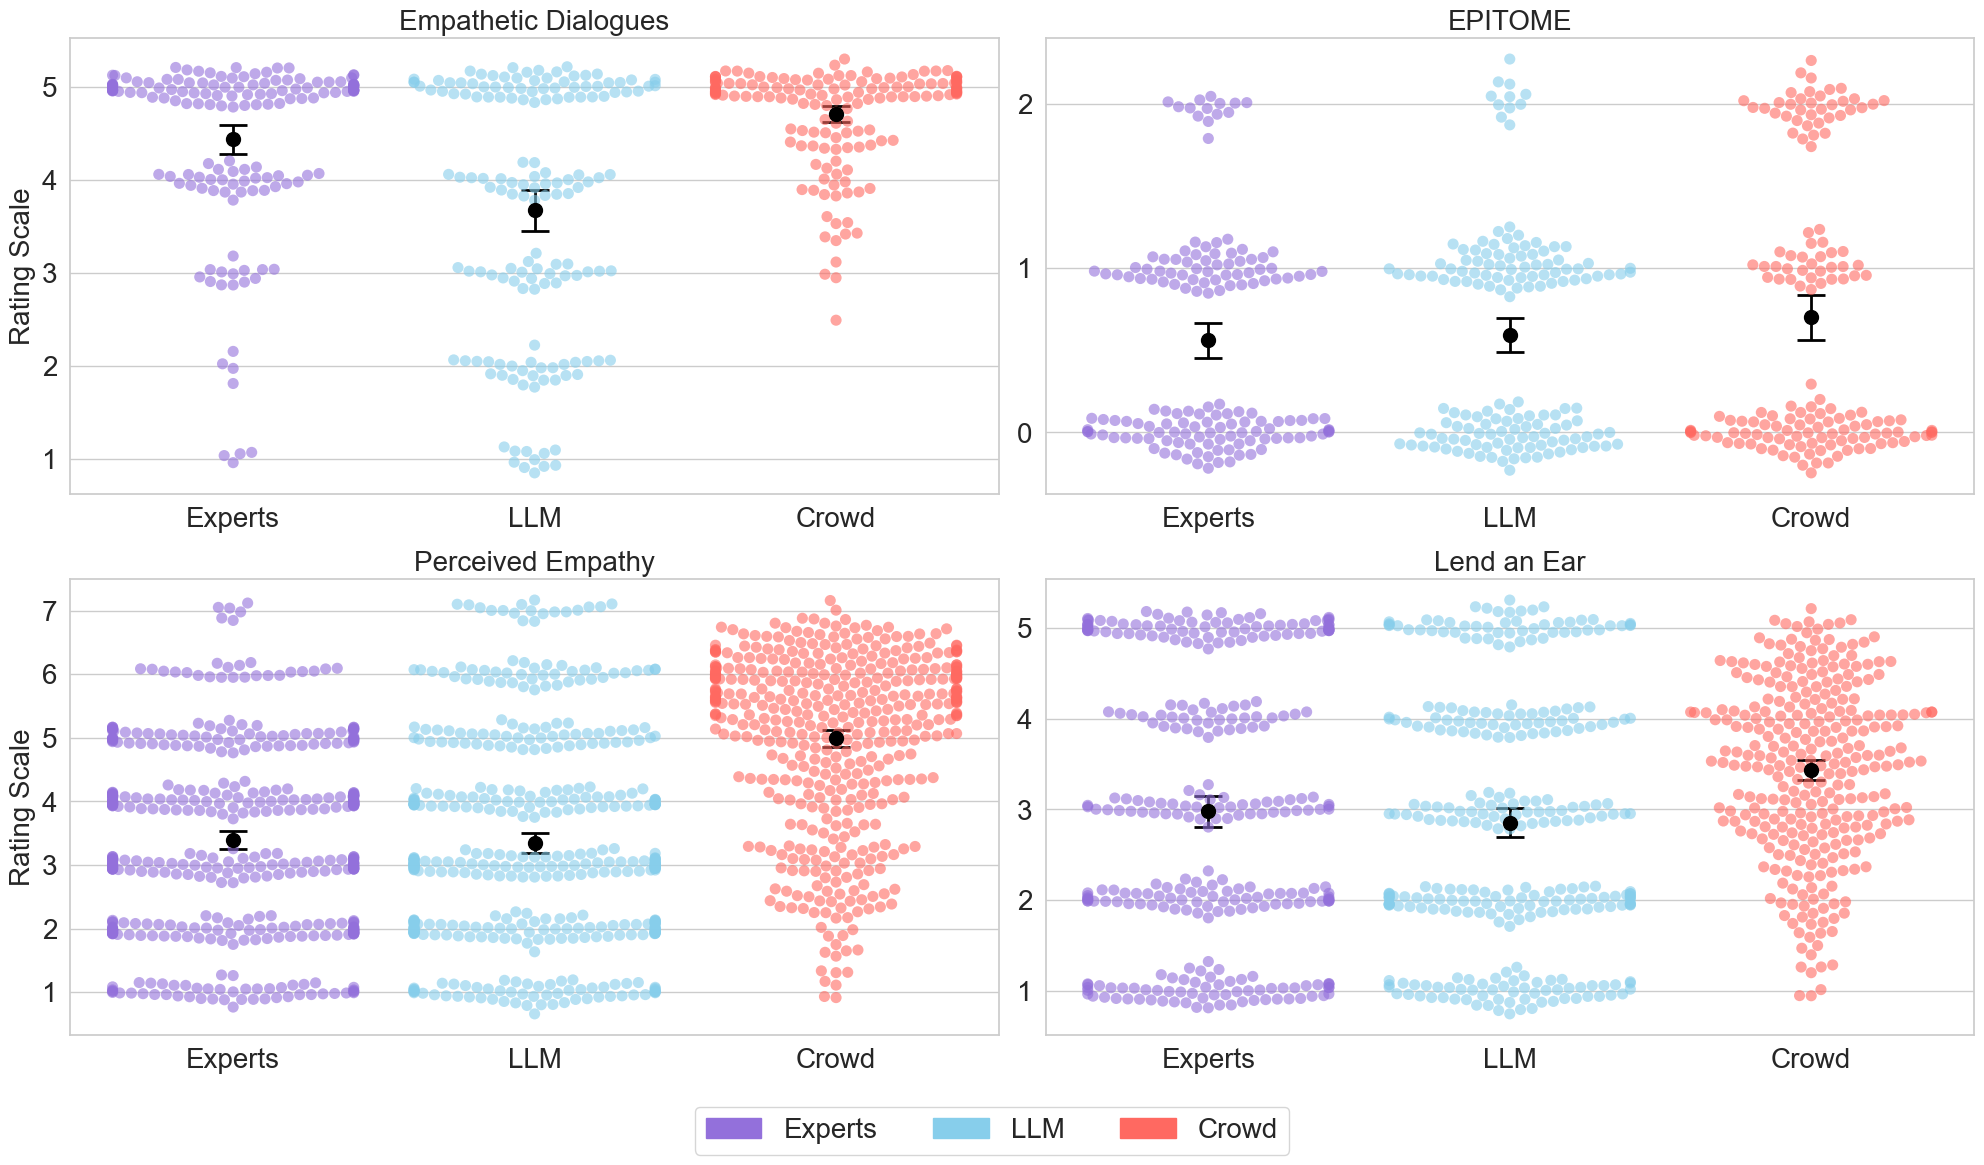

In [23]:
df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")
# reverse code "advice_giving", "self_oriented", "dismissing_emotions"
df["advice_giving"] = 6 - df["advice_giving"]


dataset_blocks = {
    "Empathetic Dialogues": {
        "dimensions": ["empathy", "fluency", "relevance"],
        "id_col": "empathetic_conversation_id"
    },
    "EPITOME": {
        "dimensions": ["level_emotional_reactions", "level_explorations", "level_interpretations"],
        "id_col": "epitome_conversation_id"
    },
    "Perceived Empathy": {
        "dimensions": [
            "m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
            "m_caredfor", "m_emotional", "m_practical", "m_motivation"
        ],
        "id_col": "perceived_conversation_id"
    },
    "Lend an Ear": {
        "dimensions": [
            "validating_emotions", "encouraging_elaboration", "demonstrating_understanding",
            "advice_giving", "self_oriented", "dismissing_emotions"
        ],
        "id_col": "rpg_conversation_id"
    }
}

# for Lend an Ear, reverse code "advice_giving", "self_oriented", "dismissing_emotions"
df["advice_giving"] = 6 - df["advice_giving"]
df["self_oriented"] = 6 - df["self_oriented"]
df["dismissing_emotions"] = 6 - df["dismissing_emotions"]

# Create a long-format dataframe with individual dimension scores
all_rows = []
for dataset, info in dataset_blocks.items():
    # create blocks based on dimensions and id_col
    block = df[df["annotation_method"].isin(["experts", "llm", "crowd"])][["annotation_method", info["id_col"]] + info["dimensions"]]
    rating_cols = [col for col in block.columns if col in info["dimensions"]]
    # Use the global annotation_method column
    block["annotation_method"] = df["annotation_method"]
    
    # Convert ratings to numeric
    block[rating_cols] = block[rating_cols].apply(pd.to_numeric, errors='coerce')
    
    # Normalize method names for consistency
    block["annotation_method"] = block["annotation_method"].str.lower().replace({
        "experts_mode": "experts", "llm": "llm", "crowd": "crowd"
    })
    
    # Filter for our annotation methods of interest
    block = block[block["annotation_method"].isin(["experts", "llm", "crowd"])].copy()
    
    # Reshape data to long format with each dimension as a separate row
    for dim in rating_cols:
        dim_data = block[["annotation_method", info["id_col"], dim]].copy()
        dim_data["Dataset"] = dataset
        dim_data["dimension"] = dim
        dim_data.rename(columns={dim: "score"}, inplace=True)
        all_rows.append(dim_data)

# Combine all data
plot_df = pd.concat(all_rows, ignore_index=True)
plot_df["score"] = pd.to_numeric(plot_df["score"], errors='coerce')
plot_df.rename(columns={"annotation_method": "Method"}, inplace=True)

# Set categorical order for plotting
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "Lend an Ear"]
method_order = ["experts", "llm", "crowd"]
method_labels = ["Experts", "LLM", "Crowd"]

# Define colors for methods
palette = {'experts': '#9370DB', 'llm': '#87CEEB', 'crowd': '#FF6961'}  # Purple, Light Blue, Red

# Define y-axis limits for each dataset
y_axis_ticks = {
    "Empathetic Dialogues": [1, 2, 3, 4, 5],
    "EPITOME": [0, 1, 2],
    "Perceived Empathy": [1, 2, 3, 4, 5, 6, 7],
    "Lend an Ear": [1, 2, 3, 4, 5]
}

# Set theme
sns.set_theme(style="whitegrid")

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(20, 11), sharey=False)  # 1x4 layout

# Plot swarmplots for each dataset
for i, (ax, dname) in enumerate(zip(axes.flatten(), dataset_order)):
    data_subset = plot_df[plot_df["Dataset"] == dname].dropna(subset=["score"])
    jitter_strength = 0.1
    y_vals = data_subset['score'] + np.random.normal(0, jitter_strength, size=len(data_subset))
    if not data_subset.empty:
        # Use swarmplot with dodge to prevent overlap
        sns.swarmplot(
            x="Method", 
            y=y_vals, 
            data=data_subset,
            palette=palette,
            size=8, 
            ax=ax,
            order=method_order,
            alpha=0.6
        )
        
        # Set x-tick labels
        ax.set_xticklabels(method_labels, fontsize=20, ha='center')
        
        # Set y-axis limits and ticks based on the dataset
        ax.set_yticks(y_axis_ticks[dname])
        ax.set_yticklabels(y_axis_ticks[dname], fontsize=20)
        
        # Set title and label
        ax.set_title(dname, fontsize=20)
        ax.set_xlabel("")

        # Add black dots for mean scores of each method
        for method_idx, method in enumerate(method_order):
            method_data = data_subset[data_subset["Method"] == method]
            if not method_data.empty:
                method_mean = np.mean(method_data["score"])
                ax.scatter(method_idx, method_mean, color='black', marker='o', s=100, zorder=4)

                 # Calculate 95% confidence interval
                if len(method_data["score"]) > 1:
                    se = stats.sem(method_data["score"])
                    ci_95 = se * stats.t.ppf((1 + 0.95) / 2, len(method_data["score"]) - 1)
                else:
                    ci_95 = 0
                                
                # Plot 95% CI as error bars
                ax.errorbar(method_idx, method_mean, yerr=ci_95, 
                           color='black', capsize=10, capthick=2, 
                           linewidth=2, zorder=2)
        
        # Only add y-label to the first plot
        if i == 0 or i == 2:
            ax.set_ylabel("Rating Scale", fontsize=20)
        else:
            ax.set_ylabel("")

# Create a custom legend
handles = [
    mpatches.Patch(color=palette['experts'], label='Experts'),
    mpatches.Patch(color=palette['llm'], label='LLM'),
    mpatches.Patch(color=palette['crowd'], label='Crowd')
]
fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.savefig("figs/empathy_scores_swarmplot.png", dpi=300, bbox_inches="tight")
plt.show()


Weighted Cohen's Kappa percentiles (25th, 50th, 75th): [0.49  0.58  0.655]


/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_66779/2907861850.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


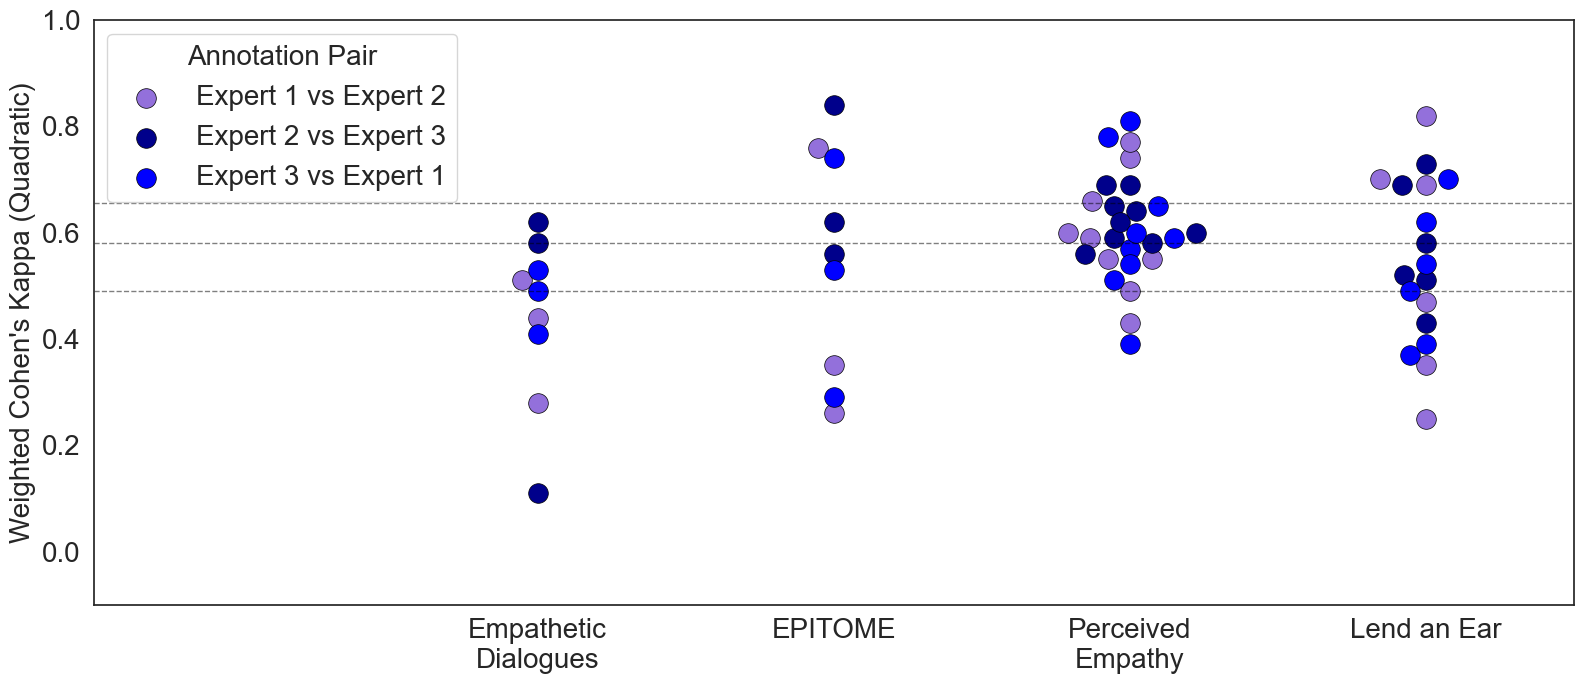

In [25]:
kappa = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")

expert_pairs_to_filter = [
    "('expert1', 'expert2')",
    "('expert2', 'expert3')",
    "('expert3', 'expert1')"
]
kappa = kappa[kappa['Annotator Pair'].isin(expert_pairs_to_filter)]
percentiles = np.percentile(kappa["Weighted Cohen's Kappa"].values.astype(float), [25, 50, 75])
print("Weighted Cohen's Kappa percentiles (25th, 50th, 75th):", percentiles)
sns.set_style("white")

# Clean up the Annotator Pair labels first
label_mapping = {
    "('expert1', 'expert2')": "Expert 1 vs Expert 2",
    "('expert2', 'expert3')": "Expert 2 vs Expert 3",
    "('expert3', 'expert1')": "Expert 3 vs Expert 1",

}

# Create a clean copy of the data with fixed labels
plot_data = kappa.copy()
plot_data["Annotator Pair"] = plot_data["Annotator Pair"].replace(label_mapping)
plot_data["Weighted Cohen's Kappa"] = plot_data["Weighted Cohen's Kappa"].astype(float)



colors = {
    "Expert 1 vs Expert 2": "#9370DB",         # Purple
    "Expert 2 vs Expert 3": "darkblue", # Red
    "Expert 3 vs Expert 1": "blue",   # Light Blue
}

marker_mapping = {"Expert 1 vs Expert 2": "o", "Expert 2 vs Expert 3": "o", "Expert 3 vs Expert 1": "o" }
# colors = {"Experts": "#87CEEB", "Experts & LLM": "green", "Experts & Crowd": "red", "Crowd & LLM": "yellow"}


hue_order = ["Expert 1 vs Expert 2", "Expert 2 vs Expert 3", "Expert 3 vs Expert 1"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "RPG"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Weighted Cohen's Kappa",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=13
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot each hue's points with the correct marker and color
for hue in hue_order:
    # add some jitter to the points
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=200,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )

plt.axhline(y=percentiles[0], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[1], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[2], color='black', linestyle='--', linewidth=1, alpha=0.5)


# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=20
)
ax.set_yticklabels(
    ["-0.1", "0.0", "0.2", "0.4",  "0.6",  "0.8", "1.0"],
    fontsize=20
)
plt.xlabel("")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=20)

# Handle legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=20,
    title_fontsize=20
)

plt.xlim(-1.5, 3.5)
plt.ylim(-0.1, 1)
plt.tight_layout()

plt.savefig("figs/beeswarm_plot_quadratic_cohens_kappa_experts.png", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# Reading the generated data
rpg_cot_15 = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_gemini-1.5-flash_0.csv')
rpg_cot_4o = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_gpt-4o_0.csv')
rpg_cot_25 = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_gemini-2.5-pro-exp-03-25_0.csv')
rpg_cot_claude = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_claude_0.csv')

rpg_fewshot_15 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gemini-1.5-flash_0.csv')
rpg_fewshot_20 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gemini-2.0-flash_0.csv')
rpg_fewshot_25 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gemini-2.5-pro-exp-03-25_0.csv')
rpg_fewshot_4o = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_0.csv')
rpg_fewshot_claude = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_0.csv')

perceived_empathy_cot_4o = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_cot_gpt-4o_0.csv')
perceived_empathy_cot_25 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_cot_gemini-2.5-pro-preview-03-25_0.csv')
perceived_empathy_cot_claude = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_cot_claude_0.csv')
perceived_empathy_cot_4o = perceived_empathy_cot_4o.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_cot_25 = perceived_empathy_cot_25.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_cot_claude = perceived_empathy_cot_claude.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})

perceived_empathy_15 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-1.5-flash_0.csv')
perceived_empathy_4o = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_0.csv')
perceived_empathy_25 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-preview-03-25_0.csv')
perceived_empathy_15 = perceived_empathy_15.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_4o = perceived_empathy_4o.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_25 = perceived_empathy_25.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_claude = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_0.csv')

empathetic_dialogues_cot_4o = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_cot_gpt-4o_0.csv')
empathetic_dialogues_cot_25 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_cot_gemini-2.5-pro-preview-03-25_0.csv')
empathetic_dialogues_cot_claude = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_cot_claude_0.csv')

empathetic_dialogues_cot_4o = empathetic_dialogues_cot_4o.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_cot_25 = empathetic_dialogues_cot_25.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_cot_claude = empathetic_dialogues_cot_claude.rename(columns={'conversation_id': 'conv_id'})

empathetic_dialogues_15 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-1.5-flash_0.csv')
empathetic_dialogues_4o = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_0.csv')
empathetic_dialogues_25 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-preview-03-25_0.csv')
empathetic_dialogues_claude = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_0.csv')
empathetic_dialogues_15 = empathetic_dialogues_15.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_4o = empathetic_dialogues_4o.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_25 = empathetic_dialogues_25.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_claude = empathetic_dialogues_claude.rename(columns={'conversation_id': 'conv_id'})


epitome_cot_15 = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_gemini-1.5-flash_0.csv')
epitome_cot_4o = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_gpt-4o_0.csv')
epitome_cot_25 = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_gemini-2.5-pro-preview-03-25_0.csv')
epitome_cot_claude = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_claude_0.csv')
epitome_cot_15 = epitome_cot_15.rename(columns={'conversation_id': 'conv_id'})
epitome_cot_4o = epitome_cot_4o.rename(columns={'conversation_id': 'conv_id'})
epitome_cot_25 = epitome_cot_25.rename(columns={'conversation_id': 'conv_id'})
epitome_cot_claude = epitome_cot_claude.rename(columns={'conversation_id': 'conv_id'})

epitome_15 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-1.5-flash_0.csv')
epitome_4o = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_0.csv')
epitome_25 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-preview-03-25_0.csv')
epitome_claude = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_0.csv')
epitome_15 = epitome_15.rename(columns={'conversation_id': 'conv_id'})
epitome_4o = epitome_4o.rename(columns={'conversation_id': 'conv_id'})
epitome_25 = epitome_25.rename(columns={'conversation_id': 'conv_id'})
epitome_claude = epitome_claude.rename(columns={'conversation_id': 'conv_id'})

rpg_crowd = pd.read_csv('data/rpg/sample_ratings_crowdsourced.csv')
epitome_crowd = pd.read_csv('data/epitome/sample_ratings_crowdsourced.csv')
empathetic_dialogues_crowd = pd.read_csv('data/empatheticdialogues/sample_ratings_crowdsourced.csv')
perceived_empathy_crowd = pd.read_csv('data/perceived_empathy/sample_ratings_crowdsourced.csv')


# 1. RPG Cot Claude updates
rpg_updates = [
    {'conversation_id': '20241031142343248156', 'encouraging_elaboration': 3},
    {'conversation_id': '20241031145050008738', 'dismissing_emotions': 4},
    {'conversation_id': '20241031125849757353', 'demonstrating_understanding': 2},
    {'conversation_id': '20241031145640298594', 'demonstrating_understanding': 2},
]
for update in rpg_updates:
    cid = update.pop('conversation_id')
    for col, val in update.items():
        rpg_cot_claude.loc[rpg_cot_claude['conversation_id'] == cid, col] = val

# 2. Epitome Cot Claude update
epitome_cot_claude.loc[epitome_cot_claude['sp_id'] == '9u1441', 'level_emotional_reactions'] = 1

# 3. Perceived Empathy Cot Claude updates
perceived_updates = [
    {'id': '6361560a2e3e691ad312fed2', 'm_accepted': 1},
    {'id': '5f81ead00afba52e71dcf414', 'm_affirmed': 6},
    {'id': '5e1c71e9114df8000dddf2d6', 'm_caredfor': 3},
    {'id': '629531cb501e6d23d9797050', 'm_validated': 1},
    {'id': '63386e75b02c4d7013c1198b', 'm_understood': 3, 'm_seen': 4},
    {'id': '6390fd9157f0dc14e247a0d6', 'm_caredfor': 2},
    {'id': '5fc3d41149c0c8728f07b95b', 'm_accepted': 3, 'm_seen': 2, 'm_affirmed': 3, 'm_validated': 3},
    {'id': '632e9aa62793c18a857aece4', 'm_caredfor': 4, 'm_validated': 3},
    {'id': '5dcf0b7cffc3d8063f916612', 'm_validated': 3},
    {'id': '63c13fcab1eda5bbe034a17c', 'm_accepted': 2},
    {'id': '614e7ad7ff5a0d785d5e550a', 'm_accepted': 3, 'm_understood': 3},
    {'id': '5cb489ff0cd1ed0017465d19', 'm_understood': 3},
    {'id': '5bcc2cee0ba8a400012592f9', 'm_understood': 2},
    {'id': '5d8e64ab4e055600157a3d90', 'm_understood': 3},
    {'id': '5bfd81fb2feab400014d9060', 'm_understood': 3, 'm_seen': 3},
    {'id': '60f4e3ab507bbb123f866e88', 'm_understood': 2, 'm_validated': 3},
    {'id': '6483b3662d98a34fa389dcd7', 'm_affirmed': 4},
    {'id': '638bb18e1bd657c755e5148f', 'm_accepted': 3},
    {'id': '608bfa04767191aa4d57bfd8', 'm_accepted': 3, 'm_affirmed': 3},
    {'id': '63f77fef0855adb7fa65873d', 'm_understood': 3},
    {'id': '6435d9620649d3801b71cc8b', 'm_understood': 3},
    {'id': '60fd080d5476f4a77211bafb', 'm_accepted': 2},
    {'id': '60fd462512ad2ae6071668f3', 'm_affirmed': 3},
    {'id': '5e84f020507cd30b367b2624', 'm_affirmed': 3, 'm_validated': 3},
    {'id': '62cbf51439a76e8fccd8a495', 'm_seen': 3, 'm_caredfor': 4},
    {'id': '5ee5e3b02eebe932ee9559c5', 'm_validated': 4},
]
for update in perceived_updates:
    pid = update.pop('id')
    for col, val in update.items():
        perceived_empathy_cot_claude.loc[perceived_empathy_cot_claude['id'] == pid, col] = val

# 4. Empathetic Dialogues Cot Claude updates
dialogue_updates = [
    {'conv_id': 'hit:8681_conv:17362', 'fluency': 4},
    {'conv_id': 'hit:1670_conv:3341', 'fluency': 5},
    {'conv_id': 'hit:4103_conv:8207', 'relevance': 5, 'fluency': 5},
    {'conv_id': 'hit:7797_conv:15594', 'fluency': 5},
    {'conv_id': 'hit:6759_conv:13519', 'relevance': 2},
    {'conv_id': 'hit:8311_conv:16622', 'relevance': 5},
    {'conv_id': 'hit:12276_conv:24553', 'relevance': 5},
]
for update in dialogue_updates:
    cid = update.pop('conv_id')
    for col, val in update.items():
        empathetic_dialogues_cot_claude.loc[empathetic_dialogues_cot_claude['conv_id'] == cid, col] = val


# Reading Expert Data
expert1_rpg = pd.read_csv('data/rpg/expert_ratings.csv')
expert2_rpg = pd.read_csv('data/rpg/expert2_ratings.csv')
expert3_rpg = pd.read_csv('data/rpg/expert3_ratings.csv')
expert3_rpg[['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions']]


expert1_pe = pd.read_csv('data/perceived_empathy/expert_ratings.csv')
expert2_pe = pd.read_csv('data/perceived_empathy/expert2_ratings.csv')
expert3_pe = pd.read_csv('data/perceived_empathy/expert3_ratings.csv')

cols = ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
        "m_caredfor", "m_emotional", "m_practical", "m_motivation"]

for col in cols:
    expert3_pe[col] = pd.to_numeric(expert3_pe[col], errors='coerce').astype('Int64')

expert1_ed = pd.read_csv('data/empatheticdialogues/expert_ratings.csv')
expert2_ed = pd.read_csv('data/empatheticdialogues/expert2_ratings.csv')
expert3_ed = pd.read_csv('data/empatheticdialogues/expert3_ratings.csv')
expert3_ed = pd.read_csv('data/empatheticdialogues/expert3_ratings.csv')
# expert3_ed = expert3_ed[1:].reset_index(drop = True)
# expert3_ed.rename(columns = {'Unnamed: 0': 'conv_id',
#                              'Likert scale: \n\n1 - Not at all\n2- Slightly\n3- Somewhat\n4 - Quite a bit\n5 - Very much': 'full_conversation',
#                              'Unnamed: 2': 'empathy',
#                              'Unnamed: 3': 'relevance',
#                              'Unnamed: 4': 'fluency'}, inplace = True)
# expert3_ed.drop(columns = 'full_conversation', inplace=True)
cols = ["empathy", "relevance", "fluency"]
for col in cols:
    expert3_ed[col] = pd.to_numeric(expert3_ed[col], errors='coerce').astype(int)


expert1_ept = pd.read_csv('data/epitome/expert_ratings.csv')
expert2_ept = pd.read_csv('data/epitome/expert2_ratings.csv')
expert3_ept = pd.read_csv('data/epitome/expert3_ratings.csv')
expert3_ept[['level_emotional_reactions', 'level_explorations', 'level_interpretations']].isna().any(axis = 1)


# Organizing the data
def order_by_column(df, column):
    return df.sort_values(by=column).reset_index(drop=True)

expert1_rpg = order_by_column(expert1_rpg, 'conversation_id')
expert2_rpg = order_by_column(expert2_rpg, 'conversation_id')
expert3_rpg = order_by_column(expert3_rpg, 'conversation_id')

expert1_pe = order_by_column(expert1_pe, 'id')
expert2_pe = order_by_column(expert2_pe, 'id')
expert3_pe = order_by_column(expert3_pe, 'id')

expert1_ed = order_by_column(expert1_ed, 'conv_id')
expert2_ed = order_by_column(expert2_ed, 'conv_id')
expert3_ed = order_by_column(expert3_ed, 'conv_id')

expert1_ept = order_by_column(expert1_ept, 'sp_id')
expert2_ept = order_by_column(expert2_ept, 'sp_id')
expert3_ept = order_by_column(expert3_ept, 'sp_id')

# Extracting Scores
def score_extraction(df, col, type):
    if type == 'rpg':
      scores = pd.DataFrame(columns = ['conversation_id', 'validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding',
                                      'advice_giving', 'self_oriented', 'dismissing_emotions'])

      for i in range(len(df)):
          try:
              scores = pd.concat([scores, pd.DataFrame({'conversation_id': df.iloc[i, 1],
                                                      'validating_emotions': [int(str(df.iloc[i, 3])[-1])],
                                                          'encouraging_elaboration': [int(str(df.iloc[i, 4])[-1])],
                                                          'demonstrating_understanding': [int(str(df.iloc[i, 5])[-1])],
                                                          'advice_giving': [int(str(df.iloc[i, 6])[-1])],
                                                          'self_oriented': [int(str(df.iloc[i, 7])[-1])],
                                                          'dismissing_emotions': [int(str(df.iloc[i, 8])[-1])]
                                                          })], ignore_index = True)
              scores = order_by_column(scores, col)
          except ValueError as e:
              print(df.iloc[i, 1])
    elif type == 'ept':
      scores = pd.DataFrame(columns = ['sp_id', 'level_emotional_reactions', 'level_explorations', 'level_interpretations'])

      for i in range(len(df)):
          try:
              scores = pd.concat([scores, pd.DataFrame({'sp_id': df.iloc[i, 0],
                                                      'level_emotional_reactions': [int(str(df.iloc[i, 3])[-1])],
                                                          'level_explorations': [int(str(df.iloc[i, 4])[-1])],
                                                          'level_interpretations': [int(str(df.iloc[i, 5])[-1])],
                                                          })], ignore_index = True)
              scores = order_by_column(scores, col)
          except ValueError as e:
              print(df.iloc[i, 1])
    elif type == 'pe' : 
      scores = pd.DataFrame(columns = ["id", "m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted", "m_caredfor",
                                       "m_emotional", "m_practical", "m_motivation"])

      for i in range(len(df)):
          try:
              scores = pd.concat([scores, pd.DataFrame({'id': df.iloc[i, 0],
                                                      'm_understood': [int(str(df.iloc[i, 2])[-1])],
                                                          'm_validated': [int(str(df.iloc[i, 3])[-1])],
                                                          'm_affirmed': [int(str(df.iloc[i, 4])[-1])],
                                                          "m_seen": [int(str(df.iloc[i, 5])[-1])],
                                                          "m_accepted": [int(str(df.iloc[i, 6])[-1])],
                                                          "m_caredfor": [int(str(df.iloc[i, 7])[-1])],
                                                          "m_emotional": [int(str(df.iloc[i, 8])[-1])],
                                                          "m_practical": [int(str(df.iloc[i, 9])[-1])],
                                                          "m_motivation": [int(str(df.iloc[i, 10])[-1])]
                                                          })], ignore_index = True)
              scores = order_by_column(scores, col)
          except ValueError as e:
              print(df.iloc[i, 0]) 
    else:
        scores = pd.DataFrame(columns = ["conv_id", "empathy", "relevance", "fluency"])
        for i in range(len(df)):
          try:
            scores = pd.concat([scores, pd.DataFrame({'conv_id': df.iloc[i, 0],
                                                        'empathy': [int(str(df.iloc[i, 2])[-1])],
                                                            'relevance': [int(str(df.iloc[i, 3])[-1])],
                                                            'fluency': [int(str(df.iloc[i, 4])[-1])],
                                                            })], ignore_index = True)
            scores = order_by_column(scores, col)
          except ValueError as e:
            print(df.iloc[i, 0])
    return scores

rpg_cot_15 = score_extraction(rpg_cot_15, 'conversation_id', 'rpg')
rpg_cot_4o = score_extraction(rpg_cot_4o, 'conversation_id', 'rpg')
rpg_cot_25 = score_extraction(rpg_cot_25, 'conversation_id', 'rpg')
rpg_cot_claude = score_extraction(rpg_cot_claude, 'conversation_id', 'rpg')

rpg_fewshot_15 = score_extraction(rpg_fewshot_15, 'conversation_id', 'rpg')
rpg_fewshot_20 = score_extraction(rpg_fewshot_20, 'conversation_id', 'rpg')
rpg_fewshot_4o = score_extraction(rpg_fewshot_4o, 'conversation_id', 'rpg')
rpg_fewshot_25 = score_extraction(rpg_fewshot_25, 'conversation_id', 'rpg')
rpg_fewshot_claude = score_extraction(rpg_fewshot_claude, 'conversation_id', 'rpg')

epitome_cot_15 = score_extraction(epitome_cot_15, 'sp_id', 'ept')
epitome_cot_4o = score_extraction(epitome_cot_4o, 'sp_id', 'ept')
epitome_cot_25 = score_extraction(epitome_cot_25, 'sp_id', 'ept')
epitome_cot_claude = score_extraction(epitome_cot_claude, 'sp_id', 'ept')

epitome_15 = score_extraction(epitome_15, 'sp_id', 'ept')
epitome_4o = score_extraction(epitome_4o, 'sp_id', 'ept')
epitome_25 = score_extraction(epitome_25, 'sp_id','ept')
epitome_claude = score_extraction(epitome_claude, 'sp_id', 'ept')

perceived_empathy_15 = score_extraction(perceived_empathy_15, 'id', 'pe')
perceived_empathy_4o = score_extraction(perceived_empathy_4o, 'id', 'pe')
perceived_empathy_25 = score_extraction(perceived_empathy_25, 'id', 'pe')
perceived_empathy_claude = score_extraction(perceived_empathy_claude, 'id', 'pe')

perceived_empathy_cot_4o = score_extraction(perceived_empathy_cot_4o, 'id', 'pe')
perceived_empathy_cot_25 = score_extraction(perceived_empathy_cot_25, 'id', 'pe')
perceived_empathy_cot_claude = score_extraction(perceived_empathy_cot_claude, 'id', 'pe')

empathetic_dialogues_15 = score_extraction(empathetic_dialogues_15, 'conv_id', 'ed')
empathetic_dialogues_4o = score_extraction(empathetic_dialogues_4o, 'conv_id', 'ed')
empathetic_dialogues_25 = score_extraction(empathetic_dialogues_25, 'conv_id','ed')
empathetic_dialogues_claude = score_extraction(empathetic_dialogues_claude, 'conv_id', 'ed')

empathetic_dialogues_cot_4o = score_extraction(empathetic_dialogues_cot_4o, 'conv_id', 'ed')
empathetic_dialogues_cot_25 = score_extraction(empathetic_dialogues_cot_25, 'conv_id','ed')
empathetic_dialogues_cot_claude = score_extraction(empathetic_dialogues_cot_claude, 'conv_id', 'ed')

rpg_crowd = order_by_column(rpg_crowd, 'conversation_id')
epitome_crowd = order_by_column(epitome_crowd, 'sp_id')
empathetic_dialogues_crowd = order_by_column(empathetic_dialogues_crowd, 'conv_id')
perceived_empathy_crowd = order_by_column(perceived_empathy_crowd, 'id')

# Calculating Mean Expert Data
def mean_experts(e1, e2, e3, dims, col):
  order_by_column(e1, col)
  order_by_column(e2, col)
  order_by_column(e3, col)
  
  mean_df = e1.copy()

  for d in dims:
    mean_df[d] = (e1[d] + e2[d] + e3[d]) / 3

  return mean_df

def mode_experts(e1, e2, e3, dims, col):
  order_by_column(e1, col)
  order_by_column(e2, col)
  order_by_column(e3, col)
  
  mode_df = e1.copy()

  for d in dims:
    stacked = np.vstack([e1[d], e2[d], e3[d]]).T  # Shape (n_rows, 3)
    mode_vals, _ = stats.mode(stacked, axis=1, keepdims=False)
    mode_df[d] = mode_vals

  return mode_df 

experts_rpg = mean_experts(expert1_rpg, expert2_rpg, expert3_rpg,
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'conversation_id')

experts_pe = mean_experts(expert1_pe, expert2_pe, expert3_pe,
                          ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted", "m_caredfor", "m_emotional", "m_practical",
                            "m_motivation"], 'id')

experts_ed = mean_experts(expert1_ed, expert2_ed, expert3_ed,
                          ["empathy", "fluency", "relevance"], 'conv_id')

experts_ept = mean_experts(expert1_ept, expert2_ept, expert3_ept,
                           ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'sp_id')

experts_mode_rpg = mode_experts(expert1_rpg, expert2_rpg, expert3_rpg,
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'conversation_id')

experts_mode_pe = mode_experts(expert1_pe, expert2_pe, expert3_pe,
                          ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted", "m_caredfor", "m_emotional", "m_practical",
                            "m_motivation"], 'id')

experts_mode_ed = mode_experts(expert1_ed, expert2_ed, expert3_ed,
                          ["empathy", "fluency", "relevance"], 'conv_id')

experts_mode_ept = mode_experts(expert1_ept, expert2_ept, expert3_ept,
                           ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'sp_id')

# calculating spearman rank correlation and weighted cohen's kappa
def corrs(e1, e2, e3, es, gemini25, gpt, claude, crowd, dims, df):
  corr_df = pd.DataFrame(columns = ['Dataset',
                                    'Dimension', 
                                    'Experts 1 & 2 Spearman Rank Correlation',
                                    'Experts 1 & 3 Spearman Rank Correlation',
                                    'Experts 2 & 3 Spearman Rank Correlation',
                                    'Experts & Crowd Spearman Rank Correlation',
                                    'Crowd & LLM Spearman Rank Correlation', 
                                    'Gemini 2.5 Pro Spearman Rank Correlation',
                                    'GPT 4o Spearman Rank Correlation',
                                    'Claude Spearman Rank Correlation',                                      
                                    'Experts 1 & 2 Weighted Cohen\'s Kappa', 
                                    'Experts 1 & 3 Weighted Cohen\'s Kappa', 
                                    'Experts 2 & 3 Weighted Cohen\'s Kappa', 
                                    'Experts & Crowd Weighted Cohen\'s Kappa',
                                    'Crowd & LLM Weighted Cohen\'s Kappa',
                                    'Gemini 2.5 Pro Weighted Cohen\'s Kappa',
                                    'GPT 4o Weighted Cohen\'s Kappa',
                                    'Claude Weighted Cohen\'s Kappa'])
  for d in dims:
    mask = es[d].notna() & gpt[d].notna()
    new_row = {
            'Dataset': df,
            'Dimension': d,
            'Experts 1 & 2 Spearman Rank Correlation': np.round(e1[d].corr(e2[d], method = 'spearman'), 2),
            'Experts 1 & 3 Spearman Rank Correlation': np.round(e1[d][mask].corr(e3[d][mask], method = 'spearman'), 2),
            'Experts 2 & 3 Spearman Rank Correlation': np.round(e2[d][mask].corr(e3[d][mask], method = 'spearman'), 2),
            'Experts & Crowd Spearman Rank Correlation': np.round(es[d][mask].corr(crowd[d][mask].astype(int), method = 'spearman'), 2),
            'Crowd & LLM Spearman Rank Correlation': np.round(crowd[d][mask].corr(gemini25[d][mask].astype(int), method = 'spearman'), 2),
            'Gemini 2.5 Pro Spearman Rank Correlation': np.round(es[d][mask].corr(gemini25[d][mask].astype(int), method = 'spearman'), 2),
            'GPT 4o Spearman Rank Correlation': np.round(es[d][mask].corr(gpt[d][mask].astype(int), method = 'spearman'),2),
            'Claude Spearman Rank Correlation': np.round(es[d][mask].corr(claude[d][mask].astype(int), method ='spearman'), 2),              
            'Experts 1 & 2 Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(e1[d] + 0.5).astype(int), np.floor(e2[d] + 0.5).astype(int), weights= 'quadratic'), 2),
            'Experts 1 & 3 Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(e1[d][mask] + 0.5).astype(int), np.floor(e3[d][mask] + 0.5).astype(int), weights= 'quadratic'), 2),
            'Experts 2 & 3 Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(e2[d][mask] + 0.5).astype(int), np.floor(e3[d][mask] + 0.5).astype(int), weights= 'quadratic'), 2),
            'Experts & Crowd Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(es[d][mask].astype(int), crowd[d][mask].astype(int), weights= 'quadratic'), 2),
            'Crowd & LLM Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(crowd[d][mask].astype(int), gemini25[d][mask].astype(int), weights= 'quadratic'), 2),
            'Gemini 2.5 Pro Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(es[d][mask].astype(int), gemini25[d][mask].astype(int), weights= 'quadratic'), 2),
            'GPT 4o Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(es[d][mask].astype(int) + 0.5).astype(int), np.floor(gpt[d][mask].astype(int) + 0.5).astype(int), weights= 'quadratic'), 2),
            'Claude Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(es[d][mask].astype(int)+ 0.5).astype(int), np.floor(claude[d][mask].astype(int) + 0.5).astype(int), weights = 'quadratic'), 2)            
          }
    corr_df = pd.concat([corr_df, pd.DataFrame([new_row])], ignore_index=True)
  
  return corr_df

rpg_fewshot_corr = corrs(expert1_rpg, expert2_rpg, expert3_rpg, experts_rpg, rpg_fewshot_25, rpg_fewshot_4o, rpg_fewshot_claude, rpg_crowd, 
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'RPG Fewshot')

rpg_cot_corr = corrs(expert1_rpg, expert2_rpg, expert3_rpg, experts_rpg, rpg_cot_25, rpg_cot_4o, rpg_cot_claude, rpg_crowd, 
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'RPG CoT')

perceived_empathy_corr = corrs(expert1_pe, expert2_pe, expert3_pe, experts_pe, perceived_empathy_25, perceived_empathy_4o, perceived_empathy_claude, perceived_empathy_crowd,
                               ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
                                "m_caredfor", "m_emotional", "m_practical", "m_motivation"], 'Perceived Empathy')

perceived_empathy_cot_corr = corrs(expert1_pe, expert2_pe, expert3_pe, experts_pe, perceived_empathy_cot_25, perceived_empathy_cot_4o, perceived_empathy_cot_claude, perceived_empathy_crowd,
                               ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
                                "m_caredfor", "m_emotional", "m_practical", "m_motivation"], 'Perceived Empathy CoT')

empathetic_dialogues_corr = corrs(expert1_ed, expert2_ed, expert3_ed, experts_ed, empathetic_dialogues_25, empathetic_dialogues_4o, empathetic_dialogues_claude, empathetic_dialogues_crowd,
                                  ["empathy", "relevance", "fluency"], 'Empathetic Dialogues')

empathetic_dialogues_cot_corr = corrs(expert1_ed, expert2_ed, expert3_ed, experts_ed, empathetic_dialogues_cot_25, empathetic_dialogues_cot_4o, empathetic_dialogues_cot_claude,empathetic_dialogues_crowd,
                                  ["empathy", "relevance", "fluency"], 'Empathetic Dialogues CoT')

epitome_corr = corrs(expert1_ept, expert2_ept, expert3_ept, experts_ept, epitome_25, epitome_4o, epitome_claude, epitome_crowd,
                      ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'EPITOME Fewshot')

epitome_cot_corr = corrs(expert1_ept, expert2_ept, expert3_ept, experts_ept, epitome_cot_25, epitome_cot_4o, epitome_cot_claude, epitome_crowd,
                      ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'EPITOME CoT')

#%%
final_table = pd.concat([rpg_fewshot_corr, rpg_cot_corr, empathetic_dialogues_corr, empathetic_dialogues_cot_corr, epitome_corr, epitome_cot_corr])
final_table.to_csv('replication_analysis_final_table.csv')
final_table

,Dataset,Dimension,Experts 1 & 2 Spearman Rank Correlation,Experts 1 & 3 Spearman Rank Correlation,Experts 2 & 3 Spearman Rank Correlation,Experts & Crowd Spearman Rank Correlation,Crowd & LLM Spearman Rank Correlation,Gemini 2.5 Pro Spearman Rank Correlation,GPT 4o Spearman Rank Correlation,Claude Spearman Rank Correlation,Experts 1 & 2 Weighted Cohen's Kappa,Experts 1 & 3 Weighted Cohen's Kappa,Experts 2 & 3 Weighted Cohen's Kappa,Experts & Crowd Weighted Cohen's Kappa,Crowd & LLM Weighted Cohen's Kappa,Gemini 2.5 Pro Weighted Cohen's Kappa,GPT 4o Weighted Cohen's Kappa,Claude Weighted Cohen's Kappa
0,RPG Fewshot,validating_emotions,0.48,0.57,0.59,0.54,0.58,0.74,0.68,0.70,0.25,0.39,0.58,0.28,0.46,0.55,0.52,0.68
1,RPG Fewshot,encouraging_elaboration,0.76,0.74,0.74,0.69,0.61,0.87,0.74,0.83,0.69,0.62,0.73,0.44,0.54,0.80,0.70,0.79
2,RPG Fewshot,demonstrating_understanding,0.58,0.28,0.46,0.44,0.59,0.57,0.50,0.40,0.47,0.37,0.43,0.18,0.24,0.57,0.39,0.43
3,RPG Fewshot,advice_giving,0.79,0.61,0.76,0.31,0.48,0.85,0.78,0.71,0.70,0.54,0.69,0.23,0.33,0.47,0.51,0.29
4,RPG Fewshot,self_oriented,0.85,0.59,0.53,0.51,0.43,0.89,0.88,0.91,0.82,0.70,0.52,0.24,0.40,0.53,0.52,0.50
5,RPG Fewshot,dismissing_emotions,0.48,0.45,0.41,0.14,0.17,0.54,0.45,0.42,0.35,0.49,0.51,0.20,0.09,0.12,0.11,0.14
0,RPG CoT,validating_emotions,0.48,0.57,0.59,0.54,0.56,0.74,0.79,0.74,0.25,0.39,0.58,0.28,0.49,0.44,0.31,0.52
1,RPG CoT,encouraging_elaboration,0.76,0.74,0.74,0.69,0.68,0.82,0.69,0.89,0.69,0.62,0.73,0.44,0.68,0.64,0.49,0.67
2,RPG CoT,demonstrating_understanding,0.58,0.28,0.46,0.44,0.50,0.79,0.32,0.59,0.47,0.37,0.43,0.18,0.32,0.61,0.13,0.42
3,RPG CoT,advice_giving,0.79,0.61,0.76,0.31,0.45,0.83,0.61,0.71,0.70,0.54,0.69,0.23,0.36,0.48,0.27,0.23


In [27]:
columns = [
    ('Dataset', ''),
    ('Dimension', ''),  
    ('Experts', '1 vs 2'),
    ('Experts', '1 vs 3'),
    ('Experts', '2 vs 3'),
    ('GPT-4o', 'Fewshot'),
    ('GPT-4o', 'CoT'),
    ('Gemini (2.5 pro)', 'Fewshot'),
    ('Gemini (2.5 pro)', 'CoT'),
    ('Claude', 'Fewshot'),
    ('Claude', 'CoT'),
    ('Expert & Crowd', ''),
    ('Crowd & LLM', '')
]

multi_columns = pd.MultiIndex.from_tuples(columns)

df = pd.DataFrame([
    ['RPG'] * len(rpg_fewshot_corr)
], index=None).T

df.columns = ['Dataset']
df['Dimension'] = rpg_fewshot_corr['Dimension']
df[('Experts', '1 vs 2')] = rpg_fewshot_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df[('Experts', '1 vs 3')] = rpg_fewshot_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df[('Experts', '2 vs 3')] = rpg_fewshot_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']

df[('GPT-4o', 'Fewshot')] = rpg_fewshot_corr['GPT 4o Weighted Cohen\'s Kappa']
df[('GPT-4o', 'CoT')] = rpg_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df[('Gemini (2.5 pro)', 'Fewshot')] = rpg_fewshot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df[('Gemini (2.5 pro)', 'CoT')] = rpg_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df[('Claude', 'Fewshot')] = rpg_fewshot_corr['Claude Weighted Cohen\'s Kappa']
df[('Claude', 'CoT')] = rpg_cot_corr['Claude Weighted Cohen\'s Kappa']
df[('Expert & Crowd', '')] = rpg_cot_corr['Experts & Crowd Weighted Cohen\'s Kappa']
df[('Crowd & LLM', '')] = rpg_cot_corr['Crowd & LLM Weighted Cohen\'s Kappa']

df2 = pd.DataFrame([
    ['EPITOME'] * len(epitome_corr)
], index=None).T

df2.columns = ['Dataset']
df2['Dimension'] = epitome_corr['Dimension']
df2[('Experts', '1 vs 2')] = epitome_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df2[('Experts', '1 vs 3')] = epitome_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df2[('Experts', '2 vs 3')] = epitome_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']
df2[('GPT-4o', 'Fewshot')] = epitome_corr['GPT 4o Weighted Cohen\'s Kappa']
df2[('GPT-4o', 'CoT')] = epitome_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df2[('Gemini (2.5 pro)', 'Fewshot')] = epitome_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df2[('Gemini (2.5 pro)', 'CoT')] = epitome_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df2[('Claude', 'Fewshot')] = epitome_corr['Claude Weighted Cohen\'s Kappa']
df2[('Claude', 'CoT')] = epitome_cot_corr['Claude Weighted Cohen\'s Kappa']
df2[('Expert & Crowd', '')] = epitome_cot_corr['Experts & Crowd Weighted Cohen\'s Kappa']
df2[('Crowd & LLM', '')] = epitome_cot_corr['Crowd & LLM Weighted Cohen\'s Kappa']

df3 = pd.DataFrame([
    ['Perceived Empathy'] * len(perceived_empathy_corr)
], index=None).T

df3.columns = ['Dataset']
df3['Dimension'] = perceived_empathy_corr['Dimension']
df3[('Experts', '1 vs 2')] = perceived_empathy_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df3[('Experts', '1 vs 3')] = perceived_empathy_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df3[('Experts', '2 vs 3')] = perceived_empathy_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']
df3[('GPT-4o', 'Fewshot')] = perceived_empathy_corr['GPT 4o Weighted Cohen\'s Kappa']
df3[('GPT-4o', 'CoT')] = perceived_empathy_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df3[('Gemini (2.5 pro)', 'Fewshot')] = perceived_empathy_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df3[('Gemini (2.5 pro)', 'CoT')] = perceived_empathy_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df3[('Claude', 'Fewshot')] = perceived_empathy_corr['Claude Weighted Cohen\'s Kappa']
df3[('Claude', 'CoT')] = perceived_empathy_cot_corr['Claude Weighted Cohen\'s Kappa']
df3[('Expert & Crowd', '')] = perceived_empathy_cot_corr['Experts & Crowd Weighted Cohen\'s Kappa']
df3[('Crowd & LLM', '')] = perceived_empathy_cot_corr['Crowd & LLM Weighted Cohen\'s Kappa']

df4 = pd.DataFrame([
    ['EmpatheticDialogues'] * len(empathetic_dialogues_corr)
], index=None).T

df4.columns = ['Dataset']
df4['Dimension'] = empathetic_dialogues_corr['Dimension']
df4[('Experts', '1 vs 2')] = empathetic_dialogues_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df4[('Experts', '1 vs 3')] = empathetic_dialogues_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df4[('Experts', '2 vs 3')] = empathetic_dialogues_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']
df4[('GPT-4o', 'Fewshot')] = empathetic_dialogues_corr['GPT 4o Weighted Cohen\'s Kappa']
df4[('GPT-4o', 'CoT')] = empathetic_dialogues_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df4[('Gemini (2.5 pro)', 'Fewshot')] = empathetic_dialogues_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df4[('Gemini (2.5 pro)', 'CoT')] = empathetic_dialogues_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df4[('Claude', 'Fewshot')] = empathetic_dialogues_corr['Claude Weighted Cohen\'s Kappa']
df4[('Claude', 'CoT')] = empathetic_dialogues_cot_corr['Claude Weighted Cohen\'s Kappa']
df4[('Expert & Crowd', '')] = empathetic_dialogues_cot_corr['Experts & Crowd Weighted Cohen\'s Kappa']
df4[('Crowd & LLM', '')] = empathetic_dialogues_cot_corr['Crowd & LLM Weighted Cohen\'s Kappa']

combined = pd.concat([df, df2, df3, df4], ignore_index=True)
combined.columns = multi_columns

combined

Dataset                    Dimension Experts                \
                                                      1 vs 2 1 vs 3 2 vs 3   
0                   RPG          validating_emotions    0.25   0.39   0.58   
1                   RPG      encouraging_elaboration    0.69   0.62   0.73   
2                   RPG  demonstrating_understanding    0.47   0.37   0.43   
3                   RPG                advice_giving    0.70   0.54   0.69   
4                   RPG                self_oriented    0.82   0.70   0.52   
5                   RPG          dismissing_emotions    0.35   0.49   0.51   
6               EPITOME    level_emotional_reactions    0.35   0.53   0.56   
7               EPITOME           level_explorations    0.76   0.74   0.84   
8               EPITOME        level_interpretations    0.26   0.29   0.62   
9     Perceived Empathy                 m_understood    0.60   0.51   0.62   
10    Perceived Empathy                  m_validated    0.59   0.65   0.69   
11    Perceived Empathy                   m_affirmed    0.49   0.60   0.65   
12    Perceived Empathy                       m_seen    0.55   0.54   0.56   
13    Perceived Empathy                   m_accepted    0.43   0.57   0.58   
14    Perceived Empathy                   m_caredfor    0.55   0.39   0.60   
15    Perceived Empathy                  m_emotional    0.74   0.59   0.59   
16    Perceived Empathy                  m_practical    0.77   0.81   0.69   
17    Perceived Empathy                 m_motivation    0.66   0.78   0.64   
18  EmpatheticDialogues                      empathy    0.51   0.53   0.62   
19  EmpatheticDialogues                    relevance    0.44   0.49   0.58   
20  EmpatheticDialogues                      fluency    0.28   0.41   0.11   

    GPT-4o       Gemini (2.5 pro)        Claude       Expert & Crowd  \
   Fewshot   CoT          Fewshot   CoT Fewshot   CoT                  
0     0.52  0.31             0.55  0.44    0.68  0.52           0.28   
1     0.70  0.49             0.80  0.64    0.79  0.67           0.44   
2     0.39  0.13             0.57  0.61    0.43  0.42           0.18   
3     0.51  0.27             0.47  0.48    0.29  0.23           0.23   
4     0.52  0.30             0.53  0.50    0.50  0.40           0.24   
5     0.11  0.05             0.12  0.11    0.14  0.06           0.20   
6     0.67  0.50             0.46  0.47    0.74  0.58           0.56   
7     0.88  0.64             0.80  0.89    0.77  0.73           0.33   
8     0.26  0.44             0.55  0.45    0.52  0.64           0.27   
9     0.40  0.51             0.53  0.65    0.36  0.47           0.22   
10    0.40  0.59             0.49  0.48    0.58  0.62           0.27   
11    0.37  0.47             0.55  0.38    0.52  0.64           0.22   
12    0.47  0.49             0.55  0.43    0.37  0.61           0.15   
13    0.23  0.49             0.37  0.38    0.47  0.57           0.21   
14    0.34  0.29             0.47  0.35    0.53  0.32           0.21   
15    0.70  0.69             0.71  0.69    0.65  0.75           0.31   
16    0.62  0.67             0.69  0.69    0.62  0.73           0.32   
17    0.47  0.67             0.68  0.77    0.73  0.80           0.32   
18    0.29  0.43             0.45  0.55    0.29  0.35           0.12   
19    0.30  0.22             0.45  0.48    0.47  0.53           0.39   
20    0.15  0.20             0.44  0.48    0.21  0.45           0.29   

   Crowd & LLM  
                
0         0.49  
1         0.68  
2         0.32  
3         0.36  
4         0.37  
5         0.10  
6         0.69  
7         0.44  
8         0.37  
9         0.20  
10        0.30  
11        0.26  
12        0.16  
13        0.30  
14        0.30  
15        0.49  
16        0.55  
17        0.42  
18        0.02  
19        0.24  
20        0.44

In [28]:
pd.concat([combined[('GPT-4o', 'Fewshot')] - combined[('GPT-4o', 'CoT')],
             combined[('Gemini (2.5 pro)', 'Fewshot')] - combined[('Gemini (2.5 pro)', 'CoT')],
             combined[('Claude', 'Fewshot')] - combined[('Claude', 'CoT')]], axis= 1)

,0,1,2
0,0.21,0.11,0.16
1,0.21,0.16,0.12
2,0.26,-0.04,0.01
3,0.24,-0.01,0.06
4,0.22,0.03,0.10
5,0.06,0.01,0.08
6,0.17,-0.01,0.16
7,0.24,-0.09,0.04
8,-0.18,0.10,-0.12
9,-0.11,-0.12,-0.11


In [121]:
combined.groupby('Dataset').median(numeric_only=True)

Experts                GPT-4o        Gemini (2.5 pro)  \
                     1 vs 2 1 vs 3 2 vs 3 Fewshot    CoT          Fewshot   
Dataset                                                                     
EPITOME                0.35  0.530   0.62   0.670  0.500             0.55   
EmpatheticDialogues    0.44  0.490   0.58   0.290  0.220             0.45   
Perceived Empathy      0.59  0.590   0.62   0.400  0.510             0.55   
RPG                    0.58  0.515   0.55   0.515  0.285             0.54   

                           Claude       Expert & Crowd Crowd & LLM  
                      CoT Fewshot   CoT                             
Dataset                                                             
EPITOME              0.47   0.740  0.64          0.330       0.440  
EmpatheticDialogues  0.48   0.290  0.45          0.290       0.240  
Perceived Empathy    0.48   0.530  0.62          0.220       0.300  
RPG                  0.49   0.465  0.41          0.235       0.365

['EmpatheticDialogues', 'EPITOME', 'Perceived Empathy', 'RPG']


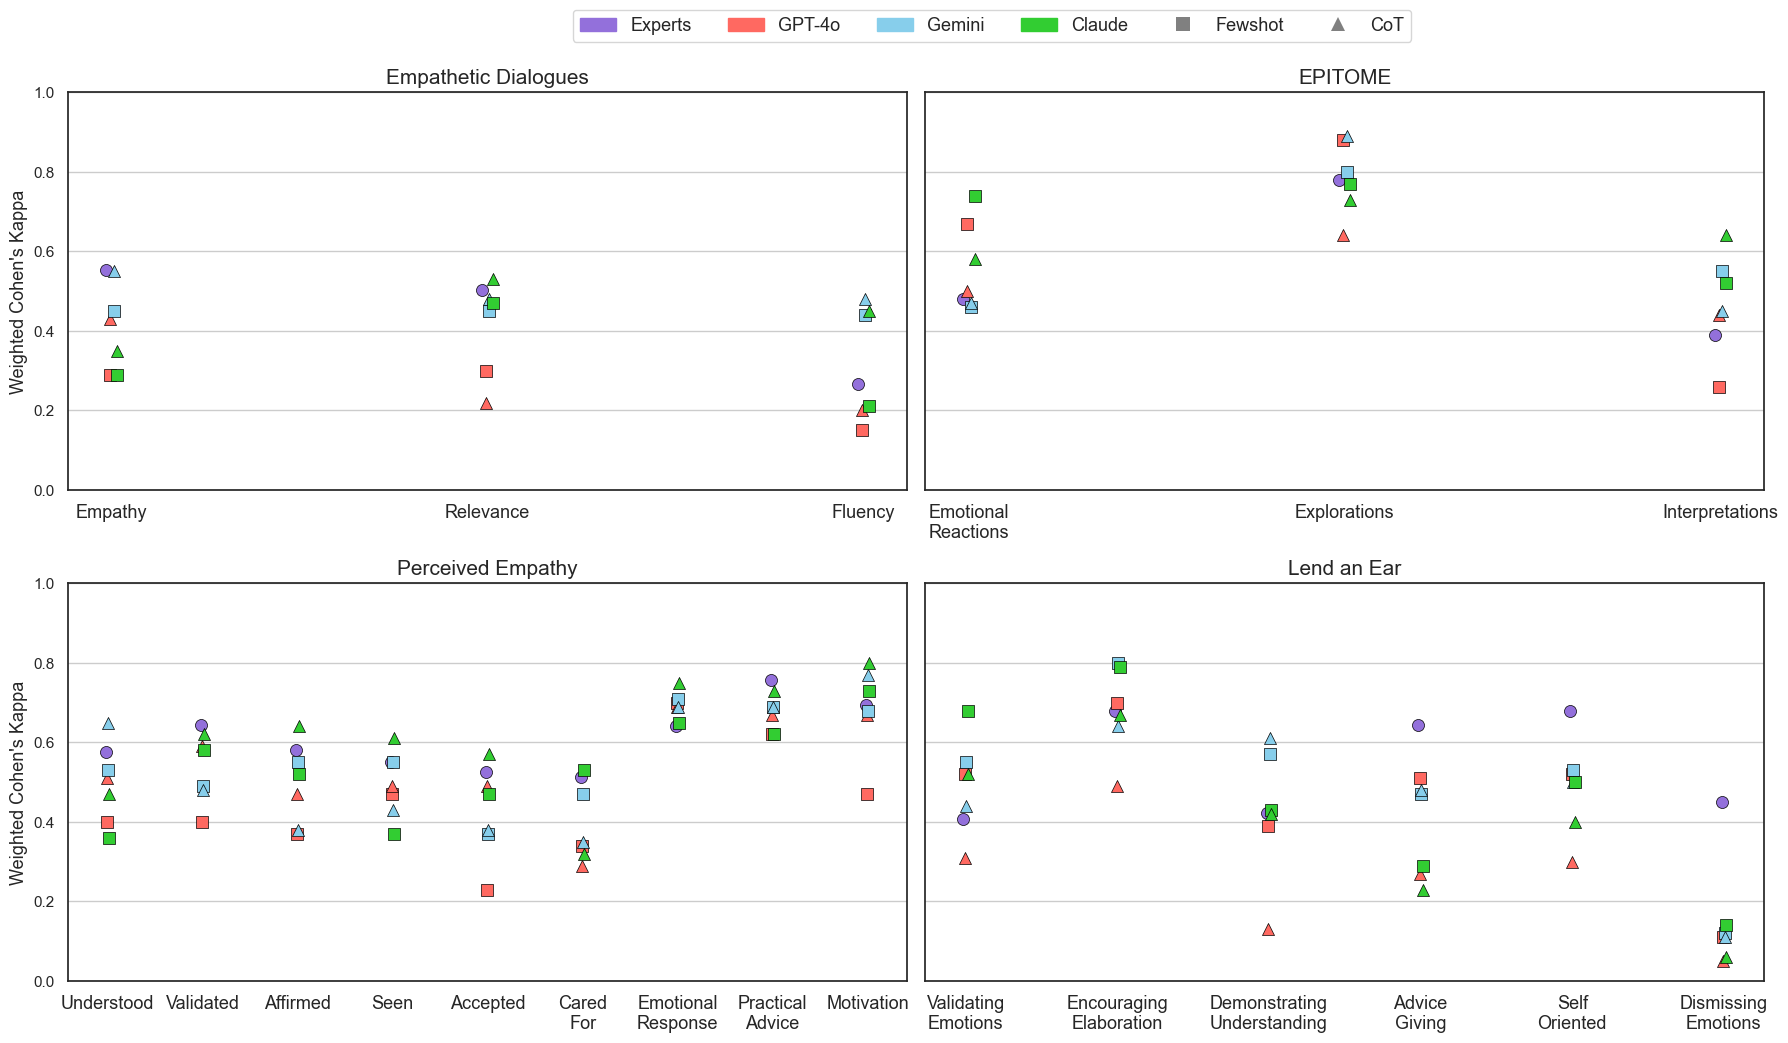

In [29]:
# Step 1: Compute average of expert kappas
combined[('Experts', 'avg')] = combined[('Experts', '1 vs 2')].astype(float) \
    .add(combined[('Experts', '1 vs 3')], fill_value=0) \
    .add(combined[('Experts', '2 vs 3')], fill_value=0) / 3

# Step 2: Flatten MultiIndex columns
combined_flat = combined.copy()
combined_flat.columns = ['_'.join(col).strip('_') for col in combined.columns]

# Step 3: Select relevant columns
model_columns = [
    'Experts_avg',
    'GPT-4o_Fewshot', 'GPT-4o_CoT',
    'Gemini (2.5 pro)_Fewshot', 'Gemini (2.5 pro)_CoT',
    'Claude_Fewshot', 'Claude_CoT'
]
keep_cols = ['Dataset', 'Dimension'] + model_columns
df_plot = combined_flat[keep_cols]

# Step 4: Melt to long format
df_long = pd.melt(
    df_plot,
    id_vars=['Dataset', 'Dimension'],
    var_name='ModelPrompt',
    value_name='Kappa'
)

# Step 5: Annotator & Prompt type
df_long['Annotator'] = df_long['ModelPrompt'].apply(
    lambda x: 'Experts' if 'Experts' in x else
              'GPT-4o' if 'GPT-4o' in x else
              'Gemini' if 'Gemini' in x else 'Claude'
)
df_long['Prompt'] = df_long['ModelPrompt'].apply(
    lambda x: 'Fewshot' if 'Fewshot' in x else
              'CoT' if 'CoT' in x else 'N/A'
)
# Step 7: Define offset logic
annotators = ['Experts', 'GPT-4o', 'Gemini', 'Claude']
prompt_types = ['Fewshot', 'CoT']

color_map = {
    'Experts': '#9370DB',
    'GPT-4o': '#FF6961',
    'Gemini': '#87CEEB',
    'Claude': '#32CD32'
}
marker_map = {
    'Fewshot': 's',
    'CoT': '^'
}
n_annotators = len(annotators)
offset_vals = np.linspace(-(n_annotators - 1)/2, (n_annotators - 1)/2, n_annotators) * 0.01
offset_map = dict(zip(annotators, offset_vals))

# Step 8: Create 2x2 subplot layout
datasets = ['EmpatheticDialogues', 'EPITOME', 'Perceived Empathy', 'RPG']
print(datasets)
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for i, dataset in enumerate(datasets):
    ax = axes[i]
    subset = df_long[df_long['Dataset'] == dataset].copy()
    dims = subset['Dimension'].unique()
    x_pos_map = {dim: i for i, dim in enumerate(dims)}
    ax.set_xticks(range(len(dims)))  # Set exact positions for each dim

    for _, row in subset.iterrows():
        x_base = x_pos_map[row['Dimension']]
        x = x_base + offset_map[row['Annotator']]
        y = row['Kappa']
        ax.scatter(
            x,
            y,
            color=color_map[row['Annotator']],
            marker='o' if row['Annotator'] == 'Experts' else marker_map.get(row['Prompt'], 'X'),
            s=75,
            edgecolor='black',
            linewidth=0.5
        )
    rename_map = {
    'validating_emotions': 'Validating\nEmotions',
    'encouraging_elaboration': 'Encouraging\nElaboration',
    'demonstrating_understanding': 'Demonstrating\nUnderstanding',
    'advice_giving': 'Advice\nGiving',
    'self_oriented': 'Self\nOriented',
    'dismissing_emotions': 'Dismissing\nEmotions',
    'level_explorations': 'Explorations',
    'level_emotional_reactions': 'Emotional\nReactions',
    'level_interpretations': 'Interpretations',
    'empathy': 'Empathy',
    'relevance': 'Relevance',
    'fluency': 'Fluency',
    'm_understood': 'Understood',
    'm_validated': 'Validated',
    'm_affirmed': 'Affirmed',
    'm_caredfor': 'Cared\nFor',
    'm_accepted': 'Accepted',
    'm_seen': 'Seen',
    'm_emotional': 'Emotional\nResponse',
    'm_practical': 'Practical\nAdvice',
    'm_motivation': 'Motivation'
    }
    custom_labels = [rename_map.get(dim, dim) for dim in dims]
    ax.set_xticklabels(custom_labels, rotation=0, ha='center')

    title_map = {
    'RPG': 'Lend an Ear',
    'EPITOME': 'EPITOME',
    'Perceived Empathy': 'Perceived Empathy',
    'EmpatheticDialogues': 'Empathetic Dialogues'
    }   
    ax.set_title(title_map.get(dataset, dataset), fontsize = 15)
    ax.set_xticks(range(len(dims)))
    ax.set_xticklabels(custom_labels, rotation=0, ha='center', fontsize=13)
    ax.set_ylim(0, 1)
    ax.grid(axis='y')
    if i % 2 == 0:
        ax.set_ylabel("Weighted Cohen's Kappa", fontsize = 13)

# Step 9: Shared legends
color_legend = [Patch(color=color_map[a], label=a) for a in annotators]
shape_legend = [
    Line2D([0], [0], marker=marker_map[p], color='black', linestyle='',
           markerfacecolor='gray', markersize=10, label=p, markeredgewidth=0)
    for p in prompt_types
]

# Combine both legends
all_handles = color_legend + shape_legend

# Create a single horizontal legend at the top center
fig.legend(handles=all_handles,
           loc='lower center',  # We'll position it precisely with bbox_to_anchor
           bbox_to_anchor=(0.5, 1.0),  # Slightly above the top (1.05)
           ncol=len(all_handles),  # All items in one row
           frameon=True,
           fontsize=13)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leaves 10% space at the top
plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on the right for legend
plt.show()

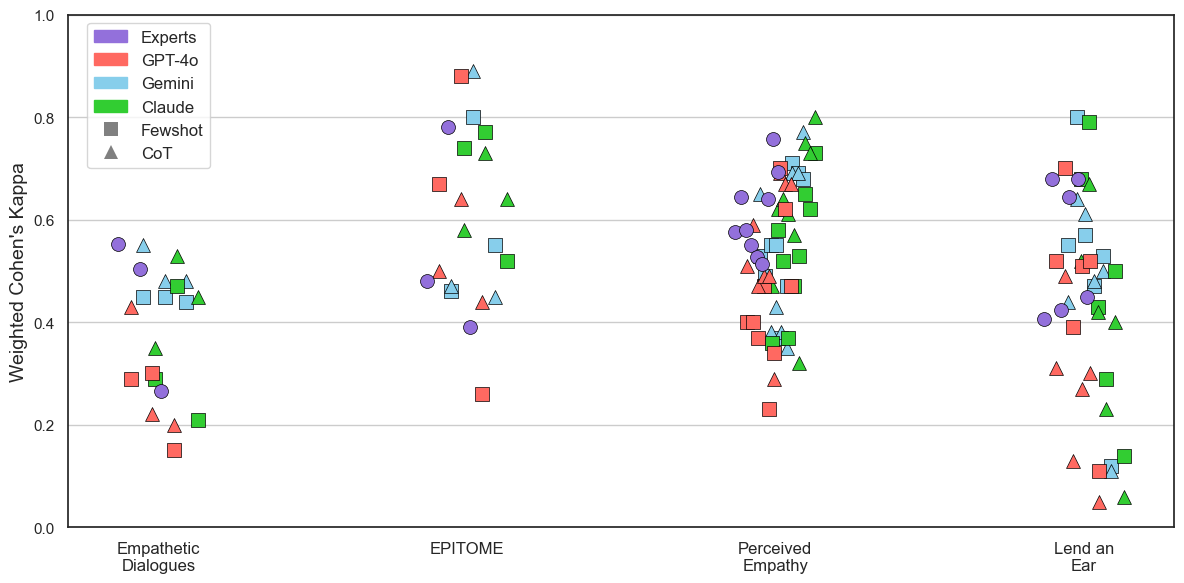

In [30]:
# A: Base x-axis for datasets
dataset_order = ['EmpatheticDialogues', 'EPITOME', 'Perceived Empathy', 'RPG']
dataset_xpos = {d: i for i, d in enumerate(dataset_order)}
df_long['dataset_x'] = df_long['Dataset'].map(dataset_xpos)

offset_vals = np.linspace(-(n_annotators - 1)/2, (n_annotators - 1)/2, n_annotators) * 0.04  # <- reduced from 0.05
offset_map = dict(zip(annotators, offset_vals))  # make sure this exists before use

# B: Dimension-level jitter within dataset
from collections import defaultdict
dim_offsets = defaultdict(dict)

for dset in dataset_order:
    dims = df_long[df_long['Dataset'] == dset]['Dimension'].unique()
    offsets = np.linspace(-0.07, 0.07, len(dims))  # smaller spread for cleaner clusters
    dim_offsets[dset] = dict(zip(dims, offsets))

df_long['dim_offset'] = df_long.apply(lambda row: dim_offsets[row['Dataset']][row['Dimension']], axis=1)

df_long['x'] = df_long['dataset_x'] + df_long['dim_offset'] + df_long['Annotator'].map(offset_map)

# D: Plot
fig, ax = plt.subplots(figsize=(12, 6))

for _, row in df_long.iterrows():
    ax.scatter(
        row['x'],
        row['Kappa'],
        color=color_map[row['Annotator']],
        marker='o' if row['Annotator'] == 'Experts' else marker_map.get(row['Prompt'], 'X'),
        s=100,
        edgecolor='black',
        linewidth=0.5,
        zorder=3 if row['Annotator'] == 'Experts' else 2 if row['Annotator'] == 'GPT-4o' else 1
    )

# E: Formatting
ax.set_xticks(range(len(dataset_order)))
ax.set_xticklabels(['Empathetic\nDialogues', 'EPITOME', 'Perceived\nEmpathy', 'Lend an\nEar'], fontsize=12)
ax.set_ylabel("Weighted Cohen's Kappa", fontsize=14)
ax.set_ylim(0, 1)
ax.grid(axis='y')

# F: Legends
color_legend = [Patch(color=color_map[a], label=a) for a in annotators]
shape_legend = [
    Line2D([0], [0], marker=marker_map[p], color='black', linestyle='',
           markerfacecolor='gray', markersize=10, label=p, markeredgewidth=0)
    for p in prompt_types
]
all_handles = color_legend + shape_legend
ax.legend(handles=all_handles, bbox_to_anchor=(0.01, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

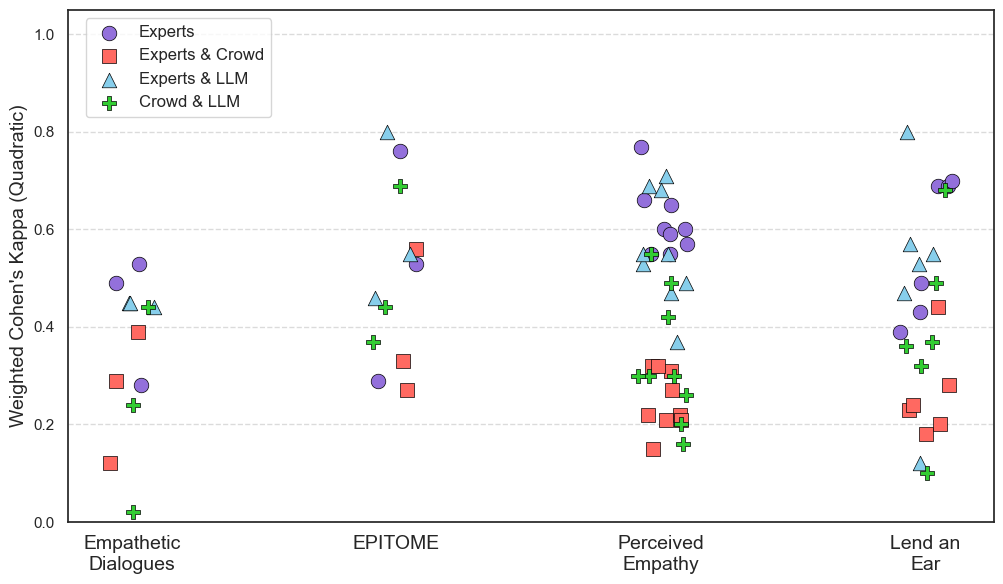

In [31]:
combined[("Experts", "Median")] = combined[[("Experts", "1 vs 2"), ("Experts", "1 vs 3"), ("Experts", "2 vs 3")]].median(axis=1)

# Step 2: Build long-form DataFrame
# Reshape the data from wide to long format for easier plotting with libraries like seaborn or matplotlib.
# This makes 'Annotator Pair' and 'Kappa' their own columns.
plot_data = pd.DataFrame({
    "Dataset": combined[("Dataset", '')],
    "Dimension": combined[("Dimension", '')],
    "Experts": combined[("Experts", "Median")],
    "Experts & LLM": combined[("Gemini (2.5 pro)", "Fewshot")],
    "Experts & Crowd": combined[("Expert & Crowd", "")],
    "Crowd & LLM": combined[("Crowd & LLM", "")]
})

plot_data = plot_data.melt(
    id_vars=["Dataset", "Dimension"], # Columns to keep
    var_name="Annotator Pair",      # Name for the new column holding the 'melted' column names
    value_name="Kappa"              # Name for the new column holding the values
)

# Step 3: Clean and normalize
# Convert 'Kappa' column to numeric, coercing errors (non-numeric values become NaN).
plot_data["Kappa"] = pd.to_numeric(plot_data["Kappa"], errors="coerce")
# Standardize dataset names for consistency in the plot.
plot_data["Dataset"] = plot_data["Dataset"].replace({
    "RPG": "Lend an\nEar",
    "EPITOME": "EPITOME",
    "EmpatheticDialogues": "Empathetic\nDialogues",
    "Perceived Empathy": "Perceived\nEmpathy"
})

# Step 4: Aesthetic mappings
# Define lists, dictionaries for consistent styling (markers, colors) and ordering of categories.
annotators = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
marker_mapping = {
    "Experts": "o",          # Circle
    "Experts & Crowd": "s",  # Square
    "Experts & LLM": "^",    # Triangle up
    "Crowd & LLM": "P"       # Plus (filled)
}
color_mapping = {
    "Experts": "#9370DB",         # Medium Purple
    "Experts & Crowd": "#FF6961", # Pastel Red
    "Experts & LLM": "#87CEEB",   # Sky Blue
    "Crowd & LLM": "#32CD32"      # Lime Green
}
dataset_order = ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an\nEar"]

jitter_amount = 0.5

# Step 5: Manual scatter plot
fig, ax = plt.subplots(figsize=(12, 6)) # Increased figure width for better readability with jitter

for annotator_pair in annotators:
    # Filter data for the current annotator pair
    subset = plot_data[plot_data["Annotator Pair"] == annotator_pair]
    for i, dataset in enumerate(dataset_order):
        # Filter data for the current dataset
        y_vals = subset[subset["Dataset"] == dataset]["Kappa"].dropna() # Drop NaN values to avoid errors
        if y_vals.empty: # Skip if no data for this combination
            continue

        # Base x-position for the current dataset and annotator pair
        base_x = i

        # Generate jittered x-values:
        # For each point, add a random value between -jitter_amount/2 and +jitter_amount/2
        # to the base_x position.
        x_jittered = base_x + np.random.uniform(-jitter_amount / 5, jitter_amount / 5, size=len(y_vals))

        ax.scatter(
            x_jittered, # Use jittered x-values
            y_vals,
            label=annotator_pair, # Label for the legend (will be deduplicated later)
            marker=marker_mapping[annotator_pair],
            color=color_mapping[annotator_pair],
            edgecolor="black", # Edge color for markers
            linewidth=0.5,     # Linewidth for marker edges
            s=110               # Size of the markers
        )

# Step 6: Final touches
# Set x-axis ticks to be at the center of each dataset group
ax.set_xticks(range(len(dataset_order)))
ax.set_xticklabels(dataset_order, fontsize=14) # Set x-axis tick labels

# Set y-axis limits and label
ax.set_ylim(0, 1.05) # Slightly extend y-limit to avoid points touching the top edge
ax.set_ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid with styling

# Deduplicate legend: ensures each annotator pair appears only once in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # Create a dictionary to store unique labels and handles
ax.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper left", # Position of the legend
    bbox_to_anchor=(0.01, 1), # Place legend outside the plot area to the right
    fontsize=12,
)

# plt.title("Weighted Cohen's Kappa Across Annotator Groups", fontsize=16, y=1)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent labels/title from being cut off, considering legend

plt.show()

In [74]:
empathetic_dialogues_claude_0 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_0.csv').drop(columns=['full_conversation'])
empathetic_dialogues_claude_1 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_1.csv').drop(columns=['full_conversation'])
empathetic_dialogues_claude_2 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_2.csv').drop(columns=['full_conversation'])
empathetic_dialogues_claude_3 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_3.csv').drop(columns=['full_conversation'])
empathetic_dialogues_claude_4 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_4.csv').drop(columns=['full_conversation'])

empathetic_dialogues_gpt_0 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_0.csv').drop(columns=['full_conversation'])
empathetic_dialogues_gpt_1 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_1.csv').drop(columns=['full_conversation'])
empathetic_dialogues_gpt_2 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_2.csv').drop(columns=['full_conversation'])
empathetic_dialogues_gpt_3 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_3.csv').drop(columns=['full_conversation'])
empathetic_dialogues_gpt_4 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_4.csv').drop(columns=['full_conversation'])

# empathetic_dialogues_gemini_0 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-flash-05-20_0.csv').drop(columns=['full_conversation'])
# empathetic_dialogues_gemini_1 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-flash-05-20_1.csv').drop(columns=['full_conversation'])
# empathetic_dialogues_gemini_2 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-flash-05-20_2.csv').drop(columns=['full_conversation'])
# empathetic_dialogues_gemini_3 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-flash-05-20_3.csv').drop(columns=['full_conversation'])
# empathetic_dialogues_gemini_4 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-flash-05-20_4.csv').drop(columns=['full_conversation'])

epitome_claude_0 = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_0.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_claude_1 = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_1.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_claude_2 = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_2.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_claude_3 = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_3.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_claude_4 = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_4.csv').drop(columns=['full_conversation', 'rp_id'])

epitome_gpt_0 = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_0.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_gpt_1 = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_1.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_gpt_2 = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_2.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_gpt_3 = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_3.csv').drop(columns=['full_conversation', 'rp_id'])
epitome_gpt_4 = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_4.csv').drop(columns=['full_conversation', 'rp_id'])

# epitome_gemini_0 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-flash-05-20_0.csv').drop(columns=['full_conversation', 'rp_id'])
# epitome_gemini_1 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-flash-05-20_1.csv').drop(columns=['full_conversation', 'rp_id'])
# epitome_gemini_2 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-flash-05-20_2.csv').drop(columns=['full_conversation', 'rp_id'])
# epitome_gemini_3 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-flash-05-20_3.csv').drop(columns=['full_conversation', 'rp_id'])
# epitome_gemini_4 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-flash-05-20_4.csv').drop(columns=['full_conversation', 'rp_id'])

perceived_empathy_claude_0 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_0.csv').drop(columns=['full_conversation'])
perceived_empathy_claude_1 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_1.csv').drop(columns=['full_conversation'])
perceived_empathy_claude_2 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_2.csv').drop(columns=['full_conversation'])
perceived_empathy_claude_3 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_3.csv').drop(columns=['full_conversation'])
perceived_empathy_claude_4 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_4.csv').drop(columns=['full_conversation'])

perceived_empathy_gpt_0 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_0.csv').drop(columns=['full_conversation'])
perceived_empathy_gpt_1 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_1.csv').drop(columns=['full_conversation'])
perceived_empathy_gpt_2 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_2.csv').drop(columns=['full_conversation'])
perceived_empathy_gpt_3 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_3.csv').drop(columns=['full_conversation'])
perceived_empathy_gpt_4 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_4.csv').drop(columns=['full_conversation'])

# perceived_empathy_gemini_0 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-flash-05-20_0.csv')
# perceived_empathy_gemini_1 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-flash-05-20_1.csv')
# perceived_empathy_gemini_2 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-flash-05-20_2.csv')
# perceived_empathy_gemini_3 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-flash-05-20_3.csv')
# perceived_empathy_gemini_4 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-flash-05-20_4.csv')

rpg_claude_0 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_0.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_claude_1 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_1.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_claude_2 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_2.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_claude_3 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_3.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_claude_4 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_4.csv').drop(columns=['Unnamed: 0', 'full_conversation'])

rpg_gpt_0 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_0.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_gpt_1 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_1.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_gpt_2 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_2.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_gpt_3 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_3.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
rpg_gpt_4 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_4.csv').drop(columns=['Unnamed: 0', 'full_conversation'])

# rpg_gemini_0 = pd.read_csv('data/Robustness Check Data/llm_rpg_gemini-2.5-pro-flash-05-20_0.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
# rpg_gemini_1 = pd.read_csv('data/Robustness Check Data/llm_rpg_gemini-2.5-pro-flash-05-20_1.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
# rpg_gemini_2 = pd.read_csv('data/Robustness Check Data/llm_rpg_gemini-2.5-pro-flash-05-20_2.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
# rpg_gemini_3 = pd.read_csv('data/Robustness Check Data/llm_rpg_gemini-2.5-pro-flash-05-20_3.csv').drop(columns=['Unnamed: 0', 'full_conversation'])
# rpg_gemini_4 = pd.read_csv('data/Robustness Check Data/llm_rpg_gemini-2.5-pro-flash-05-20_4.csv').drop(columns=['Unnamed: 0', 'full_conversation'])

def median_df(df0, df1, df2, df3, df4, id):
    # List of DataFrames (each must have a 'conversation_id' column)
    dfs = [df0, df1, df2, df3, df4]

    # Concatenate them into one long DataFrame
    stacked = pd.concat(dfs)

    # Group by 'conversation_id' and take the median for each group
    median_df = stacked.groupby(id).median().reset_index()
    return median_df

rpg_gpt_median = median_df(rpg_gpt_0, rpg_gpt_1, rpg_gpt_2, rpg_gpt_3, rpg_gpt_4, 'conversation_id')
rpg_claude_median = median_df(rpg_claude_0, rpg_claude_1, rpg_claude_2, rpg_claude_3, rpg_claude_4, 'conversation_id')
#rpg_gemini_median = median_df(rpg_gemini_0, rpg_gemini_1, rpg_gemini_2, rpg_gemini_3, rpg_gemini_4, 'conversation_id')

perceived_empathy_gpt_median = median_df(perceived_empathy_gpt_0, perceived_empathy_gpt_1, perceived_empathy_gpt_2, perceived_empathy_gpt_3, perceived_empathy_gpt_4, 'conversation_id')
perceived_empathy_claude_median = median_df(perceived_empathy_claude_0, perceived_empathy_claude_1, perceived_empathy_claude_2, perceived_empathy_claude_3, perceived_empathy_claude_4, 'conversation_id')
#perceived_empathy_gemini_median = median_df(perceived_empathy_gemini_0, perceived_empathy_gemini_1, perceived_empathy_gemini_2, perceived_empathy_gemini_3, perceived_empathy_gemini_4, 'conversation_id')

epitome_gpt_median = median_df(epitome_gpt_0, epitome_gpt_1, epitome_gpt_2, epitome_gpt_3, epitome_gpt_4, 'sp_id')
epitome_claude_median = median_df(epitome_claude_0, epitome_claude_1, epitome_claude_2, epitome_claude_3, epitome_claude_4, 'sp_id')
#epitome_gemini_median = median_df(epitome_gemini_0, epitome_gemini_1, epitome_gemini_2, epitome_gemini_3, epitome_gemini_4, 'sp_id')

empathetic_dialogues_gpt_median = median_df(empathetic_dialogues_gpt_0, empathetic_dialogues_gpt_1, empathetic_dialogues_gpt_2, empathetic_dialogues_gpt_3, empathetic_dialogues_gpt_4, 'conversation_id')
empathetic_dialogues_claude_median = median_df(empathetic_dialogues_claude_0, empathetic_dialogues_claude_1, empathetic_dialogues_claude_2, empathetic_dialogues_claude_3, empathetic_dialogues_claude_4, 'conversation_id')
#empathetic_dialogues_gemini_median = median_df(empathetic_dialogues_gemini_0, empathetic_dialogues_gemini_1, empathetic_dialogues_gemini_2, empathetic_dialogues_gemini_3, empathetic_dialogues_gemini_4, 'conversation_id')

rpg_gpt_median.to_csv('data/rpg/gpt_median_ratings.csv', index= 'ignore')
rpg_claude_median.to_csv('data/rpg/claude_median_ratings.csv', index= 'ignore')
#rpg_gemini_median.to_csv('data/rpg/gemini_median_ratings.csv', index= 'ignore')

perceived_empathy_gpt_median.to_csv('data/perceived_empathy/gpt_median_ratings.csv', index= 'ignore')
perceived_empathy_claude_median.to_csv('data/perceived_empathy/claude_median_ratings.csv', index= 'ignore')
#perceived_empathy_gemini_median.to_csv('data/perceived_empathy/gemini_median_ratings.csv', index= 'ignore')

epitome_gpt_median.to_csv('data/epitome/gpt_median_ratings.csv', index= 'ignore')
epitome_claude_median.to_csv('data/epitome/claude_median_ratings.csv', index= 'ignore')
#epitome_gemini_median.to_csv('data/epitome/gemini_median_ratings.csv', index= 'ignore')

empathetic_dialogues_gpt_median.to_csv('data/empatheticdialogues/gpt_median_ratings.csv', index= 'ignore')
empathetic_dialogues_claude_median.to_csv('data/empatheticdialogues/claude_median_ratings.csv', index= 'ignore')
#empathetic_dialogues_gemini_median.to_csv('data/empatheticdialogues/gemini_median_ratings.csv', index= 'ignore')